# Natural Language Processing, 2022/23
Group composition:
* Boscarino Chiara
* Pablo Giaccaglia
* Federico Carrara
* Alessandro La Conca

In [ ]:
# SET HERE YOUR WORKING PATH to the shared directory
path = '/content/drive/MyDrive/POLIMI/NLP/NLP-Project'

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

# Insert here the path of the working folder
os.chdir(path)

# Check the currect working directory
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/.shortcut-targets-by-id/1mUiAg4YzyVaZ9PavjfUIjvy2mBz5-HE3/NLP-Project'

# Pre-Ops


---



In [ ]:
import pandas as pd
import numpy as np
import os
import json
import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as sched
from torch.utils.data import Dataset
import random
import pickle
import math
import ast
import spacy
from spacy.lang.en import English
import torch.nn as nn

nlp = English()
tqdm.pandas()


#  SQuAD 2.0

---

The project involves a question answering task using the updated version of the Stanford Question Answering Dataset (SQuAD 2.0). This new version expands the original dataset by including unanswerable questions. The primary objective is to develop sophisticated models and employ state-of-the-art techniques to excel in reading comprehension. The dataset comprises paragraphs sourced from Wikipedia, with accompanying questions and their respective answers for training and testing the models. The extended version used in this study also includes questions that cannot be answered using the provided paragraph. SQuAD 2.0 consists of approximately 150k questions in total, with roughly half of them being unanswerable.

In [ ]:
test_set_path = "dataset/dev-v2.0.json"
example_pred_path = "dataset/example_predictions.json" #Example prediction file
train_set_path = "dataset/train-v2.0.json"

The json contains
> A set of **reading passages**, which are the texts containing the relevant information of reference, they are the **context** in the json

> For each context is provided a set of **questions and answers (Q&A)**, they are in the **qas** section in the json. It contains both answerable and unanswerable questions given the context


> Each **ANSWERABLE QUESTION** is defined by:
-  the text of the question
-  the Q&A identifier
- a set  of possible answers, each containing
  - the text of the answer   
  - the start position of the answer on the context
- the flag defining that the question can be answered given the context ("'is_impossible': False")  


> Each **UNANSWERABLE QUESTION** is defined by:
- a set of plausible answers, each containing
  - the text of the answer  
  - the start position of the answer on the context
- the text of the question
- the Q&A identifier
- an empty set of answers
- the flag defining that the question cannot be answered given the context ("'is_impossible': True")  


Examples of Q&As:


```
{'question': 'What is the law of thermodynamics associated with closed system heat exchange?',
       'id': '5737a9afc3c5551400e51f64',
       'answers': [{'text': 'Second', 'answer_start': 331},
        {'text': 'Second law of thermodynamics', 'answer_start': 331},
        {'text': 'Second law', 'answer_start': 331},
        {'text': 'Second', 'answer_start': 331}],
       'is_impossible': False}

```
Some questions have multiple possible answers, as in this case. Others, have a single answer possible, but repeated multiple times for accordance, as in the follwing case:

```
{'question': 'What seldom used term of a unit of force equal to 1000 pound s of force?',
       'id': '5737aafd1c456719005744fe',
       'answers': [{'text': 'kip', 'answer_start': 712},
        {'text': 'kip', 'answer_start': 712},
        {'text': 'kip', 'answer_start': 712},
        {'text': 'kip', 'answer_start': 712},
        {'text': 'kip', 'answer_start': 712}],
       'is_impossible': False}
```

Cases in which the question is unanswerable given the corresponding reading passage:


```
{'plausible_answers': [{'text': 'gradient of potentials',
         'answer_start': 81}],
       'question': 'It is always possible to model forces as being due to what?',
       'id': '5ad289c2d7d075001a42999e',
       'answers': [],
       'is_impossible': True}

```

Finally, as suggested by the Standford SQuAd challenge, predictions should be in the format:

```
{"question_id_1": "answer1",
  "question_id_2": "answer2",

Note that an empty answer means NO possible answer

Example:
{"57264e2f708984140094c1e4": "south of France and Germany",  
 "56e2042ecd28a01900c67c20": "Hisao Yamada",
 "573784fa1c45671900574487": "",
 ...
}

```

# 1. EDA
----
As an essential initial step towards further development, we conducted an Exploratory Data Analysis (EDA). During this phase, we examined the structure and content of the SQuAD 2.0 dataset using a combination of basic statistical tools and Deep Learning techniques. The goal was to gain a comprehensive understanding of the provided data, determine the methods for accessing it, and identify challenging aspects of the task as well as potential biases that could impact model performance.



We started by loading the JSON files and converting them in a more usable structure.

This included:


*   Reading JSON files and extraction of samples
*   Conversion of all the samples to a pandas dataframe having, for each row, a single question-answer-context instance
*   Duplicates **removal**





In [ ]:
def load_json(file_path: str):
  with open(file_path,'r') as f:
    return json.loads(f.read())

def squad_json_to_df(file_path: str):

  # Import the json
  squad_json = load_json(file_path = file_path)
  df = pd.json_normalize(squad_json,
                        record_path= ['data','paragraphs','qas'],#path to the json containing answers {text is the answer and answer_start is the starting pos in the story}
                        meta= [['data','paragraphs','context'],])# The story on which question are asked

  df = df.explode('answers') #Adds a row for each answer {text,answer_start}

  #Split answer into text and answer_start columns
  df[["answer"]] = df[["answers"]].applymap(lambda x: x['text'], na_action='ignore')
  df[["answer_start"]] = df[["answers"]].applymap(lambda x: x['answer_start'], na_action='ignore')
  del df['answers']

  #Adds a row for each plausible answer {text,answer_start}. They are answers when an answer is not possible
  df = df.explode('plausible_answers')

  #Split plausible answer into text and answer columns
  df[["plausible_answer"]] = df[["plausible_answers"]].applymap(lambda x: x['text'],na_action='ignore')
  df[["plausible_answer_start"]] = df[["plausible_answers"]].applymap(lambda x: x['answer_start'],na_action='ignore')
  del df['plausible_answers']

  # Removing duplicates
  df = df.drop_duplicates()

  # Renaming columns
  # old name = new name
  dict = {'data.paragraphs.context': 'context',
          'is_impossible': 'impossible'
          }
  df.rename(columns=dict,inplace=True)

  df = df.astype({"question": str})
  df = df.astype({"context": str})

  return df

In [ ]:
train_df = squad_json_to_df(file_path = train_set_path)
test_df = squad_json_to_df(file_path = test_set_path)

In [ ]:
class DataLocations:
    def __init__(self, init, mid, final, is_test, use_full_spacy_pipe):
        self.init = init
        self.mid = mid
        self.final = final
        self.is_test = is_test
        self.use_full_spacy_pipe = use_full_spacy_pipe

train_locs = DataLocations('dataset/train_df.csv',
                           'dataset/mid_processed_data_train.csv',
                           'dataset/train_data_frame_preprocessed.csv', False, True)

val_locs = DataLocations('dataset/val_df.csv',
                         'dataset/mid_processed_data_val.csv',
                         'dataset/val_data_frame_preprocessed.csv', False, True)

dev_locs = DataLocations('dataset/dev_df.csv',
                         'dataset/mid_processed_data_dev.csv',
                         'dataset/dev_data_frame_preprocessed.csv', True, True)

### Exploration and statistics

Once we have obtained the dataframes both for the train and the test set we can explore their content.

In [ ]:
class Colour:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[33m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
def inspect_item(id, df):
  item = df[df["id"] == id]
  context = item["context"].values[0]

  if not item["impossible"].values[0]:
    answer = item["answer"].values[0]
    start = int(item['answer_start'].values[0])
    end = start+len(answer)

  else:
    answer = item["plausible_answer"].values[0]
    start = int(item['plausible_answer_start'].values[0])
    end = start+len(answer)

  print("Question: ", item["question"].values[0])
  print("Possible answer? ", "YES" if not item["impossible"].values[0] else "NO, plausible answers")
  print("Answer :", answer)
  print("Context: ", context[:start] + Colour.YELLOW + context[start:end] + Colour.END + context[end:])

In [ ]:
inspect_item("56bf79c73aeaaa14008c9671", train_df)

Question:  At what age did Beyonce meet LaTavia Robertson?
Possible answer?  YES
Answer : age eight
Context:  At age eight, Beyoncé and childhood friend Kelly Rowland met LaTavia Roberson while in an audition for an all-girl entertainment group. They were placed into a group with three other girls as Girl's Tyme, and rapped and danced on the talent show circuit in Houston. After seeing the group, R&B producer Arne Frager brought them to his Northern California studio and placed them in Star Search, the largest talent show on national TV at the time. Girl's Tyme failed to win, and Beyoncé later said the song they performed was not good. In 1995 Beyoncé's father resigned from his job to manage the group. The move reduced Beyoncé's family's income by half, and her parents were forced to move into separated apartments. Mathew cut the original line-up to four and the group continued performing as an opening act for other established R&B girl groups. The girls auditioned before record labels

In [ ]:
inspect_item("5a7e070b70df9f001a87543d", train_df)

Question:  What field of study has a variety of unusual contexts?
Possible answer?  NO, plausible answers
Answer : physics
Context:  The term "matter" is used throughout physics in a bewildering variety of contexts: for example, one refers to "condensed matter physics", "elementary matter", "partonic" matter, "dark" matter, "anti"-matter, "strange" matter, and "nuclear" matter. In discussions of matter and antimatter, normal matter has been referred to by Alfvén as koinomatter (Gk. common matter). It is fair to say that in physics, there is no broad consensus as to a general definition of matter, and the term "matter" usually is used in conjunction with a specifying modifier.


In [ ]:
print(f"The train set consists in {train_df.shape[0]} samples")
print(f"The test set consists in {test_df.shape[0]} samples")
print()
print(f"In both dataset each sample presents {train_df.shape[1] if train_df.shape[1]==test_df.shape[1] else None} columns, \n\tnamely:  {list(train_df.columns)}")

The train set consists in 130319 samples
The test set consists in 16333 samples

In both dataset each sample presents 8 columns, 
	namely:  ['question', 'id', 'impossible', 'context', 'answer', 'answer_start', 'plausible_answer', 'plausible_answer_start']


We can check for the presence of null values.

In [ ]:
# Verify which fields contain null values and how much
train_df.isnull().sum()

question                      0
id                            0
impossible                    0
context                       0
answer                    43498
answer_start              43498
plausible_answer          86821
plausible_answer_start    86821
dtype: int64

In [ ]:
# check the number of ANSWERABLE Q&A
train_df['impossible'].describe()

count     130319
unique         2
top        False
freq       86821
Name: impossible, dtype: object

Note that the null values in answer and plausible_answer correspond to the number of Possible/Impossible answers according to the flag. Indeed, visualizing the portion of answerable and non answerable questions the numbers add up.

In [ ]:
def get_pie_chart(train_df):
  # Data
  labels = ['Answerable', 'Unanswerable']
  sizes = np.array([train_df[~train_df['impossible']]['impossible'].count(), train_df[train_df['impossible']]['impossible'].count()])
  explode = (0, 0.1) # Explode the 2nd wedge
  colors = ['#008050','#ffa500'] # Set custom colors

  # Create pie chart
  plt.pie(sizes, labels=labels, explode=explode, colors=colors,
          autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*sizes.sum()), shadow=True, startangle=90)

  # Set axis equal to draw a circle
  plt.axis('equal')

  # Show plot
  plt.show()

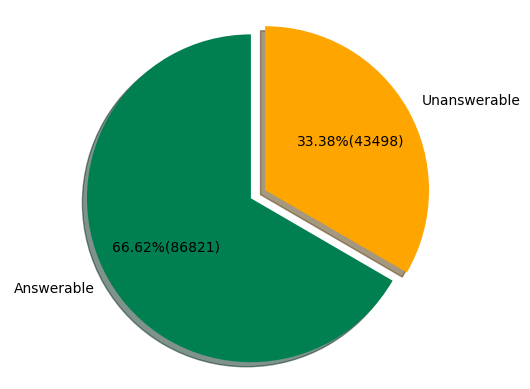

In [ ]:
get_pie_chart(train_df)

Therefore, each answerable question has the fields **ANSWER** - **ANSWER_START** non-null, while **PLAUSIBLE_ANSWER** - **PLAUSIBLE_ANSWER_START** as NaN. The opposite holds for the unanswerable ones.


Then we can get some statistics.

In [ ]:
nltk.download('stopwords')

def get_text_statistics(text_field, df):

  # setting the regex to count words excluding punctuation
  regex = '[' + string.punctuation + ']'

  # getting the text of interest and the relative id
  statistics = df[['id',text_field]].copy()

  # getting the length of the text in char
  statistics.loc[:, 'length (char)'] = df[text_field].apply(lambda x: len(x))

  # getting the length of the text in words after removing punctuation
  statistics.loc[:, 'length (words)'] = df[text_field].apply(lambda x: len(re.sub(regex,'',x).lower().split()))

  # getting the length of the text in words after removing punctuation and stopwords
  statistics.loc[:, 'length (words, no stopwords)'] = df[text_field].apply(lambda x: len([word for word in re.sub(regex,'',x).lower().split() if word not in stopwords.words('english')]))

  return statistics


def plot_histograms(df, nb, label):
    # Create three separate histograms for the columns 'length (char)', 'length (words)', and 'length (words, no stopwords)'
    fig, ax = plt.subplots(1,3, figsize=(20,5))
    sns.histplot(df['length (char)'], ax=ax[0], bins= nb, kde=True)
    sns.histplot(df['length (words)'], ax=ax[1], bins= nb, kde=True)
    sns.histplot(df['length (words, no stopwords)'], ax=ax[2], bins= nb, kde=True)

    # Add labels to the x-axis and y-axis for each histogram
    ax[0].set_xlabel('Length (char)')
    ax[0].set_ylabel('Frequency')
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[1].set_xlabel('Length (words)')
    ax[1].set_ylabel('Frequency')
    ax[2].set_xlabel('Length (words, no stopwords)')
    ax[2].set_ylabel('Frequency')

    # Display the histograms
    fig.suptitle(label, fontsize=20)
    plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_question_statistics = get_text_statistics('question',train_df)
train_context_statistics = get_text_statistics('context',train_df)

We can investigate the length of the provided texts, both in terms of chars, words and significant words (namely not including the stopwords).

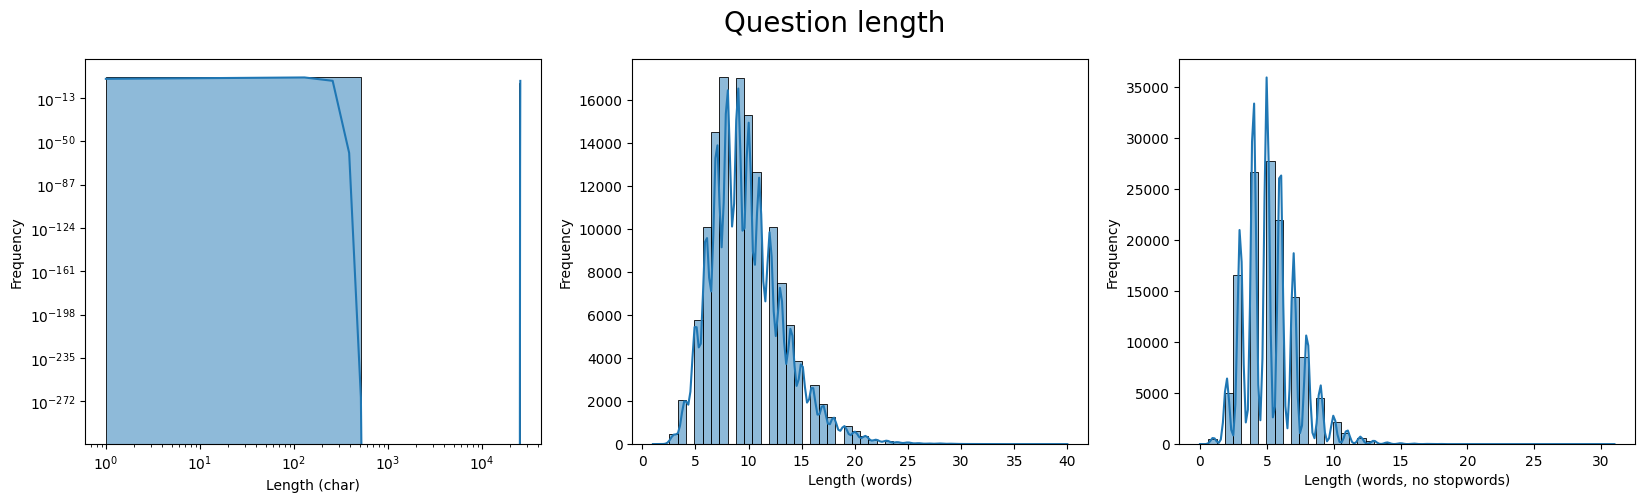

In [ ]:
plot_histograms(train_question_statistics, 50, 'Question length')

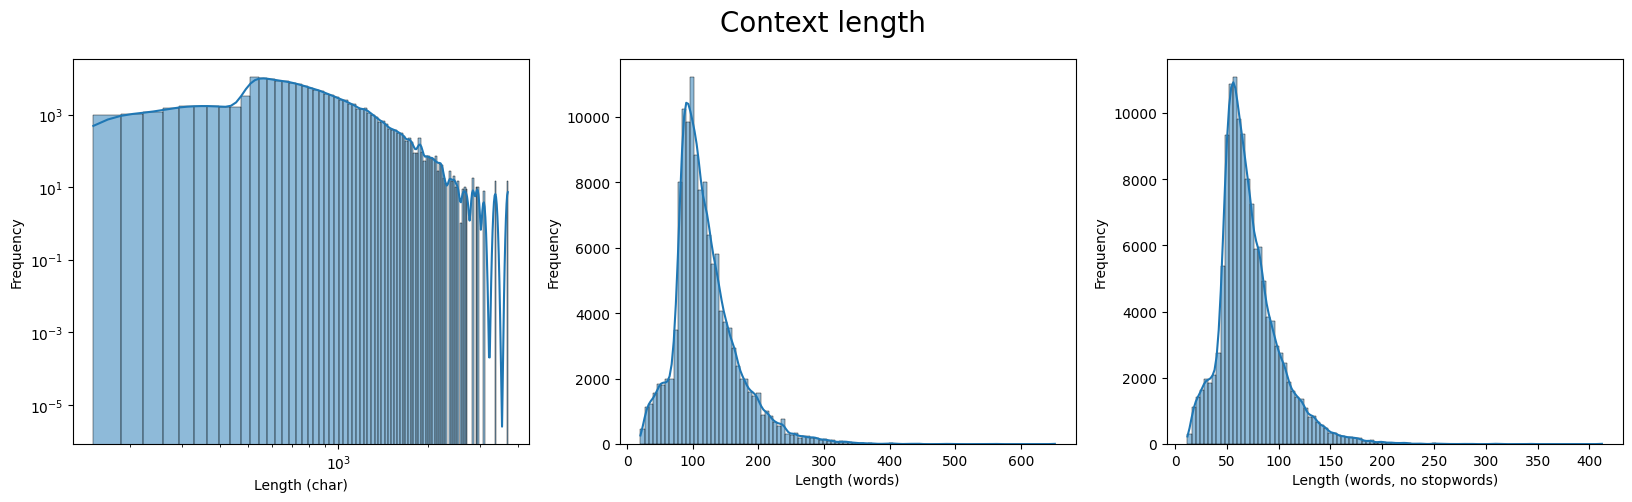

In [ ]:
plot_histograms(train_context_statistics,100, 'Context length')

### Language check

When dealing with NLP task, it is always relevant to consider the language of reference for the task. So we will check if all provided texts are in english, to understand wheter to define a single- or a multi-lingual model.

In [ ]:
!pip3 install -q transformers datasets

In [ ]:
from transformers import pipeline

In [ ]:
model_name = "papluca/xlm-roberta-base-language-detection"
nlp_detector = pipeline("text-classification", model=model_name)

In [ ]:
def check_language(df, detector, lim):
  model_preds_q = nlp_detector(train_df['question'][:lim].tolist())
  model_preds_c = nlp_detector(train_df['context'][:lim].tolist())

  return model_preds_q, model_preds_c

def verify_notenglish(model_preds_q, model_preds_c, thr):
  q_bin = list(map(lambda x: 1 if not (x['label']=='en' and x['score']>thr) else 0, model_preds_q))
  c_bin = list(map(lambda x: 1 if not (x['label']=='en' and x['score']>thr) else 0, model_preds_c))
  print("Questions suspected to be not in english: ", sum(q_bin))
  print("Contexts suspected to be not in english: ", sum(c_bin))
  print()
  print("Questions:")
  print([train_df['question'][i] for i,x in enumerate(q_bin) if x])
  print()
  print("Contexts:")
  print([train_df['context'][i] for i,x in enumerate(c_bin) if x])

In [ ]:
[model_preds_q, model_preds_c] = check_language(train_df, nlp_detector, 300)

In [ ]:
verify_notenglish(model_preds_q, model_preds_c, 0.55)

## Topic analysis
Then, let's have a look about the topics of the provided contexts. In the following section we will:


*   train a word2vec embedding on our data and compare it with a pretrained glove ('glove-wiki-gigaword-300')
*   cluster the contexts using the embeddings to get an insight over the dataset content

In [ ]:
contexts = pd.DataFrame(train_df['context'].unique(), columns=["text"])
print(len(contexts))

### I. Prepare the contexts

In [ ]:
def clean_text(text, tokenizer, stopwords, min_token_length):
    # Pre-process text and generate tokens

    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text

    corpus_stopwords_thr = 0.8 # ignore terms with document frequency > thr when building the vocabulary (corpus-specific stop words)
    vocab_cutoff = 0.001 # ignore terms with document frequency < thr when building the vocabulary

    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > min_token_length]  # Remove short tokens

    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords

    tokens = [t for t in tokens if (tokens.count(t) > vocab_cutoff*len(tokens) and tokens.count(t) < corpus_stopwords_thr*len(tokens))] # Remove corpus-specific stop words and too rare words

    return tokens

In [ ]:
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")

sw = stopwords.words("english")

contexts["tokens"] = contexts["text"].map(lambda x: clean_text(x, word_tokenize, sw, min_token_length=1))

In [ ]:
# Remove empty values and keep relevant columns if present
contexts = contexts.loc[contexts.tokens.map(lambda x: len(x) > 0), ["text", "tokens"]]
print(f"Removed: {19029-len(contexts)}")

### II. Generate the word2vec embedding

In [ ]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

In [ ]:
embedding_dim = 100
window_size = 10
minimum_count = 5
tokenized_sentences = contexts["tokens"].values.tolist()

model = Word2Vec(tokenized_sentences, vector_size= embedding_dim, min_count= minimum_count, window= window_size)

In [ ]:
print(f"Length of the vocabulary: {len(model.wv)}")

### III. Compare its performances with a pretrained glove over a  large wikipedia corpus

In [ ]:
def model_comparison(model1, model2, words):
  for word in words:
    print(f"{word}: ")
    print(model1.most_similar(word))
    print(model2.most_similar(word))
    print()

In [ ]:
#comparison with pre-trained model
wv_pt = api.load('glove-wiki-gigaword-300')

In [ ]:
print(f"Length of the vocabulary: {len(wv_pt)}")

In [ ]:
model_comparison(model.wv, wv_pt, ["physics", "literature","feminist"] )

### IV. Visualize the embeddings with TSNE

We'll use the t-distributed Stochastic Neighbor Embedding (TSNE) algorithm for dimensionality reduction.

In [ ]:
!pip install plotly
from sklearn.manifold import TSNE
import plotly.express as px
import random

In [ ]:
def visualize_embeddings_TSNE(model, points, specific_words):
  sample = random.sample(list(model.key_to_index), points)
  word_vectors = model[specific_words+sample]

  tsne = TSNE(n_components=3, n_iter=5000)
  tsne_embedding = tsne.fit_transform(word_vectors)

  x, y, z = np.transpose(tsne_embedding)
  fig = px.scatter_3d(x=x, y=y, z=z, text=specific_words+[None]*points)
  fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
  fig.show()

points = 100
specific_words = ["woman", "girl", "men", "boy", "doctor", "medicine", "law", "physics", "car"]

In [ ]:
visualize_embeddings_TSNE(model.wv, points, specific_words)

In [ ]:
visualize_embeddings_TSNE(wv_pt, points,specific_words)

### V. Clustering on Word embeddings

We'll use the two embeddings to encode the words to perform clustering.

In [ ]:
def vectorize(tokenized_text, model):
    # Generate vectors from texts using a Word Embedding

    # try to transform each token in the embedding vector
    # if the token is not found simply skip the token
    vectors = [model.get_vector(token) for token in tokenized_text if token in model]

    embedding = np.mean(vectors, axis=0) if (len(vectors) > 0) else np.zeros(model.vector_size)

    return embedding

In [ ]:
contexts["embedding_local_model"] = contexts["tokens"].map(lambda x: vectorize(x, model.wv))
contexts["embedding_gensim_model"] = contexts["tokens"].map(lambda x: vectorize(x, wv_pt))

Once prepared the encodings, we'll use them to perform clustering using K-means. The optimal number of clusters (K) in both cases is identified using the elbow method over a pre-defined range of values.

In [ ]:
# TEXT CLUSTERING
from sklearn.cluster import KMeans
from sklearn import metrics

def kmeans_clustering(K, model_col):
  # Get the embeddings
  X = np.stack(contexts[model_col].to_numpy())

  # Generate clusters using MBKmeans
  kmeans = KMeans(n_clusters= K, max_iter=100, n_init=2, verbose=False)
  kmeans.fit(X)

  return kmeans, X

def evaluate_clustering(kmeans, X, K):
  print("Intrinsic evaluation measures:")
  print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
  print("Silhouette coefficient:", str(metrics.silhouette_score(X, kmeans.labels_)))

  # Calculate th silhouette coefficient for each sample
  silhouette_values = metrics.silhouette_samples(X, kmeans.labels_)

  # Plot the silhouette scores
  fig, ax = plt.subplots()
  y_lower = 10
  for i in range(K):
      # Aggregate the silhouette scores for samples belonging to cluster i
      cluster_silhouette_values = silhouette_values[kmeans.labels_ == i]

      # Sort the silhouette scores in descending order
      cluster_silhouette_values.sort()

      # Calculate the size of the current cluster
      size_cluster_i = cluster_silhouette_values.shape[0]

      # Calculate the upper and lower bounds of the y-axis
      y_upper = y_lower + size_cluster_i

      # Plot the silhouette scores for samples belonging to cluster i
      color = plt.colormaps['coolwarm_r'](float(i) / K)

      ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, alpha=0.7)

      # Label the silhouette plot with the cluster number
      ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Calculate the new y-lower bound for the next cluster plot
      y_lower = y_upper + 10  # 10 for the 0 samples


def inspect_clusters(kmeans, embedding_model_wv):

  print("Most representative terms per cluster (based on centroids):")
  for i in range(kmeans.n_clusters):
      tokens_per_cluster = ""
      most_representative = embedding_model_wv.most_similar(positive=[kmeans.cluster_centers_[i]], topn=5)
      for t in most_representative:
          tokens_per_cluster += f"{t[0]} "
      print(f"Cluster {i}: {tokens_per_cluster}")


def search_k(start, stop, model_col):

  performance = []
  ks = range(start,stop)

  for k in ks:
    [kmeans, X] = kmeans_clustering(k, model_col)
    performance.append(kmeans.inertia_)

  plt.figure()
  plt.plot(ks, performance, '-o')
  plt.ylabel('Within-cluster sum-of-squares')
  plt.xlabel('k')
  plt.show()

  return performance


CLUSTERING USING PRE-TRAINED GLOVE

In [ ]:
performance = search_k(5,50, "embedding_gensim_model")

We can see that around k = 15 / 17 there is a stronger inflection. We can try using k=16 in this case and analyze the results.

In [ ]:
K = 16
[kmeans, X] = kmeans_clustering(K, "embedding_gensim_model")
evaluate_clustering(kmeans, X, K)

In [ ]:
inspect_clusters(kmeans, wv_pt)

It seems we can identify some contexts mainly discussing about religion and others related to education topics, but altogether the results seems unreliable. This embedding seems to be not good to perform clustering on our contexts.. Let's try the locally trained one.

CLUSTERING USING OUR WORD2VEC EMBEDDING

In [ ]:
performance = search_k(5,50, "embedding_local_model")

We can see that around the trend is altogether similar. Thus, we can try keeping k=16 and compare the results.

In [ ]:
K = 16
[kmeans, X] = kmeans_clustering(K, "embedding_local_model")
evaluate_clustering(kmeans, X, K)

In [ ]:
inspect_clusters(kmeans, model.wv)

Our model seems to perform better! Okay, maybe we don't have exactly 16 perfectly identifiable topics, but we can assume that there are several contexts discussing technology and computers that are associated with the 1st centroid. Additionally, there are others discussing nutrition and life sciences that are grouped in the 11th cluster, and so on. We can also observe that the clusters that appear to be meaningful, based on the most representative words, also have a better silhouette profile, which makes sense!

Now that we have a clear understanding of our dataset, let's proceed with training some models for the question answering task.

# 2. Data Preparation
-----
In this section we describe the operations we performed to clean and prepare the SQuAD2.0 dataset.<br>

As the first thing, we split the provided training data into separate training and validation sets, with a 75-25 proportion. <br>
Then, we can divide the rest of the data preparation in three main parts:
1. **Text preprocessing**
2. **Tokenization and feature extraction**
3. **Creation of dataset and dataloaders**
<br>






## 1. Text Preprocessing
For what concerns text preprocessing we first **lowercased** all the words in the dataset. We also decided to remove **special characters** (i.e., punctuation, emoji, ...) and **extra spaces** from contexts and questions. However, given the task of retrieving answer from the context, we decided not to remove **stopping words** and **digits**. Indeed they can be part of the answer and they can also provide to the model useful insights, especially for what regards the questions (e.g., why, where, who, ...). An important note is that while processing the text we kept track of the indexes of all the characters in the original context in order to be able to recontruct the predicted answer from the start and end indexes provided as model outputs.

To this aim we implemented custom preprocessing functions for each each preprocessing step. The functioning of such functions is resumed in the following example:
```
           context = Hi. World
remaining_context = [123456789]
```
If the preprocessing step removes '.' from the context we also remove the index 3 from the remaining_context obtaining
```
           context = Hi World
remaining_context = [12456789]
```

#### Functions and classes

In [ ]:
def remove_char_list(edit_column, remaining_chars, char_set):
    rchars = remaining_chars.copy()
    to_del = []
    new_edit_column = ""
    for i, c in enumerate(edit_column):
        if c in char_set:
            to_del.append(i)
        else:
            new_edit_column += c
    for index in sorted(to_del, reverse=True):
      del rchars[index]
    return new_edit_column, rchars

def strip_start_end(edit_column, remaining_chars):
    stripped = edit_column.strip()
    start = edit_column.find(stripped)
    end = start+len(stripped)
    return stripped, remaining_chars[start:end]

def remove_char(edit_column,remaining_chars,ch):
  rchars = remaining_chars.copy()
  to_del = []
  new_edit_column = ""
  for i, c in enumerate(edit_column):
      if c == ch:
          to_del.append(i)
      else:
          new_edit_column += c

  for index in sorted(to_del, reverse=True):
    del rchars[index]
  return new_edit_column,rchars

def remove_space_and_char(edit_column,remaining_chars):
  rchars = remaining_chars.copy()
  new_edit_column = ""
  to_del = []
  # Loop over each character in the string
  for i in range(len(edit_column)):
      # If the character is not a space or it is the first character of the string,
      # append it to the result string
      if edit_column[i] != " " or i == 0 or edit_column[i-1] != " ":
          new_edit_column += edit_column[i]
      # If the character is a space and the previous character was a space,
      # append a single space to the result string
      elif edit_column[i-1] == " ":
          to_del.append(i-1)

  for index in sorted(to_del, reverse=True):
    del rchars[index]
  return new_edit_column,rchars

# The loweing function changes the string lenght in some cases eg. İ->i̇ so we keep the lenght the same
def lower_same_size(edit_column):
  new_edit_column = ""
  for i, c in enumerate(edit_column):
    new_edit_column += c.lower()[0]
  return new_edit_column

def find_closest_lower_number(num, lst):
    left, right = 0, len(lst) - 1
    closest = None
    while left <= right:
        mid = (left + right) // 2
        if lst[mid] < num:
            closest = lst[mid]
            left = mid + 1
        else:
            right = mid - 1
    return closest,left

# Finds the token that matches the start position in the original context,
# if the start is not the first char of a word returns -2
def find_start_token(original_start,starts):
  if math.isnan(original_start):
    return float('nan')
  else:
    original_start = int(original_start)
    try:
       return starts.index(original_start)
    except Exception as e:
      return -2

# Finds the token that matches the end position in the original context,
# if the end is the last char of a word or inside the word returns the word
# if the end is on a space it will return the previous word
def find_end_token(original_end,ends,answer):
  if math.isnan(original_end):
    return float('nan')
  else:
    original_end = int(original_end)-1
    try:
       return ends.index(original_end)
    except Exception as e:
      value,index = find_closest_lower_number(original_end,ends)
      return index

def compute_end(start, answer):
  if math.isnan(start):
    return float('nan')
  else:
    return start+len(answer)

def correct_pos(original_char_pos,preprocessed_pos):
  retpos = []
  for p in preprocessed_pos:
    retpos.append(original_char_pos[p])
  return [original_char_pos[p] for p in preprocessed_pos]

def tryload(val):
  try:
    loads = json.loads(str(val.replace("'",'"')))
    if isinstance(loads, list):
      return loads
  except:
    return 0

dtypes = {
    'question': 'str',
    'lemmas': 'object',
    'id': 'str',
    'context':'str',
    'original_context':'str',
    'answer': 'str',
    'plausible_answer': 'str',
    'answer_start': 'float64',
    'plausible_answer_start': 'float64',
    'origin_context':'str'}


In [ ]:
def preprocess_before_lemmatization(data):
  data = data.reset_index(drop=True)
  data.drop('Unnamed: 0', axis=1, inplace=True)
  #Create list of caracters not deleted from context
  data['remaining_context'] = data.context.progress_apply(lambda x:list(range(len(x))))
  data['origin_context'] = data.context
  #lower and remove quotes
  data['question'] = data.question.apply(lambda x: re.sub("'", '', x).lower())
  data[['context','remaining_context']] = data[['context','remaining_context']].progress_apply(lambda x: remove_char(*x,"'"), axis=1,result_type="expand")
  data['context'] = data.context.progress_apply(lambda x: lower_same_size(x))
  data['answer'] = data.answer.str.lower()
  # The other columns contain Nans so they have to be treated differently
  data['answer'] = data.answer.str.replace("'", '')
  data['answer'] = data.answer.str.lower()
  data['plausible_answer'] = data.plausible_answer.str.replace("'", '')
  data['plausible_answer'] = data.plausible_answer.str.lower()

  # In english there are many composite words separated by '-' (e.g., baby-sitter). Replace '-' with a space
  data['question'] = data.question.apply(lambda x: re.sub("-", ' ', x))
  data['context'] = data.context.apply(lambda x: re.sub("-", ' ', x))
  # The other columns contain Nans so they have to be treated differently
  data['answer'] = data.answer.str.replace("-", ' ')
  data['plausible_answer'] = data.plausible_answer.str.replace("-", ' ')
  #remove special chars
  exclude = set(string.punctuation) #set of all special chars

  data['question'] = data.question.apply(lambda x: ''.join(ch for ch in x if ch not in exclude) if isinstance(x, str) else None)
  # print(len(data['context'].values[0]),data['context'].values[0])
  data[['context','remaining_context']] = data[['context','remaining_context']].progress_apply(lambda x: remove_char_list(*x,exclude), axis=1,result_type="expand")
  # print(len(data['context'].values[0]),data['context'].values[0])
  data['answer'] = data.answer.apply(lambda x: ''.join(ch for ch in x if ch not in exclude) if isinstance(x, str) else None)
  data['plausible_answer'] = data.plausible_answer.apply(lambda x: ''.join(ch for ch in x if ch not in exclude) if isinstance(x, str) else None)
  return data


  # remove extra spaces
  data['question'] = data.question.apply(lambda x: x.strip() if isinstance(x, str) else None)
  data['question'] = data.question.apply(lambda x: re.sub(" +", " ", x) if isinstance(x, str) else None)
  data[['context','remaining_context']] = data[['context','remaining_context']].progress_apply(lambda x: strip_start_end(*x), axis=1,result_type="expand")
  data[['context','remaining_context']] = data[['context','remaining_context']].progress_apply(lambda x: remove_space_and_char(*x), axis=1,result_type="expand")
  data['answer'] = data.answer.apply(lambda x: x.strip() if isinstance(x, str) else None)
  data['answer'] = data.answer.apply(lambda x: re.sub(" +", " ", x) if isinstance(x, str) else None)
  data['plausible_answer'] = data.plausible_answer.apply(lambda x: x.strip() if isinstance(x, str) else None)
  data['plausible_answer'] = data.plausible_answer.apply(lambda x: re.sub(" +", " ", x) if isinstance(x, str) else None)

  return data


## 2. Tokenization and feature extraction
Then, following the work by Chen et al. [https://aclanthology.org/P17-1171.pdf], we used the **`en_core_web_sm`** pre-trained English language model from SpaCy to perform tokenization and to enrich the dataset with additional linguistic features from text. In particular, for each token, we decided to extract the following:
- **Lemma**
- *Part-of-speech* (**POS**) tag
- *Named entity* (**ENT**) tag <br>

The choice of using lemmas instead of simple tokens is to have a better correspondence with the words in the pre-trained embeddings of GloVe. Moreover, the rationale behind combining them to additional linguistic features is to enhance the model performances in terms of text comprehension, providing extra information about phrashes structure and syntax.

Finally, we store the original context, questions and answers, the associated lemmas, POS and ENT tags, the start and end points of answer in the context, the position of each lemma in the original context, and many other auxiliary features in separated dataframes for training, validation and test.



### Functions and classes


In [ ]:
def lemmatized_question(data,full_pipe):
  docs = list(data.question.values)
  nlp = spacy.load("en_core_web_sm")
  all_lemmas = []
  all_qpos = []
  all_qent = []
  for doc in tqdm(nlp.pipe(docs,
                            batch_size=16,
                            n_process=2,
                            disable=["parser", "ner", "textcat"] if not full_pipe else ["parser","textcat"]
                            ), total=len(docs)):
    lemmas = []
    pos = []
    ent = []
    for token in doc:
      lemmas.append(token.lemma_)
      if full_pipe:
        pos.append(token.pos_)
        ent.append(token.ent_type_ if token.ent_type_ else "")

    all_lemmas.append(lemmas)
    if full_pipe:
      all_qpos.append(pos)
      all_qent.append(ent)

  return  all_lemmas,all_qpos,all_qent

def lemmatized_context(data, full_pipe):
    docs = list(data.context.values)
    nlp = spacy.load("en_core_web_sm")
    all_lemmas = []
    all_starts = []
    all_ends = []
    all_pos = []
    all_ent = []
    for doc in tqdm(nlp.pipe(docs,
                             batch_size=16,
                             n_process=2,
                             disable=["parser", "ner", "textcat"] if not full_pipe else ["parser","textcat"]
                             ), total=len(docs)):
        lemmas = []
        idx_start = []
        idx_end = []
        pos = []
        ent = []
        for token in doc:
            lemmas.append(token.lemma_)
            idx_start.append(token.idx)
            idx_end.append(token.idx + len(token.text) - 1)
            if full_pipe:
              pos.append(token.pos_)
              ent.append(token.ent_type_ if token.ent_type_ else "")

        all_lemmas.append(lemmas)
        all_starts.append(idx_start)
        all_ends.append(idx_end)
        if full_pipe:
          all_pos.append(pos)
          all_ent.append(ent)

    return all_lemmas,all_starts,all_ends,all_pos,all_ent

def preprocess_and_lemmatize(data, full_pipe):
    data = preprocess_before_lemmatization(data)

    data1 = data[['context']].copy().drop_duplicates() #Removing duplicate context to speed up execution
    all_lemmas,all_starts,all_ends,all_pos,all_ent = lemmatized_context(data1,full_pipe)

    data1['lemmas'] = all_lemmas
    data1['original_start_points'] = all_starts
    data1['original_end_points'] = all_ends
    if full_pipe:
      data1['context_pos'] = all_pos
      data1['context_ent'] = all_ent
    data = data.merge(data1,on='context')

    data1 = data[['id','question']].copy().drop_duplicates()  #Removing duplicate context to speed up execution

    all_questions, all_qpos, all_qent = lemmatized_question(data1,full_pipe)
    data1['question'] = all_questions
    if full_pipe:
      data1['question_pos'] = all_qpos
      data1['question_ent'] = all_qent
    del data['question']
    data = data.merge(data1,on='id')


    data['original_start_points'] = data[['remaining_context', 'original_start_points']].progress_apply(lambda x: correct_pos(*x), axis=1)
    data['original_end_points'] = data[['remaining_context', 'original_end_points']].progress_apply(lambda x: correct_pos(*x), axis=1)

    return data

def update_lemmas_start_end(dataset_loc):
  #Loading data
  data = pd.read_csv(dataset_loc.mid,dtype=dtypes)
  data.drop('Unnamed: 0', axis=1, inplace=True)


  if dataset_loc.is_test:
    #Read the arrays for dev
    data['remaining_context'] = data['remaining_context'].progress_apply(ast.literal_eval)
    data["lemmas"] = data["lemmas"].progress_apply(ast.literal_eval)
    data['original_start_points'] = data['original_start_points'].progress_apply(ast.literal_eval)
    data['original_end_points'] = data['original_end_points'].progress_apply(ast.literal_eval)
  else:
    #Read the arrays for train and val
    data['remaining_context'] = data['remaining_context'].progress_apply(lambda x: json.loads(x))
    data['original_start_points'] = data['original_start_points'].progress_apply(lambda x: json.loads(x))
    data['original_end_points'] = data['original_end_points'].progress_apply(lambda x: json.loads(x))
    data['lemmas'] = data['lemmas'].progress_apply(lambda x: tryload(x))
    data = data[data['lemmas']!=0]
    pass

  if dataset_loc.is_test:
    data['context_pos'] = data['context_pos'].progress_apply(ast.literal_eval)
    data['context_ent'] = data['context_ent'].progress_apply(ast.literal_eval)
    data['question_pos'] = data['question_pos'].progress_apply(ast.literal_eval)
    data['question_ent'] = data['question_ent'].progress_apply(ast.literal_eval)

  data = data.astype({'answer': 'str','plausible_answer': 'str'})
  data = data.fillna({'answer': ''})

  #Save original starting and ending positions
  data['original_answer_start'] = data['answer_start']
  data['original_plausible_answer_start'] = data['plausible_answer_start']
  data['original_answer_end'] = data[['original_answer_start','answer']].apply(lambda x: compute_end(*x), axis=1)
  data['original_plausible_answer_end'] = data[['original_plausible_answer_start','plausible_answer']].apply(lambda x: compute_end(*x), axis=1)

  #Remove answer start and end token
  data['answer_start'] = data[['original_answer_start','original_start_points']].progress_apply(lambda x: find_start_token(*x), axis=1)
  data['plausible_answer_start'] = data[['original_plausible_answer_start','original_start_points']].progress_apply(lambda x: find_start_token(*x), axis=1)

  data['answer_end'] = data[['original_answer_end','original_end_points','answer']].progress_apply(lambda x: find_end_token(*x), axis=1)
  data['plausible_answer_end'] = data[['original_plausible_answer_end','original_end_points','plausible_answer']].progress_apply(lambda x: find_end_token(*x), axis=1)

  if not dataset_loc.is_test:
    #Remove answers with start not on the start of a word
    data = data[data['answer_start'] != -2]
    data = data[data['plausible_answer_start'] != -2]

  del data['remaining_context']
  return data

### Get lemmas, POS and ENT tags

In [ ]:
# Load the dataset that we previously saved in the .csv files
data_train = pd.read_csv(train_locs.init)
data_val = pd.read_csv(val_locs.init)
data_test = pd.read_csv(dev_locs.init)

# Preprocess and spacy pipeline
data_train = preprocess_and_lemmatize(data_train, train_locs.use_full_spacy_pipe)
data_val = preprocess_and_lemmatize(data_val, val_locs.use_full_spacy_pipe)
data_test = preprocess_and_lemmatize(data_test, dev_locs.use_full_spacy_pipe)

### Prepare and save dataframes

In [ ]:
# Save mid processed dataset after applying spacy pipeline
data_train.to_csv(train_locs.mid)
data_val.to_csv(val_locs.mid)
data_test.to_csv(dev_locs.mid)

# Load the mid processed dataset and update start and end position of each lemma to match the ones in the original context
data_train = update_lemmas_start_end(train_locs)
data_val = update_lemmas_start_end(val_locs)
data_test = update_lemmas_start_end(dev_locs)

# # save final dataset
data_train.to_csv(train_locs.final)
data_val.to_csv(val_locs.final)
data_test.to_csv(dev_locs.final)

### An example of preprocessed data



comparePhrases prints the result of our preprocessing in the following format
- Orignal context witout preprocessing
- End char of each lemma
- Start char of each lemma
- lemmas aligned with the original context

We also highlight the answer in the original context and the lemmas.

In [ ]:
#Given a dataframe it will print the original phrases and the phrases after preprocessing
def comparePhrases(data):
  for index,row in data.iterrows():
    context = row.origin_context
    lemmas = row.lemmas
    starts = row.original_start_points
    ends = row.original_end_points
    slemmas = " "*(len(context)+10)
    sstarts = " "*(len(context)+10)
    sends = " "*(len(context)+10)
    answer = row.answer
    if math.isnan(row.original_answer_start):
      continue
    answer_start = int(row.original_answer_start)
    answer_start_tk = int(row.answer_start)
    answer_end_tk = int(row.answer_end)
    answer_end = int(row.original_answer_end)
    token_start = starts[answer_start_tk]
    token_end = ends[answer_end_tk]+1

    print('.-----------------')
    print(f'| Answer_start: {answer_start}, Answer: {Colour.GREEN+answer+Colour.END}, Token_start: {token_start}')


    for i,lemma in enumerate(lemmas):
      lemmas_start_pos = starts[i]
      lemmas_end_pos = ends[i]
      # print(len(starts),len(ends),len(lemmas))

      starts_right_pos = lemmas_start_pos + len(str(starts[i]))
      end_right_pos = lemmas_end_pos + len(str(ends[i]))

      slemmas = slemmas[:lemmas_start_pos]+lemma+slemmas[lemmas_end_pos:]
      sstarts = sstarts[:lemmas_start_pos]+str(starts[i])+sstarts[starts_right_pos:]
      sends = sends[:lemmas_end_pos]+str(ends[i])+sends[end_right_pos:]

    context = context[:answer_start]+Colour.GREEN+context[answer_start:answer_end]+Colour.END+context[answer_end:]

    slemmas = slemmas[:token_start]+Colour.GREEN+slemmas[token_start:token_end]+Colour.END+slemmas[token_end:]

    print('+-----------------')
    print('|',context)
    print('|',sends)
    print('|',sstarts)
    print('|',slemmas)
    print('------------------')

In [ ]:
comparePhrases(data_train[0:10])

.-----------------
| Answer_start: 33, Answer: overhead wires, Token_start: 33
+-----------------
| Most electrification systems use overhead wires, but third rail is an option up to about 1,200 V. Third rail systems exclusively use DC distribution. The use of AC is not feasible because the dimensions of a third rail are physically very large compared with the skin depth that the alternating current penetrates to (0.3 millimetres or 0.012 inches) in a steel rail). This effect makes the resistance per unit length unacceptably high compared with the use of DC. Third rail is more compact than overhead wires and can be used in smaller-diameter tunnels, an important factor for subway systems.
|    3               19      27  31       40    46   51    57   62 65 68     75 78 81    87    9395     102  107     115         127 131134          147  152 156159162165 169      178     186 190        20120206   212  217 221        232  237   243      252  257 261  266   272  277 281         293     

## 3. Creation of Datasets and DataLoaders

Once having preprocessed the text and extracted the additional information we built the pipeline to put the data in the right format for our model. For this purpose we built data structures on top of the **Dataset** and **Dataloader** modules provided in *Pytorch*. We can split this part of the pipeline in the following components:
- We created a *Vocabulary* class from scratch in which we stored the list of all the words present in the training and validation questions and contexts. Moreover, it provides functions to count word frequencies, and also to decide the size of the vocabulary by removing the least frequent tokens. Finally, it produces dictionaries to map tokens and characters to their embedding indexes (i.e., the indexes associated to their vector representation in the embedding layer of the model). For the sake of clarity and completeness we leave the discussion about the chosen embedding vectors in the following paragraph.
- We built Train and Validation dataset classes inherited from `torch.utils.data.Dataset` to extract and process the records in the training and validation dataframes. Apart from the technicalities required to prepare data for the model, in the Dataset classes we prepend <SOS> tokens to contexts and questions, we map their tokens and their characters to the associated embedding indexes, and we construct the embedding matrices for the POS tags. For what concerns the ENT tags, we already indexed them in the dataframe preparation, due to the rather small range of possible values.
- We implemented dataloaders on top of `torch.utils.data.DataLoader` module. In order to obtain batches of tensors of the right shape we needed to write a custom *collate* function that pads the tensors of token, character, POS and ENT indexes to the maximum sentence length (and word length in the case of characters) present in the correspondent piece of text.



### Functions and classes

In [ ]:
#--------------------------------------------------------------------------------------------------------------------------------------------
def get_squad_dataframe(df_path):
    # load the preprocessed dataset
    df = pd.read_csv(df_path)

    df = df.astype({'answer':           'str',
                    'plausible_answer': 'str',
                    'id':               'str',
                    'origin_context':   'str',
                    'impossible':       'bool'})

    #retain only the needed columns
    to_keep = [
        'id', 'impossible', 'question', 'origin_context', 'lemmas',
        'answer', 'answer_start', 'answer_end', 'context',
        'plausible_answer', 'plausible_answer_start', 'plausible_answer_end',
        'original_start_points', 'original_end_points',
        'context_pos', 'context_ent', 'question_pos', 'question_ent'
    ]
    out_df = df[to_keep].copy()

    #rename some columns to avoid confusion
    out_df["preprocessed_context"] = out_df["context"].copy()
    out_df = out_df.drop(columns="context")
    out_df["context"] = out_df["lemmas"].copy()
    out_df = out_df.drop(columns="lemmas")

    tqdm.pandas(desc='1/8 loading questions')
    out_df['question'] = out_df['question'].progress_apply(lambda x: ast.literal_eval(x))
    tqdm.pandas(desc='2/8 loading contexts')
    out_df["context"] = out_df["context"].progress_apply(lambda x: ast.literal_eval(x))
    tqdm.pandas(desc='3/8 loading original_start_points')
    out_df['original_start_points'] = out_df['original_start_points'].progress_apply(lambda x: ast.literal_eval(x))
    tqdm.pandas(desc='4/8 loading original_end_points')
    out_df['original_end_points'] = out_df['original_end_points'].progress_apply(lambda x: ast.literal_eval(x))
    tqdm.pandas(desc='5/8 loading contexts POS tags')
    out_df['context_pos'] = out_df['context_pos'].progress_apply(lambda x: ast.literal_eval(x))
    tqdm.pandas(desc='6/8 loading questions POS tags')
    out_df['question_pos'] = out_df['question_pos'].progress_apply(lambda x: ast.literal_eval(x))
    tqdm.pandas(desc='7/8 loading context ENT tags')
    out_df['context_ent'] = out_df['context_ent'].progress_apply(lambda x: ast.literal_eval(x))
    tqdm.pandas(desc='8/8 loading question ENT tags')
    out_df['question_ent'] = out_df['question_ent'].progress_apply(lambda x: ast.literal_eval(x))
    tqdm.pandas()


    entities = ["PERSON", "NORP", "FAC", "ORG", "GPE", "LOC", "PRODUCT", "EVENT", "WORK_OF_ART", "LAW", "LANGUAGE", "DATE", "TIME", "PERCENT", "MONEY", "QUANTITY",     "ORDINAL", "CARDINAL"]
    ent_to_idx = dict(zip(entities, np.arange(3, len(entities) + 3)))

    #group the pos indexes according to the tag value
    def get_pos_indexes(lst):
        index_dict = {}
        for i, value in enumerate(lst):
            if value not in index_dict:
                index_dict[value] = [i]
            else:
                index_dict[value].append(i)
        return index_dict

    def get_ent_indexes(lst): # ['<PAD>','<OOV>', '<SOS>']
        ent_indexes = [2]
        for ent in lst:
            if ent == "":
                ent_indexes.append(1)
            else:
                ent_indexes.append(ent_to_idx[ent])
        return ent_indexes

    out_df['context_pos_grouped_idxs'] = out_df['context_pos'].progress_apply(lambda x: get_pos_indexes(x))
    out_df['question_pos_grouped_idxs'] = out_df['question_pos'].progress_apply(lambda x: get_pos_indexes(x))

    out_df['context_ent_idxs'] = out_df['context_ent'].progress_apply(lambda x: get_ent_indexes(x))
    out_df['question_ent_idxs'] = out_df['question_ent'].progress_apply(lambda x: get_ent_indexes(x))


    return out_df
#--------------------------------------------------------------------------------------------------------------------------------------------



#--------------------------------------------------------------------------------------------------------------------------------------------
class Vocabulary:
    def __init__(
            self,
            special_tokens = None,
            alphabet = None
    ):
        '''
        Parameters:
        -----------

        special tokens: (iterable, optional, default=['<PAD>', '<OOV>', '<SOS>'])
            a list of the special tokens to include in the vocabulary.

        alphabet: (iterable, optional, default=[string.ascii_lowercase, string.digits])
            a list of the characters to include in the character vocabulary.
        '''

        #check that the user has inserted at least the necessary special tokens
        #if not add them
        if alphabet is None:
            alphabet = string.ascii_lowercase + string.digits
        if special_tokens is None:
            special_tokens = ['<PAD>','<OOV>', '<SOS>']
        necessary_special_tokens = ['<PAD>','<OOV>', '<SOS>']

        if special_tokens is None:
            special_tokens = necessary_special_tokens
        else:
            for st in necessary_special_tokens:
                if st not in special_tokens:
                    special_tokens.append(st)
        self.special_tokens = special_tokens

        #initiate a dictionary for the word & character frequencies
        self.word_frequencies = {}
        self.char_frequencies = {}

        #initiate a dictionary that maps words/characters to GloVe indexes (and viceversa)
        # n.b. the index refer to the row in the Glove embedding matrix associated to that word
        self.word_to_idx = {}
        self.idx_to_word = {}

        #initiate a dictionary that maps characters to indexes in the embedding matrix (and viceversa)
        #n.b. this dictionary is fixed and given by the alphabet we are using
        self.char_to_idx = {'<PAD>': 0,'<OOV>': 1,'<SOS>': 2,'<EOS>': 3}
        self.char_to_idx.update(dict(zip(alphabet, np.arange(4, len(alphabet)+4))))
        self.idx_to_char = {idx: char for char, idx in enumerate(self.char_to_idx)}


    def __len__(self):
        return len(self.word_frequencies)


    def __getitem__(self, idx):
        return list(self.word_to_idx.keys())[idx]


    def build_word_vocabulary(self, sentence_list, output_dir=None):
        """
        Build a vocabulary of all the words contained in the sentence_list provided as input.
        """
        for sentence in tqdm(sentence_list, desc="Building word vocabulary"):
            for word in sentence:
                self.word_frequencies[word] = self.word_frequencies.get(word, 0) + 1

        #save the global vocabulary with the frequencies
        if output_dir:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            with open(os.path.join(output_dir, "word_vocabulary.json"), 'w', encoding='UTF-8') as f:
                json.dump(self.word_frequencies, f)


    def build_char_vocabulary(self, sentence_list, output_dir=None):
        """
        Build a vocabulary of all the words contained in the sentence_list provided as input.
        """
        for sentence in tqdm(sentence_list, desc="Building char vocabulary"):
            for word in sentence:
                for char in word:
                    self.char_frequencies[char] = self.char_frequencies.get(char, 0) + 1

        #save the global vocabulary with the frequencies
        if output_dir:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            with open(os.path.join(output_dir, "char_vocabulary.json"), 'w', encoding='UTF-8') as f:
                json.dump(self.char_frequencies, f)


    def load_word_vocabulary(self, path):
        """
        path: path to the global vocabulary file
        """
        try:
            with open(path, 'r') as f:
                self.word_frequencies = json.load(f)
        except:
            raise FileNotFoundError("No such file found at {}".format(path))

    def load_char_vocabulary(self, path):
        try:
            with open(path, 'r') as f:
                self.char_frequencies = json.load(f)
        except:
            raise FileNotFoundError("No such file found at {}".format(path))


    def reduce_word_vocabulary(self, freq_threshold, max_size):
        # check that frequencies dictionary is properly loaded
        if not self.word_frequencies:
            raise ValueError("You first need to build a vocabulary or to load it from file!")

        #limit vocab by removing low freq words
        self.word_frequencies = {word: freq for word, freq in self.word_frequencies.items() if freq >= freq_threshold}

        #limit vocab to the max_size specified
        self.word_frequencies = dict(sorted(self.word_frequencies.items(), key=lambda x: -x[1])[:(max_size-len(self.special_tokens))])


    def get_GloVe_indexes(self, GloVe_file_path):
        # check that frequencies dictionary is properly loaded
        if not self.word_frequencies:
            raise ValueError("You first need to build a word vocabulary or load it from file!")

        # Add to the dictionary all the vocabulary words with the <OOV> index
        oov_idx = self.special_tokens.index('<OOV>')
        self.word_to_idx.update(dict(zip(self.word_frequencies.keys(),
                                         np.ones(len(self.word_frequencies.keys()), dtype=int)*oov_idx)))

        # Associate ad-hoc indexes to the special tokens
        for idx, token in enumerate(self.special_tokens):
            self.word_to_idx[token] = idx

        num_special_tokens=len(self.special_tokens)

        # load the GloVe file containing the embeddings and update word_to_idx dict
        with open(GloVe_file_path, "r",encoding='utf-8') as f:
            for i, line in enumerate(f):
                glove_word = line.split(" ")[0]
                if glove_word in self.word_frequencies.keys():
                    self.word_to_idx[glove_word] = i + num_special_tokens

        self.idx_to_word = {idx: word for word, idx in enumerate(self.word_to_idx)}


    def word_numericalize(self, word_list, add_SOS=False, add_EOS=False):
        numericalized_text = []

        if add_SOS:
            numericalized_text.append(self.word_to_idx['<SOS>'])

        for token in word_list:
            if token in self.word_to_idx.keys():
                numericalized_text.append(self.word_to_idx[token])
            else: #out-of-vocab words are represented by OOV token index
                numericalized_text.append(self.word_to_idx['<OOV>'])

        if add_EOS:
            numericalized_text.append(self.word_to_idx['<EOS>'])

        return numericalized_text


    def char_numericalize(self, word_list, add_SOS=False, add_EOS=False):
        numericalized_text = []

        if add_SOS:
            numericalized_text.append([self.char_to_idx['<SOS>']])

        for token in word_list:
            numericalized_token = []
            for char in token:
                if char in self.char_to_idx.keys():
                    numericalized_token.append(self.char_to_idx[char])
                else: #out-of-vocab char are represented by OOV token index
                    numericalized_token.append(self.char_to_idx['<OOV>'])
            numericalized_text.append(numericalized_token)

        if add_EOS:
            numericalized_text.append([self.char_to_idx['<EOS>']])

        return numericalized_text
#------------------------------------------------------------------------------------------------------------------------------------------



#------------------------------------------------------------------------------------------------------------------------------------------
class Train_Dataset(torch.utils.data.Dataset):
    '''
    Initiating Variables
    df: the training dataframe
    vocabulary: a Vocabulary object associated to the dataset
    transform : If we want to add any augmentation
    '''

    def __init__(self, df, vocab_freq_threshold, vocab_max_size, special_tokens=None, vocabulary=None,transform=None, glove_file=r"..\glove.6B\glove.6B.50d.txt"):

        self.df = df
        self.transform = transform

        #extract useful data from the dataframe
        self.impossibles = self.df["impossible"]
        self.contexts = self.df["context"]
        self.questions = self.df["question"]
        self.ids = self.df["id"]
        self.answer_starts = self.df["answer_start"]
        self.answer_ends = self.df["answer_end"]
        self.pl_answer_starts = self.df["plausible_answer_start"]
        self.pl_answer_ends = self.df["plausible_answer_end"]
        self.original_start_points = self.df["original_start_points"]
        self.original_end_points = self.df["original_end_points"]
        self.context_pos_grouped_idxs = self.df['context_pos_grouped_idxs']
        self.question_pos_grouped_idxs = self.df['question_pos_grouped_idxs']
        self.context_pos = self.df['context_pos']
        self.question_pos = self.df['question_pos']

        self.question_ent_idxs = self.df['question_ent_idxs']
        self.context_ent_idxs = self.df['context_ent_idxs']


        self.tag_to_idx = dict(zip(glossary.GLOSSARY.keys(), np.arange(3, len(glossary.GLOSSARY.keys()) + 3)))

        #load/create the vocabulary
        if isinstance(vocabulary, str): #path to vocabulary to load
            self.vocabulary = Vocabulary(special_tokens)
            self.vocabulary.load_word_vocabulary(vocabulary)
            self.vocabulary.build_char_vocabulary(pd.concat([self.contexts, self.questions], axis=0))
        elif isinstance(vocabulary, Vocabulary): #vocabulary already created
            self.vocabulary = vocabulary
        else:
            self.vocabulary = Vocabulary(special_tokens)
            self.vocabulary.build_word_vocabulary(pd.concat([self.contexts, self.questions], axis=0))
            self.vocabulary.build_char_vocabulary(pd.concat([self.contexts, self.questions], axis=0))

        #clean vocabulary according to input parameters
        self.vocabulary.reduce_word_vocabulary(vocab_freq_threshold, vocab_max_size)

        #compute the glove indexes
        self.vocabulary.get_GloVe_indexes(glove_file)

        #get glove matrix to compute POS embeddings
        self.glove_matrix = GloVe_embedding_matrix(glove_file, special_tokens=None)


    def __len__(self):
        return len(self.df)


    def get_POS_embeddings(self, numericalized_text, pos_idxs_dict, pos_vals):
        temp_embedding_matrix = torch.empty((len(self.tag_to_idx.keys())+2, self.glove_matrix.shape[1]))
        numericalized_tags = []
        i = 2 # ['<PAD>','<OOV>', '<SOS>'] not oov here
        temp_embedding_matrix[0, :] = torch.randn_like(self.glove_matrix[0, :]) # pad
        temp_embedding_matrix[1, :] = torch.randn_like(self.glove_matrix[1, :]) # oov
        temp_embedding_matrix[2, :] = torch.randn_like(self.glove_matrix[3, :]) # sos


        embedding_matrix = torch.empty((len(pos_vals)+1, self.glove_matrix.shape[1]))

        numericalized_tags.append(2)
        embedding_matrix[0,:] = temp_embedding_matrix[2, :]

        for tag, idxs in pos_idxs_dict.items():
            curr_glove_vectors = self.glove_matrix[numericalized_text[idxs], :]
            temp_embedding_matrix[self.tag_to_idx[tag], :] = curr_glove_vectors.mean(dim=0)

        for idx, pos in enumerate(pos_vals):
            numericalized_tags.append(self.tag_to_idx[pos])
            embedding_matrix[idx+1, :] = temp_embedding_matrix[self.tag_to_idx[pos], :]

        return embedding_matrix, numericalized_tags


    def __getitem__(self, index):
        #extract the items at the current index
        impossible = self.impossibles[index]
        context_text = self.contexts[index]
        question_text = self.questions[index]
        id = self.ids[index]
        original_start_points = self.original_start_points[index]
        original_end_points = self.original_end_points[index]
        context_pos_idx_dict = self.context_pos_grouped_idxs[index]
        question_pos_idx_dict = self.question_pos_grouped_idxs[index]
        context_pos = self.context_pos[index]
        question_pos = self.question_pos[index]
        context_ent_idxs = self.context_ent_idxs[index]
        question_ent_idxs = self.question_ent_idxs[index]

        if self.transform is not None:
            context_text = self.transform(context_text)
            question_text = self.transform(question_text)

        #map context and question tokens to indexes
        numericalized_context = self.vocabulary.word_numericalize(context_text, add_SOS=True)
        numericalized_question = self.vocabulary.word_numericalize(question_text, add_SOS=True)

        #map context and question characters to indexes
        numericalized_context_chars = self.vocabulary.char_numericalize(context_text, add_SOS=True)
        numericalized_question_chars = self.vocabulary.char_numericalize(question_text, add_SOS=True)

        #retrieve answer start and end
        if impossible: #plausible answer -> set endopoints to 0
            answer_start, answer_end = 0.0, 0.0
        else: #return actual endpoints
            answer_start, answer_end = self.answer_starts[index]+1, self.answer_ends[index]+1

        #convert numerical attributes to tensor
        numericalized_context = torch.tensor(numericalized_context)
        numericalized_question = torch.tensor(numericalized_question)
        answer_start = torch.tensor(answer_start)
        answer_end = torch.tensor(answer_end)

        #get POS embedding matrices
        context_pos_embedding_matrix, context_pos_tags = self.get_POS_embeddings(numericalized_context, context_pos_idx_dict, context_pos)
        question_pos_embedding_matrix, question_pos_tags = self.get_POS_embeddings(numericalized_question, question_pos_idx_dict,question_pos)
        #context_pos_tags, question_pos_tags = torch.tensor(list(context_pos_tags)), torch.tensor(list(question_pos_tags))

        # return numericalized_context, numericalized_question, id, answer_start, answer_end, original_start_points, original_end_points
        return {
            "context": numericalized_context,
            "question": numericalized_question,
            "context_chars": numericalized_context_chars,
            "question_chars": numericalized_question_chars,
            "id": id,
            "ans_start": answer_start,
            "ans_end": answer_end,
            "start_points": original_start_points,
            "end_points": original_end_points,
            "context_pos_embedding_matrix": context_pos_embedding_matrix,
            "question_pos_embedding_matrix": question_pos_embedding_matrix,
            "context_pos_tags": context_pos_tags,
            "question_pos_tags": question_pos_tags,
            "context_ent_idxs": context_ent_idxs,
            "question_ent_idxs": question_ent_idxs
        }
#--------------------------------------------------------------------------------------------------------------------------------------------



#--------------------------------------------------------------------------------------------------------------------------------------------
class Validation_Dataset(torch.utils.data.Dataset):
    """
    We use as vocabulary the one from the training dataset
    """
    def __init__(self, df, vocabulary, glove_file):

        self.df = df
        self.vocabulary = vocabulary

        #extract useful data from the dataframe
        self.impossibles = self.df["impossible"]
        self.contexts = self.df["context"]
        self.questions = self.df["question"]
        self.ids = self.df["id"]
        self.answer_starts = self.df["answer_start"]
        self.answer_ends = self.df["answer_end"]
        self.pl_answer_starts = self.df["plausible_answer_start"]
        self.pl_answer_ends = self.df["plausible_answer_end"]
        self.original_start_points = self.df["original_start_points"]
        self.original_end_points = self.df["original_end_points"]
        self.context_pos_grouped_idxs = self.df['context_pos_grouped_idxs']
        self.question_pos_grouped_idxs = self.df['question_pos_grouped_idxs']
        self.context_pos = self.df['context_pos']
        self.question_pos = self.df['question_pos']
        self.question_ent_idxs = self.df['question_ent_idxs']
        self.context_ent_idxs = self.df['context_ent_idxs']

        #get glove matrix to compute POS embeddings
        self.glove_matrix = GloVe_embedding_matrix(glove_file, special_tokens=None)
        self.tag_to_idx = dict(zip(glossary.GLOSSARY.keys(), np.arange(2, len(glossary.GLOSSARY.keys()) + 2)))


    def __len__(self):
        return len(self.df)

    def get_POS_embeddings(self, numericalized_text, pos_idxs_dict, pos_vals):
        temp_embedding_matrix = torch.empty((len(self.tag_to_idx.keys())+2, self.glove_matrix.shape[1]))
        numericalized_tags = []
        i = 2 # ['<PAD>','<OOV>', '<SOS>'] not oov here
        temp_embedding_matrix[0, :] = torch.randn_like(self.glove_matrix[0, :]) # pad
        temp_embedding_matrix[1, :] = torch.randn_like(self.glove_matrix[1, :]) # oov
        temp_embedding_matrix[2, :] = torch.randn_like(self.glove_matrix[3, :]) # sos


        embedding_matrix = torch.empty((len(pos_vals)+1, self.glove_matrix.shape[1]))

        numericalized_tags.append(2)
        embedding_matrix[0,:] = temp_embedding_matrix[2, :]

        for tag, idxs in pos_idxs_dict.items():
            curr_glove_vectors = self.glove_matrix[numericalized_text[idxs], :]
            temp_embedding_matrix[self.tag_to_idx[tag], :] = curr_glove_vectors.mean(dim=0)

        for idx, pos in enumerate(pos_vals):
            numericalized_tags.append(self.tag_to_idx[pos])
            embedding_matrix[idx+1, :] = temp_embedding_matrix[self.tag_to_idx[pos], :]

        return embedding_matrix, numericalized_tags



    def __getitem__(self,index):
        #extract the items at the current index
        impossible = self.impossibles[index]
        context_text = self.contexts[index]
        question_text = self.questions[index]
        id = self.ids[index]
        original_start_points = self.original_start_points[index]
        original_end_points = self.original_end_points[index]
        context_pos_idx_dict = self.context_pos_grouped_idxs[index]
        question_pos_idx_dict = self.question_pos_grouped_idxs[index]
        context_pos = self.context_pos[index]
        question_pos = self.question_pos[index]
        context_ent_idxs = self.context_ent_idxs[index]
        question_ent_idxs = self.question_ent_idxs[index]

        #map context and question tokens to indexes
        numericalized_context = self.vocabulary.word_numericalize(context_text, add_SOS=True)
        numericalized_question = self.vocabulary.word_numericalize(question_text, add_SOS=True)

        #map context and question characters to indexes
        numericalized_context_chars = self.vocabulary.char_numericalize(context_text, add_SOS=True)
        numericalized_question_chars = self.vocabulary.char_numericalize(question_text, add_SOS=True)

        #retrieve answer start and end
        if impossible: #plausible answer -> set endopoints to 0
            answer_start, answer_end = 0.0, 0.0
        else: #return actual endpoints
            answer_start, answer_end = self.answer_starts[index]+1, self.answer_ends[index]+1

        #convert numerical attributes to tensor
        numericalized_context = torch.tensor(numericalized_context)
        numericalized_question = torch.tensor(numericalized_question)
        answer_start = torch.tensor(answer_start)
        answer_end = torch.tensor(answer_end)

        #get POS embedding matrices
        context_pos_embedding_matrix, context_pos_tags = self.get_POS_embeddings(numericalized_context, context_pos_idx_dict, context_pos)
        question_pos_embedding_matrix, question_pos_tags = self.get_POS_embeddings(numericalized_question, question_pos_idx_dict,question_pos)
        # context_pos_tags, question_pos_tags = torch.tensor(list(context_pos_tags)), torch.tensor(list(question_pos_tags))

        # return numericalized_context, numericalized_question, id, answer_start, answer_end, original_start_points, original_end_points
        return {
            "context": numericalized_context,
            "question": numericalized_question,
            "context_chars": numericalized_context_chars,
            "question_chars": numericalized_question_chars,
            "id": id,
            "ans_start": answer_start,
            "ans_end": answer_end,
            "start_points": original_start_points,
            "end_points": original_end_points,
            "context_pos_embedding_matrix": context_pos_embedding_matrix,
            "question_pos_embedding_matrix": question_pos_embedding_matrix,
            "context_pos_tags": context_pos_tags,
            "question_pos_tags": question_pos_tags,
            "context_ent_idxs": context_ent_idxs,
            "question_ent_idxs": question_ent_idxs
        }
#-------------------------------------------------------------------------------------------------------------------------------------------



#--------------------------------------------------------------------------------------------------------------------------------------------
class MyCollate:
    def __init__(self, word_pad_idx, char_pad_idx):
        self.word_pad_idx = word_pad_idx
        self.char_pad_idx = char_pad_idx

    def __call__(self, batch):
        #get all indexed sentences of the batch
        context = [item["context"] for item in batch]
        question = [item["question"] for item in batch]

        context_chars = [item["context_chars"] for item in batch]
        question_chars = [item["question_chars"] for item in batch]

        context_pos_tags = [item["context_pos_tags"] for item in batch]
        question_pos_tags = [item["question_pos_tags"] for item in batch]

        context_pos_emb_mat = [item["context_pos_embedding_matrix"] for item in batch]
        question_pos_emb_mat = [item["question_pos_embedding_matrix"] for item in batch]

        context_ent_idxs = [torch.Tensor(item["context_ent_idxs"]) for item in batch]
        question_ent_idxs = [torch.Tensor(item["question_ent_idxs"]) for item in batch]

        #pad them using pad_sequence method from pytorch.
        context = pad_sequence(context, batch_first=False, padding_value = self.word_pad_idx)
        question = pad_sequence(question, batch_first=False, padding_value = self.word_pad_idx)

        context_chars = pad_characters(context_chars, self.char_pad_idx)
        question_chars = pad_characters(question_chars, self.char_pad_idx)

        context_pos_tags = pad_pos_indexes(context_pos_tags, padding_idx = self.word_pad_idx)
        question_pos_tags = pad_pos_indexes(question_pos_tags, padding_idx = self.word_pad_idx)

        context_ent_idxs = pad_sequence(context_ent_idxs, padding_value = self.word_pad_idx, batch_first=True)
        question_ent_idxs = pad_sequence(question_ent_idxs, padding_value = self.word_pad_idx, batch_first=True)

        context_pos_emb_mat = pad_sequence(context_pos_emb_mat, batch_first=True)
        question_pos_emb_mat = pad_sequence(question_pos_emb_mat, batch_first=True)

        #get the other features that doesn't need to be padded
        id = [item["id"] for item in batch]
        ans_start = [item["ans_start"] for item in batch]
        ans_end = [item["ans_end"] for item in batch]
        start_points = [item["start_points"] for item in batch]
        end_points = [item["end_points"] for item in batch]


        return {
            "context": context,
            "question": question,
            "context_chars": context_chars,
            "question_chars": question_chars,
            "id": id,
            "ans_start": ans_start,
            "ans_end": ans_end,
            "start_points": start_points,
            "end_points": end_points,
            "context_pos_emb_mat": context_pos_emb_mat,
            "question_pos_emb_mat": question_pos_emb_mat,
            "context_pos_tags": context_pos_tags,
            "question_pos_tags": question_pos_tags,
            "context_ent_idxs": context_ent_idxs,
            "question_ent_idxs": question_ent_idxs
        }
#----------------------------------------------------------------------------------------------------------------------------------------------------



#----------------------------------------------------------------------------------------------------------------------------------------------------
def get_train_loader(dataset, batch_size, num_workers=0, shuffle=True, pin_memory=True):
    word_pad_idx = dataset.vocabulary.word_to_idx['<PAD>']
    char_pad_idx = dataset.vocabulary.char_to_idx['<PAD>']
    loader = torch.utils.data.DataLoader(dataset,
                        batch_size = batch_size,
                        num_workers = num_workers,
                        shuffle=shuffle,
                        pin_memory=pin_memory,
                        collate_fn = MyCollate(word_pad_idx, char_pad_idx))
    return loader
#----------------------------------------------------------------------------------------------------------------------------------------------------



#----------------------------------------------------------------------------------------------------------------------------------------------------
def get_valid_loader(dataset, batch_size, num_workers=0, shuffle=True, pin_memory=True):
    word_pad_idx = dataset.vocabulary.word_to_idx['<PAD>']
    char_pad_idx = dataset.vocabulary.char_to_idx['<PAD>']
    loader = torch.utils.data.DataLoader(dataset,
                        batch_size = batch_size,
                        num_workers = num_workers,
                        shuffle=shuffle,
                        pin_memory=pin_memory,
                        collate_fn = MyCollate(word_pad_idx, char_pad_idx))
    return loader
#----------------------------------------------------------------------------------------------------------------------------------------------------


### Get Vocabulary, Datasets and DataLoaders

In [ ]:
#load dataset
train_df = SQuAD_dataset.get_squad_dataframe(args.train_df_file)
val_df = SQuAD_dataset.get_squad_dataframe(args.val_df_file)

#create vocabulary using train and validation data
all_text = pd.concat([train_df['context'], train_df['question'], val_df['context'], val_df['question']])
vocab = SQuAD_dataset.Vocabulary()
vocab.build_word_vocabulary(all_text)
vocab.build_char_vocabulary(all_text)

#create training and validation datasets
train_dataset = SQuAD_dataset.Train_Dataset(
    df= train_df,
    vocabulary=vocab,
    vocab_freq_threshold=args.vocab_freq_treshold,
    vocab_max_size=args.vocab_max_size,
    glove_file=args.glove_file
)

val_dataset =  SQuAD_dataset.Validation_Dataset(
    df=val_df,
    vocabulary=train_dataset.vocabulary,
    glove_file=args.glove_file
)

#creat train and val dataloaders
train_loader = SQuAD_dataset.get_train_loader(
    dataset=train_dataset,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    shuffle=args.shuffle_data,
    pin_memory=args.pin_memory
)

val_loader = SQuAD_dataset.get_valid_loader(
    dataset = val_dataset,
    batch_size = args.batch_size,
    num_workers = args.num_workers,
    shuffle = args.shuffle_data,
    pin_memory = args.pin_memory
)

**Choice of embedding vectors**

Given their different nature, we decided to employ different embedding approaches for lemmatized words, characters, POS and ENT tags. In particular:
- **Lemmas** : we decided to follow the common approach of employing pre-trained *GloVe* embeddings [*Wikipedia2014+Gigaword, 300d*] and to avoid increasing the computational load, we chose to keep them frozen during training.
- **Characters**: given the limited amount of characters (we considered english alphabet plus digits), we decided to randomly initialize embedding vectors of size 8. These vector are later trained in the model through the CNN in the character embedding layer.
- **POS tags**: given the absence of pre-trained embedding vectors, we tried to employ a novel approach. For each piece of text (either context or question), we computed the POS tags embedding vectors as the average of the GloVe embeddings of tokens having the same POS tag in that piece of text. We considered this approach interesting, as the GloVe embeddings are able to capture also semantic and syncatic information about words, giving to the different POS tags a meaningful and powerful representation. Also in this case we decided not to train the embeddings.
- **ENT tags**: given a context or a question, we assign an unique index to the extracted entities. We also included predefined indexes for both padding and words without an ENT tag. This process leads to the creation of a vector of indexes which will be used in combination with the other vectors.

# 3. Model design
---


In this section, we present the design and architecture of our question-answering models for the SQuAD 2.0 dataset. We started with the Bi-Directional Attention Flow (BIDAF) model without character embeddings as our baseline. We then systematically introduced various improvements to enhance the model's capabilities. These improvements include the incorporation of **character embeddings**, **token features embeddings** (part-of-speech tags and entity recognition), and an **iterative reattention mechanism**. By integrating these enhancements, we aimed to capture finer-grained linguistic information, improve contextual understanding, and generate more accurate answers. In the following sections, we provide a detailed explanation of the baseline model's components and functionality, followed by a comprehensive description of each improvement we made to further enhance its performance.

### Utility functions

In [ ]:
def masked_softmax(logits, mask, dim=-1, log_softmax=False):
    """Take the softmax of `logits` over given dimension, and set
    entries to 0 wherever `mask` is 0.

    Args:
        logits (torch.Tensor): Inputs to the softmax function.
        mask (torch.Tensor): Same shape as `logits`, with 0 indicating
            positions that should be assigned 0 probability in the output.
        dim (int): Dimension over which to take softmax.
        log_softmax (bool): Take log-softmax rather than regular softmax.
            E.g., some PyTorch functions such as `F.nll_loss` expect log-softmax.

    Returns:
        probs (torch.Tensor): Result of taking masked softmax over the logits.
    """
    mask = mask.type(torch.float32)
    masked_logits = mask * logits + (1 - mask) * -1e30
    softmax_fn = F.log_softmax if log_softmax else F.softmax
    probs = softmax_fn(masked_logits, dim)

    return probs

## BiDAF baseline without character embeddings

The baseline model is a based on [**Bidirectional Attention Flow (BiDAF)** ](https://arxiv.org/pdf/1611.01603.pdf), a **closed-domain, extractive, factoid** Q&A model. The original BiDAF
model uses learned character-level word embeddings in addition to the word-level embeddings.
Unlike the original BiDAF model, our baseline implementation does not include a character-level embedding
layer.

The model is composed by 5 layers: Word Embed Layer, Phrase Embed Layer, Attention Flow Layer, Modeling Layer and Output Layer.

It uses both **context-to-query** and **query-to-context** attention

Output Layer predicts start and end positions within the context
where the answer lies

 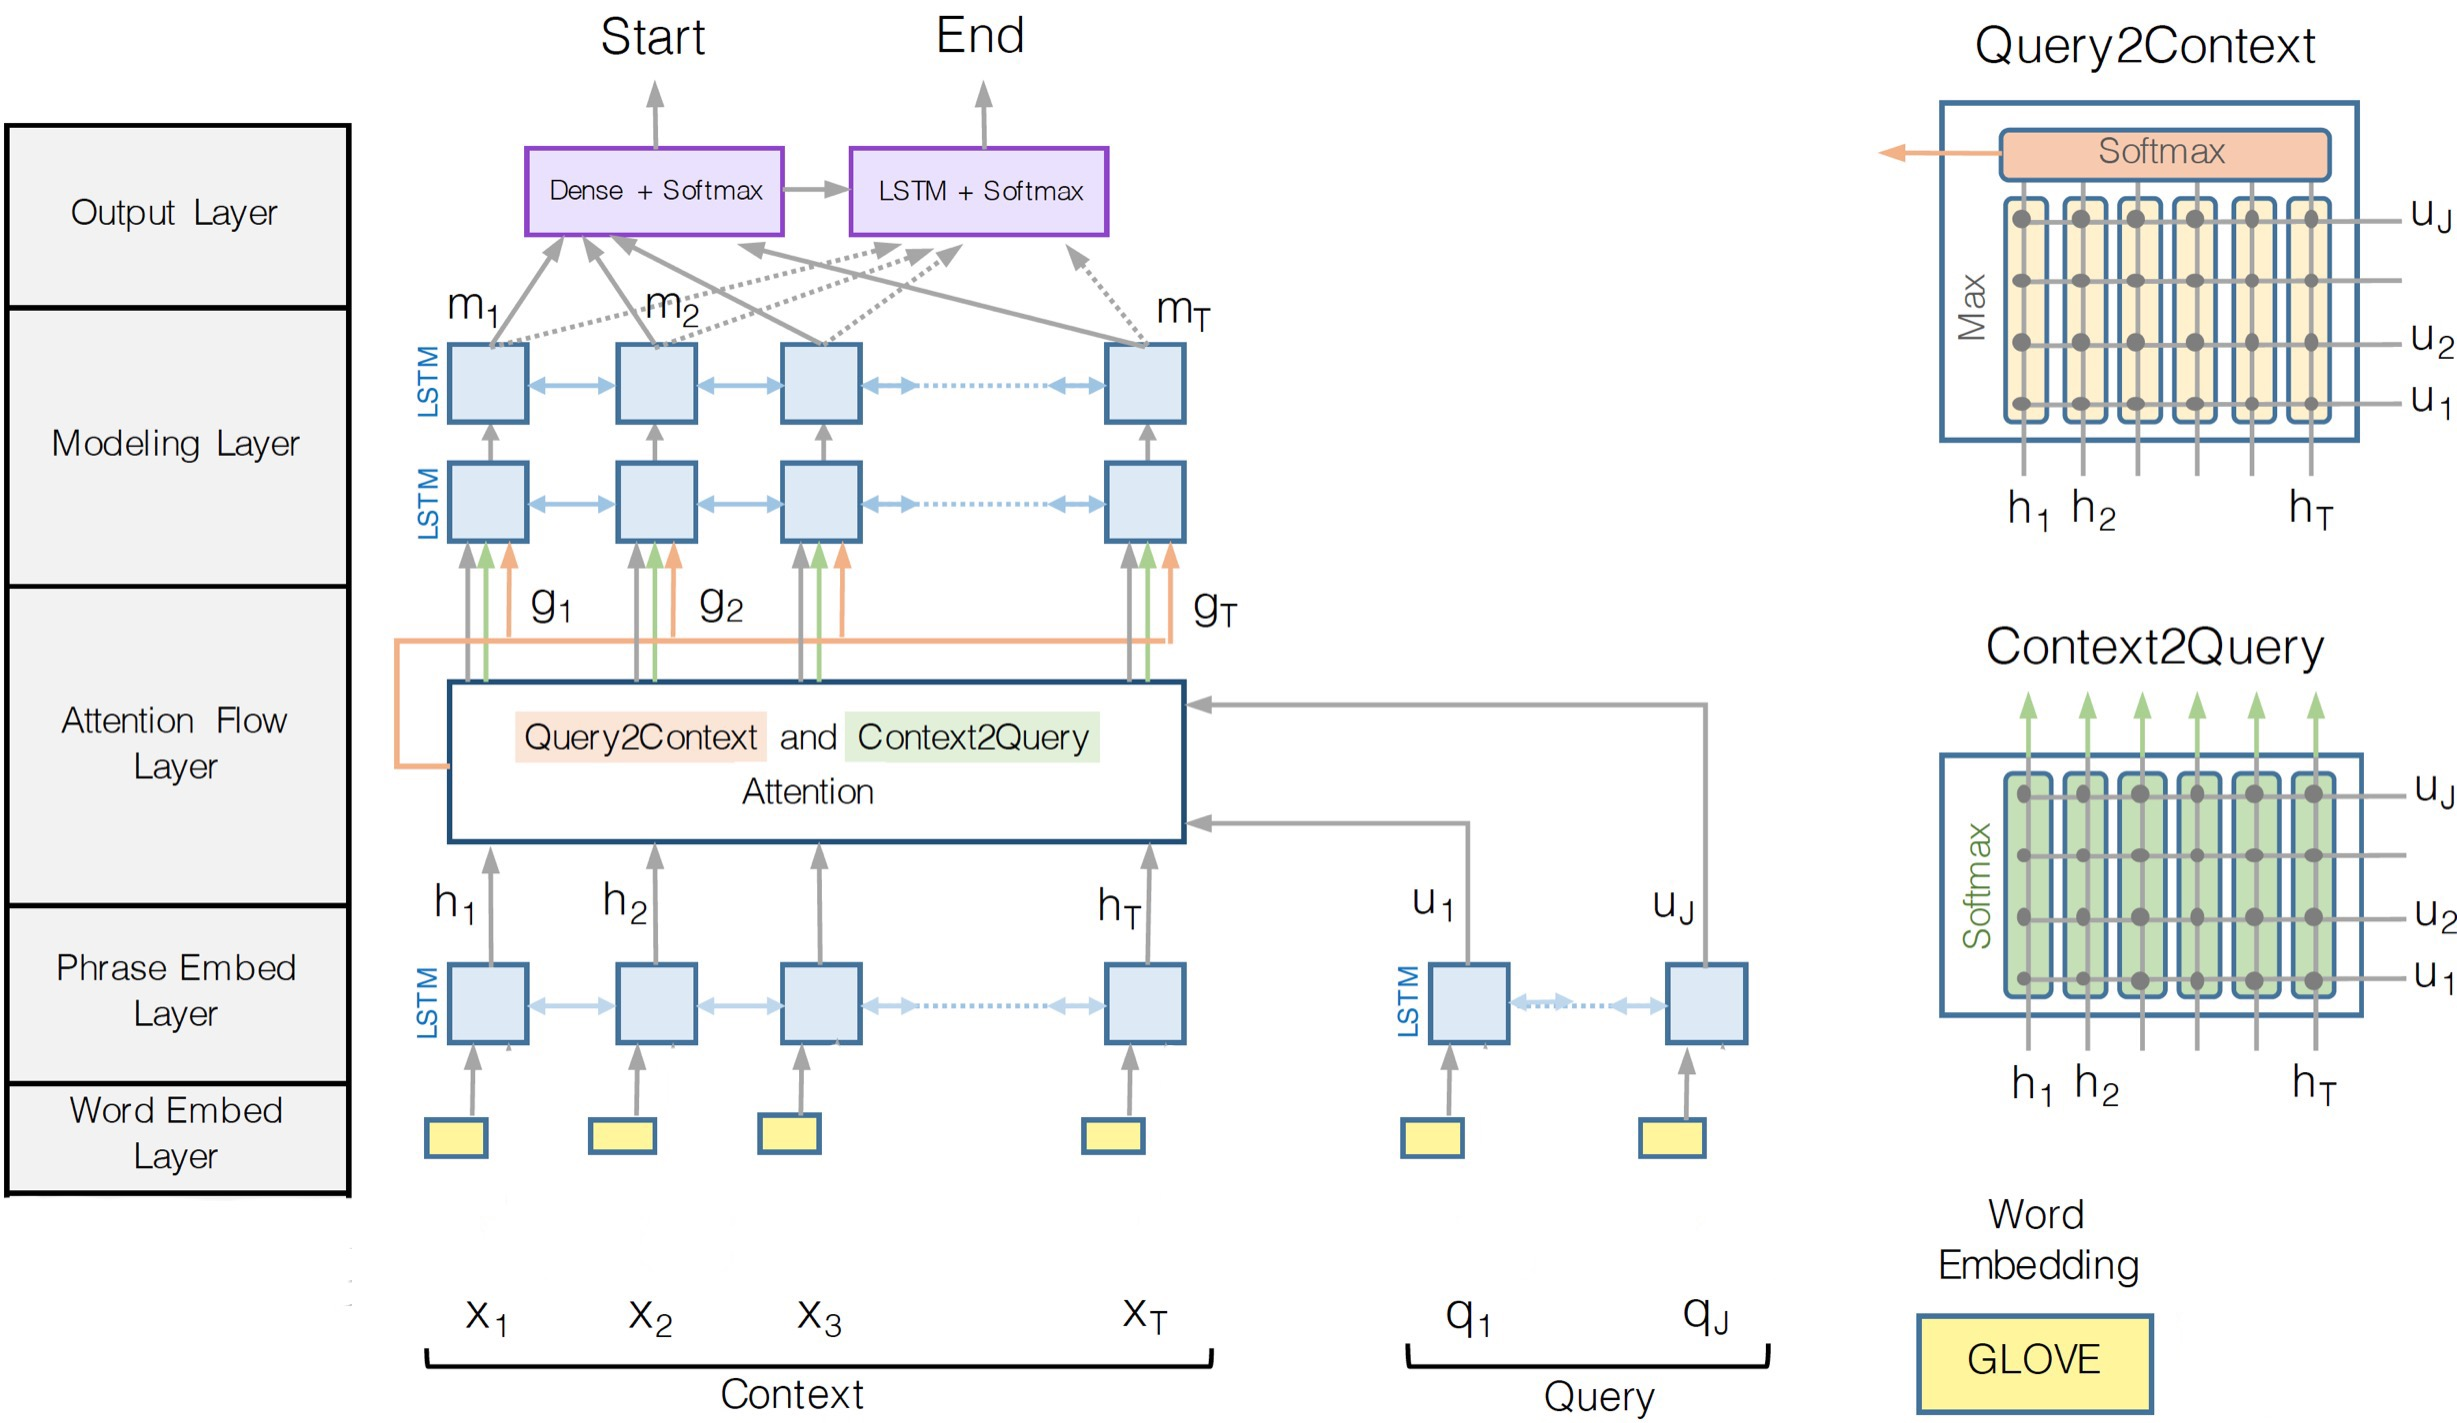

### Word Embed Layer

Given some input word indices (integers that tells you which row (or column) of the embedding matrix contains the words'
embeddings) , the embedding layer performs a GLOVE embedding
lookup to convert the indices into word embeddings $v_1, . . . , v_k \in R^D$  This is done for both the context and the question, producing embeddings $c_1, . . . , c_N ∈ R
^D$ for the context and $q_1, . . . , q_M \in
R^D$ for the question.
In the embedding layer, we further refine the embeddings with the following two step process:

1. We project each embedding to have dimensionality $H$ : Letting $\boldsymbol{W}_{\text {proj }} \in \mathbb{R}^{H \times D}$ be a learnable matrix of parameters, each embedding vector $\boldsymbol{v}_i$ is mapped to $\boldsymbol{h}_i=\boldsymbol{W}_{\text {proj }} \boldsymbol{v}_i \in \mathbb{R}^H$.

2. We apply a [Highway Network](https://arxiv.org/pdf/1505.00387.pdf) to refine the embedded representation. Given an input vector $\boldsymbol{h}_i$, a one-layer highway network computes
$$
\begin{aligned}
\boldsymbol{g} & =\sigma\left(\boldsymbol{W}_g \boldsymbol{h}_i+\boldsymbol{b}_g\right) \in \mathbb{R}^H \\
\boldsymbol{t} & =\operatorname{ReLU}\left(\boldsymbol{W}_t \boldsymbol{h}_i+\boldsymbol{b}_t\right) \in \mathbb{R}^H \\
\boldsymbol{h}_i^{\prime} & =\boldsymbol{g} \odot \boldsymbol{t}+(1-\boldsymbol{g}) \odot \boldsymbol{h}_i \in \mathbb{R}^H
\end{aligned}
$$
where $\boldsymbol{W}_g, \boldsymbol{W}_t \in \mathbb{R}^{H \times H}$ and $\boldsymbol{b}_g, \boldsymbol{b}_t \in \mathbb{R}^H$ are learnable parameters (g is for 'gate' and $\boldsymbol{t}$ is for 'transform'). We use a two-layer highway network to transform each hidden vector $\boldsymbol{h}_i$, which means we apply the above transformation twice, each time using distinct learnable parameters.

In [ ]:
class HighwayEncoder(nn.Module):
    """Encode an input sequence using a highway network.

    Based on the paper:
    "Highway Networks"
    by Rupesh Kumar Srivastava, Klaus Greff, Jürgen Schmidhuber
    (https://arxiv.org/abs/1505.00387).

    Args:
        num_layers (int): Number of layers in the highway encoder.
        hidden_size (int): Size of hidden activations.
    """
    def __init__(self, num_layers, hidden_size):
        super(HighwayEncoder, self).__init__()
        self.transforms = nn.ModuleList([nn.Linear(hidden_size, hidden_size)
                                         for _ in range(num_layers)])
        self.gates = nn.ModuleList([nn.Linear(hidden_size, hidden_size)
                                    for _ in range(num_layers)])

    def forward(self, x):
        for gate, transform in zip(self.gates, self.transforms):
            # Shapes of g, t, and x are all (batch_size, seq_len, hidden_size)
            g = torch.sigmoid(gate(x))
            t = F.relu(transform(x))
            x = g * t + (1 - g) * x

        return x

In [ ]:
class WordEmbedding(nn.Module):
    """Embedding layer used by BiDAF, without the character-level component.

    Args:
        word_vectors (torch.Tensor): Pre-trained word vectors.
        hidden_size (int): Size of hidden activations.
        drop_prob (float): Probability of zero-ing out activations
    """
    def __init__(self, word_vectors, hidden_size, drop_prob):
        super(WordEmbedding, self).__init__()
        self.drop_prob = drop_prob
        self.embed = nn.Embedding.from_pretrained(word_vectors)
        self.proj = nn.Linear(word_vectors.size(1), hidden_size, bias=False)
        self.hwy = HighwayEncoder(2, hidden_size)

    def forward(self, x, hwy=True):
        emb = self.embed(x)   # (batch_size, seq_len, embed_size)
        emb = F.dropout(emb, self.drop_prob, self.training)
        emb = self.proj(emb)  # (batch_size, seq_len, hidden_size)
        if hwy:
            emb = self.hwy(emb)   # (batch_size, seq_len, hidden_size)
        return emb

### RNN Encoder (Phrase Embed Layer)

The encoder layer takes the embedding layer's output as input and uses a bidirectional LSTM [5] to allow the model to incorporate temporal dependencies between timesteps of the embedding layer's output. The encoded output is the RNN's hidden state at each position:
$$
\begin{aligned}
\boldsymbol{h}_{i, \mathrm{fwd}}^{\prime} & =\operatorname{LSTM}\left(\boldsymbol{h}_{i-1}^{\prime}, \boldsymbol{h}_i\right) \in \mathbb{R}^H \\
\boldsymbol{h}_{i, \text { rev }}^{\prime} & =\operatorname{LSTM}\left(\boldsymbol{h}_{i+1}^{\prime}, \boldsymbol{h}_i\right) \in \mathbb{R}^H \\
\boldsymbol{h}_i^{\prime} & =\left[\boldsymbol{h}_{i, \mathrm{fwd}}^{\prime} ; \boldsymbol{h}_{i, \text { rev }}^{\prime}\right] \in \mathbb{R}^{2 H} .
\end{aligned}
$$
Note in particular that $\boldsymbol{h}_i^{\prime}$ is of dimension $2 H$, as it is the concatenation of forward and backward hidden states at timestep $i$.

In [ ]:
class RNNEncoder(nn.Module):
    """General-purpose layer for encoding a sequence using a bidirectional RNN.

    Encoded output is the RNN's hidden state at each position, which
    has shape `(batch_size, seq_len, hidden_size * 2)`.

    Args:
        input_size (int): Size of a single timestep in the input.
        hidden_size (int): Size of the RNN hidden state.
        num_layers (int): Number of layers of RNN cells to use.
        drop_prob (float): Probability of zero-ing out activations.
    """
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers,
                 drop_prob=0.
                 ):
        super(RNNEncoder, self).__init__()
        self.drop_prob = drop_prob
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True,
                           bidirectional=True,
                           dropout=drop_prob if num_layers > 1 else 0.)

    def forward(self, x, lengths):
        # Save original padded length for use by pad_packed_sequence
        orig_len = x.size(1)

        # Sort by length and pack sequence for RNN
        lengths, sort_idx = lengths.sort(0, descending=True)
        x = x[sort_idx]     # (batch_size, seq_len, input_size)
        x = pack_padded_sequence(x, lengths.to('cpu'), batch_first=True)

        # Apply RNN
        x, _ = self.rnn(x)  # (batch_size, seq_len, 2 * hidden_size)

        # Unpack and reverse sort
        x, _ = pad_packed_sequence(x, batch_first=True, total_length=orig_len)
        _, unsort_idx = sort_idx.sort(0)
        x = x[unsort_idx]   # (batch_size, seq_len, 2 * hidden_size)

        # Apply dropout (RNN applies dropout after all but the last layer)
        x = F.dropout(x, self.drop_prob, self.training)

        return x

### BiDAFAttention (Attention Flow Layer)

The Query and Context representations then enter the attention and modeling layers. These layers use several matrix operations to fuse the information contained in the Query and the Context. The output of these steps is another representation of the Context that contains information from the Query. This output is referred as the “Query-aware Context representation.

In [ ]:
class BiDAFAttention(nn.Module):
    """Bidirectional attention originally used by BiDAF.

    Bidirectional attention computes attention in two directions:
    The context attends to the query and the query attends to the context.
    The output of this layer is the concatenation of [context, c2q_attention,
    context * c2q_attention, context * q2c_attention]. This concatenation allows
    the attention vector at each timestep, along with the embeddings from
    previous layers, to flow through the attention layer to the modeling layer.
    The output has shape (batch_size, context_len, 8 * hidden_size).

    Args:
        hidden_size (int): Size of hidden activations.
        drop_prob (float): Probability of zero-ing out activations.
    """
    def __init__(self, hidden_size, drop_prob=0.1):
        super(BiDAFAttention, self).__init__()
        self.drop_prob = drop_prob
        self.c_weight = nn.Parameter(torch.zeros(hidden_size, 1))
        self.q_weight = nn.Parameter(torch.zeros(hidden_size, 1))
        self.cq_weight = nn.Parameter(torch.zeros(1, 1, hidden_size))
        for weight in (self.c_weight, self.q_weight, self.cq_weight):
            nn.init.xavier_uniform_(weight)
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, c, q, c_mask, q_mask):
        batch_size, c_len, _ = c.size()
        q_len = q.size(1)
        s = self.get_similarity_matrix(c, q)        # (batch_size, c_len, q_len)
        c_mask = c_mask.view(batch_size, c_len, 1)  # (batch_size, c_len, 1)
        q_mask = q_mask.view(batch_size, 1, q_len)  # (batch_size, 1, q_len)
        s1 = masked_softmax(s, q_mask, dim=2)       # (batch_size, c_len, q_len)
        s2 = masked_softmax(s, c_mask, dim=1)       # (batch_size, c_len, q_len)

        # (bs, c_len, q_len) x (bs, q_len, hid_size) => (bs, c_len, hid_size)
        a = torch.bmm(s1, q)
        # (bs, c_len, c_len) x (bs, c_len, hid_size) => (bs, c_len, hid_size)
        b = torch.bmm(torch.bmm(s1, s2.transpose(1, 2)), c)

        x = torch.cat([c, a, c * a, c * b], dim=2)  # (bs, c_len, 4 * hid_size)

        return x

    def get_similarity_matrix(self, c, q):
        """Get the "similarity matrix" between context and query (using the
        terminology of the BiDAF paper).

        A naive implementation as described in BiDAF would concatenate the
        three vectors then project the result with a single weight matrix. This
        method is a more memory-efficient implementation of the same operation.

        See Also:
            Equation 1 in https://arxiv.org/abs/1611.01603
        """
        c_len, q_len = c.size(1), q.size(1)
        c = F.dropout(c, self.drop_prob, self.training)  # (bs, c_len, hid_size) #Real shape is torch.Size([1825, 64, 200])
        q = F.dropout(q, self.drop_prob, self.training)  # (bs, q_len, hid_size) #Real shape is torch.Size([11, 64, 200])

        # Shapes: (batch_size, c_len, q_len)
        s0 = torch.matmul(c, self.c_weight).expand([-1, -1, q_len])
        s1 = torch.matmul(q, self.q_weight).transpose(1, 2)\
                                           .expand([-1, c_len, -1])
        s2 = torch.matmul(c * self.cq_weight, q.transpose(1, 2))
        s = s0 + s1 + s2 + self.bias

        return s

### RNNEncoder (Modeling Layer)

The modeling layer is tasked with refining the sequence of vectors after the attention layer. Since the modeling layer comes after the attention layer, the context representations are conditioned on the question by the time they reach the modeling layer. Thus the modeling layer integrates temporal information between context representations conditioned on the question. Similar to the Encoder layer, we use a bidirectional LSTM Given input vectors $\boldsymbol{g}_i \in \mathbb{R}^{8 H}$, the modeling layer computes
$$
\begin{aligned}
\boldsymbol{m}_{i, \mathrm{fwd}} & =\operatorname{LSTM}\left(\boldsymbol{m}_{i-1}, \boldsymbol{g}_i\right) \in \mathbb{R}^H \\
\boldsymbol{m}_{i, \mathrm{rev}} & =\operatorname{LSTM}\left(\boldsymbol{m}_{i+1}, \boldsymbol{g}_i\right) \in \mathbb{R}^H \\
\boldsymbol{m}_i & =\left[\boldsymbol{m}_{i, \mathrm{fwd}} ; \boldsymbol{m}_{i, \mathrm{rev}}\right] \in \mathbb{R}^{2 H} .
\end{aligned}
$$
The modeling layer differs from the encoder layer in that we use a one-layer LSTM in the encoder layer, whereas we use a two-layer LSTM in the modeling layer.

We avoid reporting the layer code since it is equal to the one of the previously presented RNNEncoder

### BiDAFOutput (Output Layer)



The output layer is tasked with producing a vector of probabilities corresponding to each position in the context: $\boldsymbol{p}_{\text {start }}, \boldsymbol{p}_{\text {end }} \in \mathbb{R}^N$. As the notation suggests, $\boldsymbol{p}_{\text {start }}(i)$ is the predicted probability that the answer span starts at position $i$, and similarly $\boldsymbol{p}_{\text {end }}(i)$ is the predicted probability that the answer span ends at position $i$. (See the 'Predicting no-answer' section below for details on no-answer predictions).

Concretely, the output layer takes as input the attention layer outputs $\boldsymbol{g}_1, \ldots, \boldsymbol{g}_N \in \mathbb{R}^{8 H}$ and the modeling layer outputs $\boldsymbol{m}_1, \ldots, \boldsymbol{m}_N \in \mathbb{R}^{2 H}$. The output layer applies a bidirectional LSTM to the modeling layer outputs, producing a vector $\boldsymbol{m}_i^{\prime}$ for each $\boldsymbol{m}_i$ given by
$$
\begin{aligned}
\boldsymbol{m}_{i, \mathrm{fwd}}^{\prime} & =\operatorname{LSTM}\left(\boldsymbol{m}_{i-1}^{\prime}, \boldsymbol{m}_i\right) \in \mathbb{R}^H \\
\boldsymbol{m}_{i, \text { rev }}^{\prime} & =\operatorname{LSTM}\left(\boldsymbol{m}_{i+1}^{\prime}, \boldsymbol{m}_i\right) \in \mathbb{R}^H \\
\boldsymbol{m}_i^{\prime} & =\left[\boldsymbol{m}_{i, \mathrm{fwd}}^{\prime} ; \boldsymbol{m}_{i, \text { rev }}^{\prime}\right] \in \mathbb{R}^{2 H} .
\end{aligned}
$$
Now let $\boldsymbol{G} \in \mathbb{R}^{8 H \times N}$ be the matrix with columns $\boldsymbol{g}_1, \ldots, \boldsymbol{g}_N$, and let $\boldsymbol{M}, \boldsymbol{M}^{\prime} \in \mathbb{R}^{2 H \times N}$ similarly be matrices with columns $\boldsymbol{m}_1 \ldots, \boldsymbol{m}_N$ and $\boldsymbol{m}_1^{\prime}, \ldots, \boldsymbol{m}_N^{\prime}$, respectively. To finally produce $\boldsymbol{p}_{\text {start }}$ and $\boldsymbol{p}_{\text {end }}$, the output layer computes
$$
\boldsymbol{p}_{\text {start }}=\operatorname{softmax}\left(\boldsymbol{W}_{\text {start }}[\boldsymbol{G} ; \boldsymbol{M}]\right) \quad \boldsymbol{p}_{\text {end }}=\operatorname{softmax}\left(\boldsymbol{W}_{\text {end }}\left[\boldsymbol{G} ; \boldsymbol{M}^{\prime}\right]\right),
$$
where $\boldsymbol{W}_{\text {start }}, \boldsymbol{W}_{\text {end }} \in \mathbb{R}^{1 \times 10 H}$ are learnable parameters. In the code, notice that the softmax operation uses the context mask, and we compute all probabilities in log-space for numerical stability and because the F.nll_loss function expects log-probabilities.

In [ ]:
class BiDAFOutput(nn.Module):
    """Output layer used by BiDAF for question answering.

    Computes a linear transformation of the attention and modeling
    outputs, then takes the softmax of the result to get the start pointer.
    A bidirectional LSTM is then applied the modeling output to produce `mod_2`.
    A second linear+softmax of the attention output and `mod_2` is used
    to get the end pointer.

    Args:
        hidden_size (int): Hidden size used in the BiDAF model.
        drop_prob (float): Probability of zero-ing out activations.
    """
    def __init__(self, hidden_size, drop_prob):
        super(BiDAFOutput, self).__init__()
        self.att_linear_1 = nn.Linear(8 * hidden_size, 1)
        self.mod_linear_1 = nn.Linear(2 * hidden_size, 1)

        self.rnn = RNNEncoder(input_size=2 * hidden_size,
                              hidden_size=hidden_size,
                              num_layers=1,
                              drop_prob=drop_prob)

        self.att_linear_2 = nn.Linear(8 * hidden_size, 1)
        self.mod_linear_2 = nn.Linear(2 * hidden_size, 1)

    def forward(self, att, mod, mask):
        # Shapes: (batch_size, seq_len, 1)
        logits_1 = self.att_linear_1(att) + self.mod_linear_1(mod)
        mod_2 = self.rnn(mod, mask.sum(-1))
        logits_2 = self.att_linear_2(att) + self.mod_linear_2(mod_2)

        # Shapes: (batch_size, seq_len)
        log_p1 = masked_softmax(logits_1.squeeze(), mask, log_softmax=True)
        log_p2 = masked_softmax(logits_2.squeeze(), mask, log_softmax=True)

        return log_p1, log_p2

### BiDAF baseline wrapper

Below we report the wrapper class of the baseline BiDAF model, comprising all the presented layers organized according to the original implementation, apart from the character embeddings. Note that, differently from the architecture showed in the picture at the beginning of this section, we employ a single Phrase Embed Layer and a single Word Embed Layer for both the context and the query.

In [ ]:
class BiDAFBase(nn.Module):

    def __init__(self,
                 word_vectors,
                 hidden_size,
                 drop_prob = 0.):

        super(BiDAFBase, self).__init__()

        self.emb = WordEmbedding(word_vectors = word_vectors,
                                     hidden_size = hidden_size,
                                     drop_prob = drop_prob)

        self.enc = RNNEncoder(input_size = i_size,
                              hidden_size = hidden_size,
                              num_layers = 1,
                              drop_prob = drop_prob)

        self.att = BiDAFAttention(hidden_size = 2 * hidden_size,
                                  drop_prob = drop_prob)

        self.mod = RNNEncoder(input_size = 8 * hidden_size,
                              hidden_size = hidden_size,
                              num_layers = 2,
                              drop_prob = drop_prob)

        self.out = BiDAFOutput(hidden_size = hidden_size,
                               drop_prob = drop_prob)

        self.model_type = model_type

    def forward(self,
                cw_idxs,
                qw_idxs):
        # c_mask and q_mask will be boolean tensors with the same shape as cw_idxs and qw_idxs, respectively.
        # The values in these tensors will be True where the corresponding elements in cw_idxs and qw_idxs are
        # non-zero, and False where the corresponding elements in cw_idxs and qw_idxs are zero.
        c_mask = torch.zeros_like(cw_idxs) != cw_idxs
        q_mask = torch.zeros_like(qw_idxs) != qw_idxs
        c_len, q_len = c_mask.sum(-1), q_mask.sum(-1)

        c_emb = self.emb(cw_idxs)  # (batch_size, c_len, hidden_size)
        q_emb = self.emb(qw_idxs)  # (batch_size, q_len, hidden_size)

        c_enc = self.enc(c_emb, c_len)  # (batch_size, c_len, 2 * hidden_size)
        q_enc = self.enc(q_emb, q_len)  # (batch_size, q_len, 2 * hidden_size)

        att = self.att(c_enc, q_enc,
                       c_mask, q_mask)  # (batch_size, c_len, 8 * hidden_size)

        mod = self.mod(att, c_len)  # (batch_size, c_len, 2 * hidden_size)

        out = self.out(att, mod, c_mask)  # 2 tensors, each (batch_size, c_len)

        return out

## BiDAF Original

To enhance the baseline BIDAF model, we introduced the integration of character embeddings into the model architecture.

By considering character-level representations alongside word embeddings, the model gains the ability to leverage fine-grained information encoded in the characters themselves, due to the fact that character-level embeddings allow us to condition on the internal structure of word. This improvement enables the model to capture subtle linguistic patterns, handle out-of-vocabulary words more effectively, and enhance its understanding of the input text.

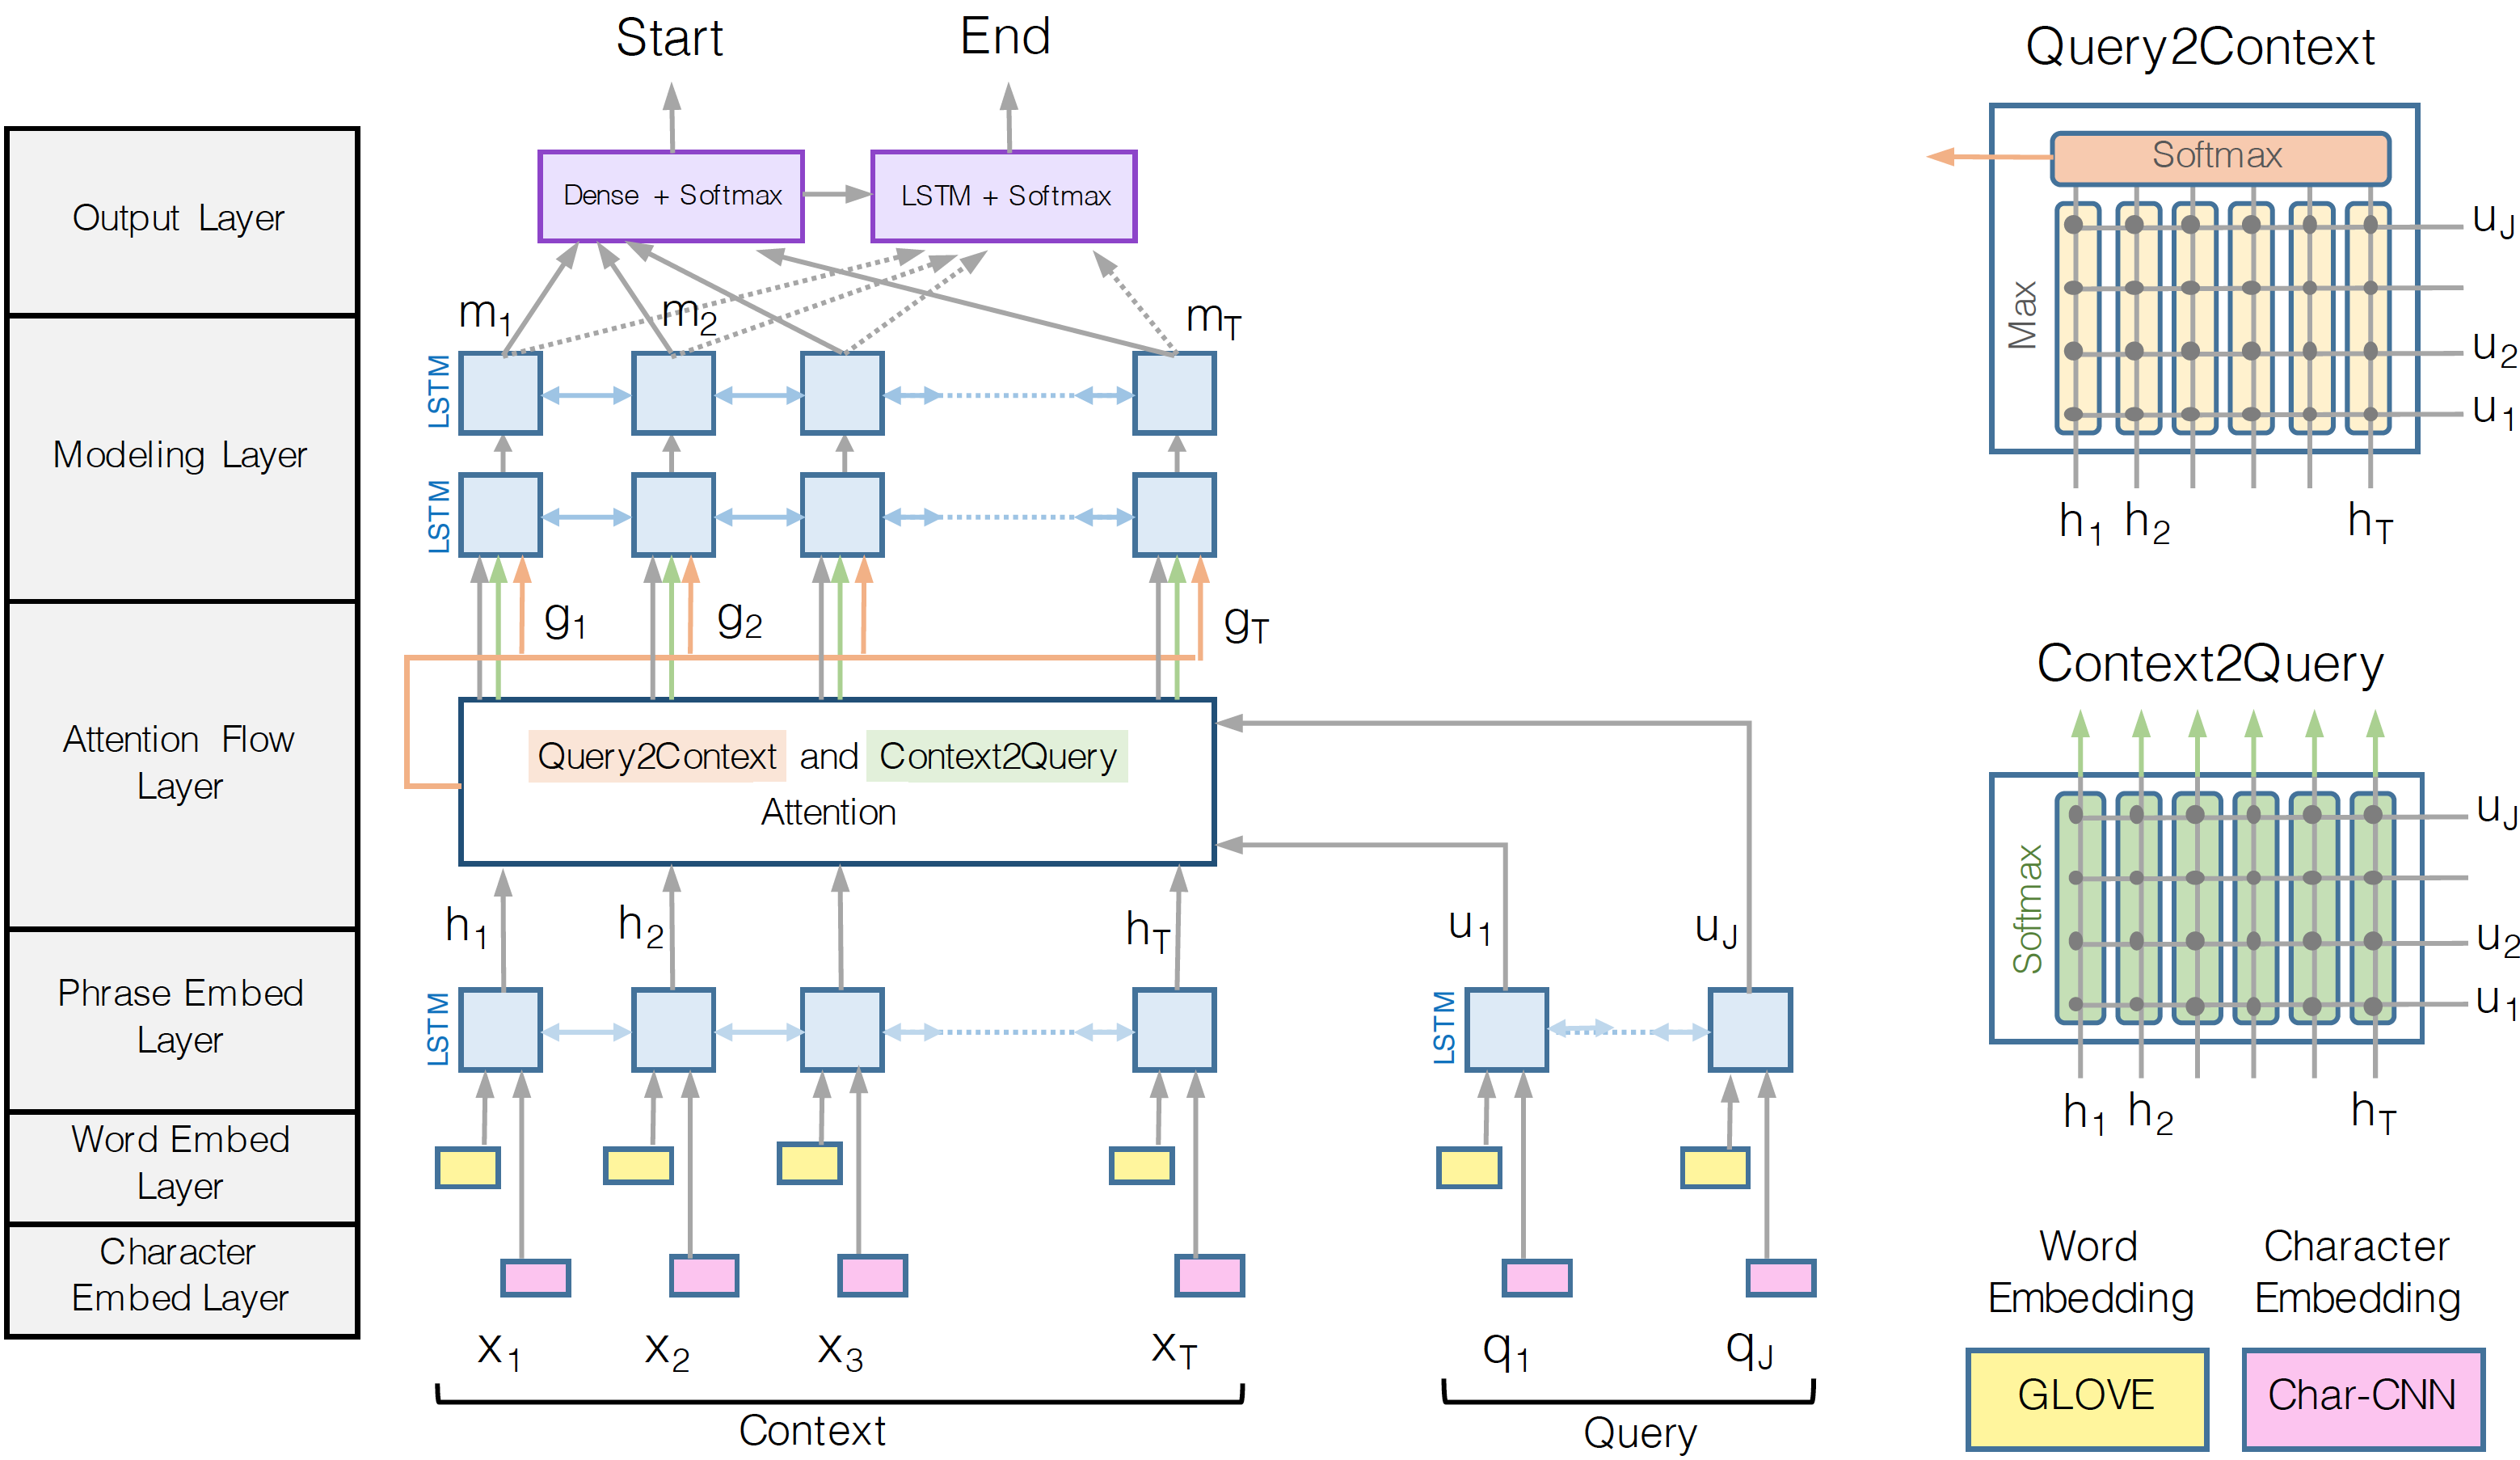

### Character Embedding Layer

We implemented the character embed layer as in the original BiDAF paper, following the original CNN embeding structure in the [paper by Kim](https://aclanthology.org/D14-1181.pdf). Each character are first embeded as a trainable
vector. The character embeddings are convoluted. This convoluted
matrix is maxpooled along the word span in each channel.

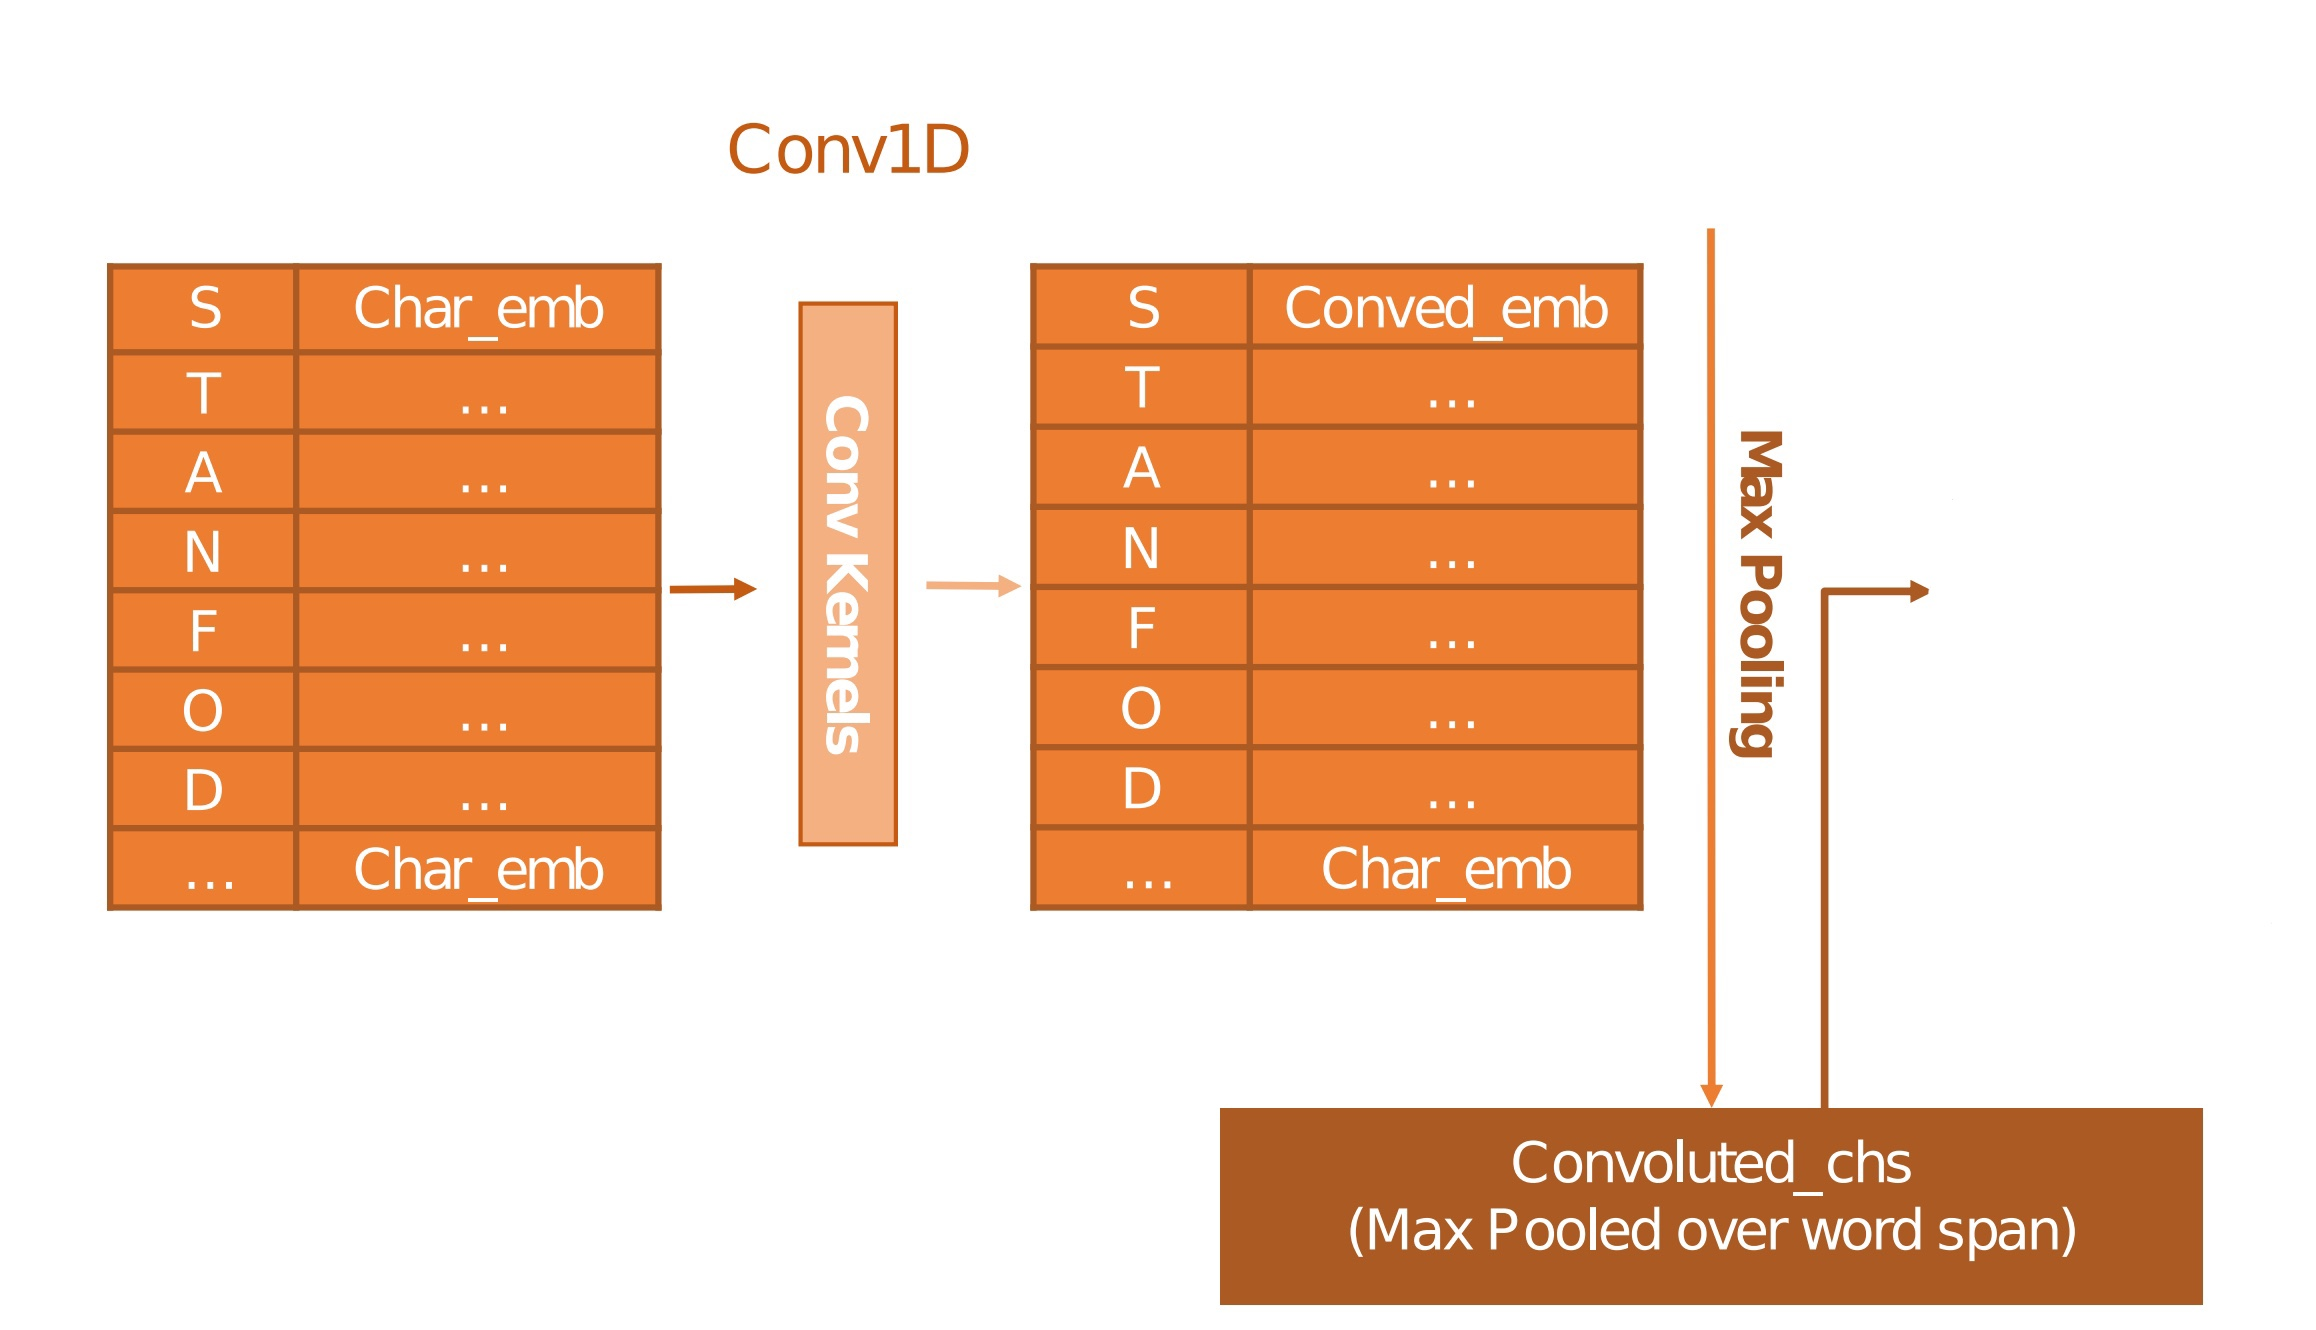

In [ ]:
class CharEmbedding(nn.Module):
    """
    Character-level CNN layer for single character embeddings.

    Args:
        alphabet_size (int): number of characters included in the alphabet.
        embedding_dim (int): the size of the initial (random) embedding vectors for the characters.
        out_embedding_dim (int): the output size for the character embeddings.
        char_channel_width (int): the number of character convoluted by the filter at the time.
        dropout_prob (float, optional, default=0.5): the dropout probability used for this layer.
    """
    def __init__(self, alphabet_size, in_embedding_dim = 8, out_embedding_dim = 100, char_channel_width = 5,
                 dropout_prob = 0.5):
        super(CharEmbedding, self).__init__()
        #store parameters
        self.alphabet_size = alphabet_size
        self.in_embedding_dim = in_embedding_dim
        self.out_embedding_dim = out_embedding_dim
        self.char_channel_width = char_channel_width

        #embedding layer -> associate to each character a random embedding vector
        #of size embedding_dim
        self.char_emb = nn.Embedding(alphabet_size, in_embedding_dim, padding_idx=0)
        nn.init.uniform_(self.char_emb.weight, -0.001, 0.001)

        #convolution layer
        self.char_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=out_embedding_dim, kernel_size=(in_embedding_dim, char_channel_width)),
            nn.ReLU()
        )

        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        """
        Args:
        -----
        batch: (torch.tensor)
            The current batch, tensor of size (batch, seq_len, word_len)
        """
        batch_size = x.size(0)
        # curr_size: (batch, seq_len, word_len)
        x = self.char_emb(x)
        x = self.dropout(x)
        # curr_size: (batch, seq_len, word_len, embedding_dim)
        x = x.transpose(2, 3)
        # curr_size: (batch, seq_len, in_embedding_dim, word_len) -> put character vectors in columns
        x = x.view(-1, self.in_embedding_dim, x.size(3)).unsqueeze(1)
        # curr_size: (batch * seq_len, 1, in_embedding_dim, word_len) -> split by words and not by batch first
        x = self.char_conv(x).squeeze()
        # curr_size: (batch * seq_len, out_embedding_dim, 1, conv_len) -> (batch * seq_len, out_embedding_dim, conv_len)
        x = F.max_pool1d(x, x.size(2)).squeeze()
        # curr_size: (batch * seq_len, _embedding_dim, 1) -> (batch * seq_len, out_embedding_dim)
        x = x.view(batch_size, -1, self.out_embedding_dim)
        # curr_size: (batch, seq_len, char_channel_size)

        return x

The resultant vector is then concatenated with the Glove word vector projected into latent (hidden) space. Afterwards a small highway network generates the word-character embeded latent vector, which is then processed by the RNNEncoder Layer as in the previous model.

In [ ]:
class WCEmbedding(nn.Module):

    def __init__(self, word_vectors, hidden_size, alphabet_size, in_embedding_dim = 8, char_channel_width = 5,
                 drop_prob = 0.5):
        super(WCEmbedding, self).__init__()

        self.char_emb = CharEmbedding(alphabet_size = alphabet_size,
                                       in_embedding_dim = in_embedding_dim,
                                       out_embedding_dim = hidden_size,
                                       char_channel_width = char_channel_width,
                                       dropout_prob = drop_prob
                                       )
        self.word_emb = WordEmbedding(word_vectors=word_vectors,
                                   hidden_size=hidden_size,
                                   drop_prob=drop_prob)

        self.hwy = HighwayEncoder(2, 2*hidden_size)



    def forward(self, x, ch):
        w_emb = self.word_emb(x, hwy=False)
        c_emb = self.char_emb(ch)
        concat_emb = torch.cat((c_emb, w_emb), 2)
        emb = self.hwy(concat_emb)
        return emb

### BiDAF Original wrapper

Below we report the wrapper class of the baseline BiDAF model, comprising all the presented layers organized according to the original implementation, apart from the character embeddings. Note that, differently from the architecture showed in the picture at the beginning of this section, we employ a single Phrase Embed Layer, a single Word Embed Layer and a single Character Embed Layer for both the context and the query.

In [ ]:
class BiDAFOriginal(nn.Module):

    def __init__(self,
                 word_vectors,
                 hidden_size,
                 alphabet_size = None):
        super(BiDAFOriginal, self).__init__()

        self.emb = WCEmbedding(word_vectors = word_vectors,
                                   hidden_size = hidden_size,
                                   alphabet_size = alphabet_size,
                                   in_embedding_dim = char_embed_dim,
                                   char_channel_width = char_channel_width,
                                   drop_prob = drop_prob)

        i_size = 2 * hidden_size # double the hidden size to take into account character embeddings


        self.enc = RNNEncoder(input_size = i_size,
                              hidden_size = hidden_size,
                              num_layers = 1,
                              drop_prob = drop_prob)

        self.att = BiDAFAttention(hidden_size = 2 * hidden_size,
                                  drop_prob = drop_prob)

        self.mod = RNNEncoder(input_size = 8 * hidden_size,
                              hidden_size = hidden_size,
                              num_layers = 2,
                              drop_prob = drop_prob)

        self.out = BiDAFOutput(hidden_size = hidden_size,
                               drop_prob = drop_prob)

        self.model_type = model_type

    def forward(self,
                cw_idxs,
                qw_idxs,
                cc_idxs = None,
                qc_idxs = None):
        # c_mask and q_mask will be boolean tensors with the same shape as cw_idxs and qw_idxs, respectively.
        # The values in these tensors will be True where the corresponding elements in cw_idxs and qw_idxs are
        # non-zero, and False where the corresponding elements in cw_idxs and qw_idxs are zero.
        c_mask = torch.zeros_like(cw_idxs) != cw_idxs
        q_mask = torch.zeros_like(qw_idxs) != qw_idxs
        c_len, q_len = c_mask.sum(-1), q_mask.sum(-1)

        c_emb = self.emb(cw_idxs, cc_idxs)
        q_emb = self.emb(qw_idxs, qc_idxs)


        c_enc = self.enc(c_emb, c_len)  # (batch_size, c_len, 2 * hidden_size)
        q_enc = self.enc(q_emb, q_len)  # (batch_size, q_len, 2 * hidden_size)

        att = self.att(c_enc, q_enc,
                       c_mask, q_mask)  # (batch_size, c_len, 8 * hidden_size)

        mod = self.mod(att, c_len)  # (batch_size, c_len, 2 * hidden_size)

        out = self.out(att, mod, c_mask)  # 2 tensors, each (batch_size, c_len)

        return out

## BiDAF Pro

Starting from the previous improvement of incorporating character embeddings, we further enhanced the BIDAF model by integrating additional contextual information, following the ideas ideas from
[Chen et al](https://aclanthology.org/P17-1171.pdf) through the inclusion of **POS embeddings** and **ENT embeddings**. These embeddings capture syntactic and semantic features of the input text, providing the model with a richer understanding of the language. In addition, we introduced two Iterative Reattention Blocks, following the idea of reattention mechanism from [Hu et al](https://arxiv.org/pdf/1705.02798.pdf) to enable the model to iteratively refine its attention mechanism and gather more precise and relevant information from the context and question.


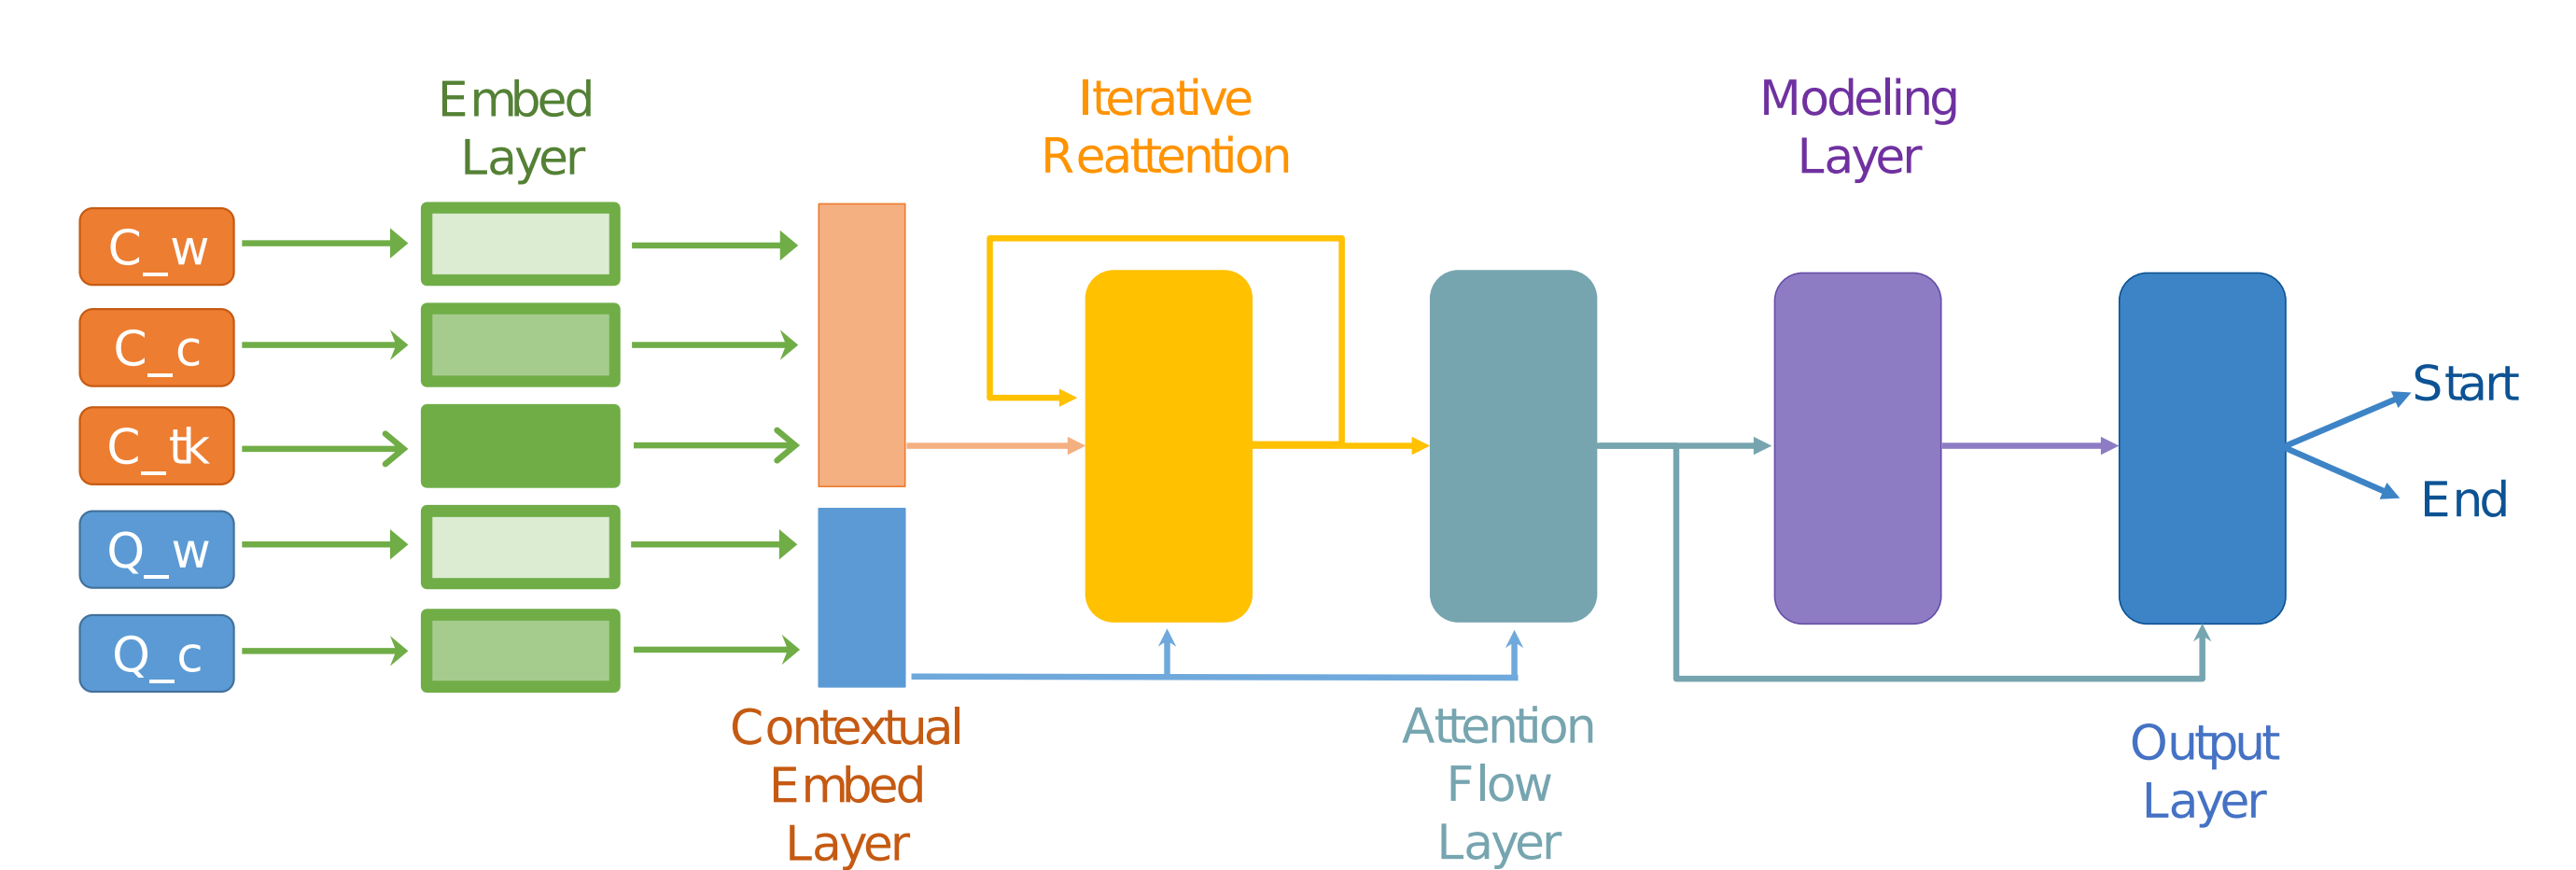

### POS Embedding Layer

The layer receives as input the POS embeddings $p_1, . . . , p_N ∈ R^D$
In the embedding layer, we further refine the embeddings with the following two step process:

1. We project each embedding to have dimensionality $H$ : Letting $\boldsymbol{W}_{\text {proj }} \in \mathbb{R}^{H \times D}$ be a learnable matrix of parameters, each embedding vector $\boldsymbol{v}_i$ is mapped to $\boldsymbol{h}_i=\boldsymbol{W}_{\text {proj }} \boldsymbol{v}_i \in \mathbb{R}^H$.

In [ ]:
class PosEmbedding(nn.Module):
    """Embedding layer used by BiDAF, without the character-level component.

    Word-level embeddings are further refined using a 2-layer Highway Encoder
    (see `HighwayEncoder` class for details).

    Args:
        word_vectors (torch.Tensor): Pre-trained word vectors.
        hidden_size (int): Size of hidden activations.
        drop_prob (float): Probability of zero-ing out activations
    """
    def __init__(self, input_size, hidden_size, drop_prob):
        super(PosEmbedding, self).__init__()
        self.drop_prob = drop_prob
        self.proj = nn.Linear(input_size, hidden_size, bias=False)

    def forward(self, x):
        emb = F.dropout(x, self.drop_prob, self.training)
        emb = self.proj(emb)  # (batch_size, seq_len, hidden_size)
        return emb

Inside the whole "Contextual Embed Layer"" the resultant vector is then concatenated with:

- the Glove word vector projected into latent (hidden) space
- the character embeddings
- the ENT indexes projected into latent (hidden) space

Afterwards a small highway network generates the word-character embeded latent vector, which is then processed by the RNNEncoder Layer as in the previous model.

In [ ]:
class ProEmbedding(nn.Module):

    def __init__(self, word_vectors, hidden_size, alphabet_size, in_embedding_dim = 8, char_channel_width = 5,
                 drop_prob = 0.5):
        super(ProEmbedding, self).__init__()

        self.char_emb = CharEmbedding(alphabet_size = alphabet_size,
                                       in_embedding_dim = in_embedding_dim,
                                       out_embedding_dim = hidden_size,
                                       char_channel_width = char_channel_width,
                                       dropout_prob = drop_prob
                                       )
        self.word_emb = WordEmbedding(word_vectors=word_vectors,
                                   hidden_size=hidden_size,
                                   drop_prob=drop_prob)

        self.pos_emb = PosEmbedding(input_size = word_vectors.size(1),
                                     hidden_size = hidden_size,
                                     drop_prob = drop_prob)

        self.ent_proj = nn.Linear(1, hidden_size, bias=False)

        self.hwy = HighwayEncoder(2, 4*hidden_size)#

    def forward(self, w, ch, pos, ent):
        w_emb = self.word_emb(w, hwy=False)   # (batch_size, seq_len, embed_size)
        c_emb = self.char_emb(ch)
        p_emb = self.pos_emb(pos)
        e_emb = self.ent_proj(ent)
        concat_emb = torch.cat((e_emb, p_emb, c_emb, w_emb),2)
        emb = self.hwy(concat_emb)
        return emb

### Iterative Reattention Block

Besides **Attention Flow Layer**, we also applies iterative reattention blocks to take fully advantage of the inputs which could temporally memorize the previous attention and refine the current attention based on it. As shown in the figure below each **Iterative Reattention Block** is composed by three components. Specifically, given the inputs $C_{\text {align }}^{i-1} \in$ $\mathbb{R}^{T \times 2 d}$ which is also the output from $(i-1)^{t h}$ reattention block where $T$ is the word length of context, and $Q_{e m b} \in \mathbb{R}^{J \times 2 d}$ from Embed Layer for query encoding where $J$ is the word length of query, and $d$ is the hidden size of the model. In the following subsections the subblocks are explained in detail.

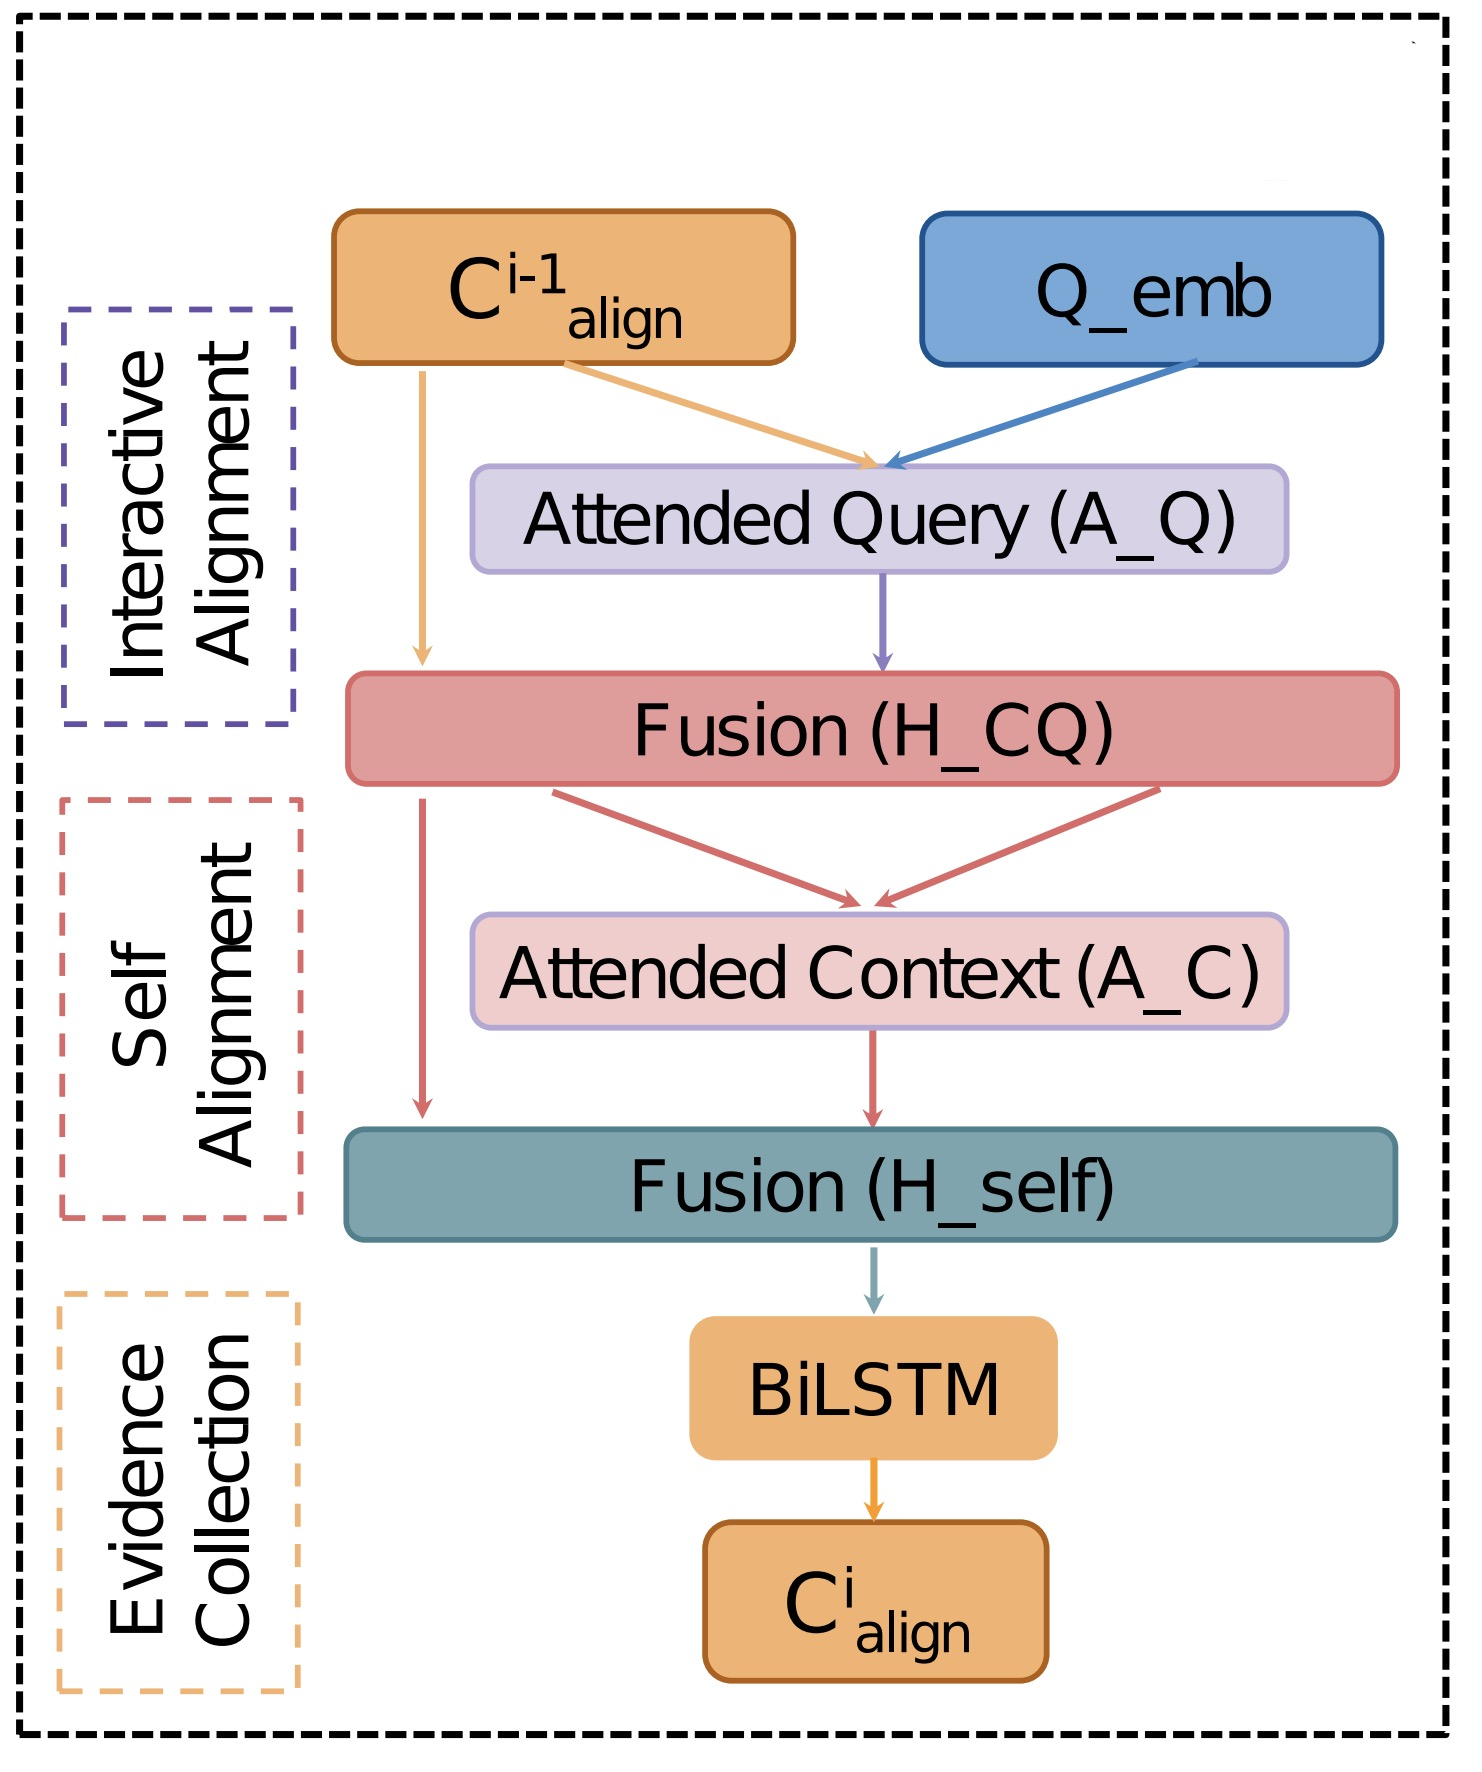

#### Interactive Alignment Layer

In this layer, to get the attended vector of the question into the context, similarity matrix between $C_{a l i g n}^{i-1}$ and $Q_{e m b}$ is firstly calculated as
$$
S_{C Q}^i=Conv_{1d}(C_{a l i g n}^{i-1}) Conv_{1d}(Q_{e m b}^T)
$$
where $S_{C Q}^i \in \mathbb{R}^{T \times J}$ and the attended query vector is then obtained by
$$
A_Q^i=\operatorname{softmax}\left(S_{C Q}^i\right) Q_{e m b}
$$
where $A_Q^i \in \mathbb{R}^{T \times 2 d}$. Then, a fusion function is applied to mix together the information from $C_{a l i g n}^{i-1}$ and the attended query vector $A_Q^i$. Denote the function as $F u \operatorname{sion}(x, y)$, its output as $o$, then we have
$$
\begin{aligned}
g & =\operatorname{ReLU}\left(Conv_{1d}[x ; y ; x \circ y ; x-y]\right) \\
h & =\sigma\left(Conv_{1d}[x ; y ; x \circ y ; x-y]\right) \\
o & =h \circ g+(1-h) \circ x
\end{aligned}
$$
where $\sigma$ indicates sigmoid activation function, $\circ$ denotes the Hadamard product, $h$ serves as a gate to control the contribution from two different vectors. And the output of the fusion function in 1) is denoted as $H_{C Q}^i=F u \operatorname{sion}\left(C_{\text {align }}^{i-1}, A_Q^i\right)$.

In [ ]:
class InteractiveAlignment(nn.Module):
    def __init__(self,
                 input_channels1,
                 input_channels2,
                 output_channels = 128,
                 ):
        super(InteractiveAlignment, self).__init__()
        self.conv_c = nn.Conv1d(input_channels1, output_channels, stride = 1, kernel_size = 1)
        self.conv_q = nn.Conv1d(input_channels2, output_channels, stride = 1, kernel_size = 1)
        self.fusion = FusionBlock(input_channels1 * 4, input_channels1)

    def forward(self,
                c,  # [bs, len_c, dim]
                q):  # [bs, len_q, dim]

        # attention
        c_ = F.relu(self.conv_c(c.permute(0, 2, 1)))  # [bs, dim, len_c]
        c_ = c_.permute(0, 2, 1)  # [bs, len_c, dim]
        q_ = F.relu(self.conv_q(q.permute(0, 2, 1)))  # [bs, dim, len_q]
        q_ = q_.permute(0, 2, 1)  # [bs, len_q, dim]
        S_cq = torch.bmm(c_, q_.permute(0, 2, 1))  # [bs, len_q, len_c]
        A_q = F.softmax(S_cq, dim = 2)  # [bs, len_q, len_c]
        A_q = torch.bmm(A_q, q)  # [bs, len_c, dim]

        # fusion
        return self.fusion(c, A_q)  # [bs, len_c, dim]

In [ ]:
class FusionBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FusionBlock, self).__init__()
        self.conv_x = nn.Conv1d(input_channels, output_channels, stride = 1, kernel_size = 1)
        self.conv_h = nn.Conv1d(input_channels, output_channels, stride = 1, kernel_size = 1)

    def forward(self, u, v):
        # fusion

        uv = torch.cat([u, v, u * v, u - v], dim = -1)
        x = F.relu(self.conv_x(uv.permute(0, 2, 1)))
        x = x.permute(0, 2, 1)
        g = F.sigmoid(self.conv_h(uv.permute(0, 2, 1)))
        g = g.permute(0, 2, 1)
        h = g * x + (1 - g) * u  # [bs, len_c, dim]
        return h

<img src="attachment:image.png" width="400">


#### Self Alignment Layer

In this layer, to obtain the attended vector of the context conditioned on itself, similar as in the Interactive Alignment Layer, a self similarity matrix is computed as
$$
S_{s e l f}^i=Conv_{1d}(H_{C Q}^i)Conv_{1d}(H_{C Q}^{T i})
$$
where $S_{\text {self }}^i \in \mathbb{R}^{T \times T}$ and the attended context vector is then obtained by
$$
A_{\text {self }}^i=\operatorname{softmax}\left(S_{\text {self }}^i\right) H_{C Q}^i
$$
where $A_{\text {self }}^i \in \mathbb{R}^{T \times 2 d}$. Then fusion function is applied again to get the self-aware context vector $H_{\text {self }}^i=F u \operatorname{sion}\left(H_{C Q}^i, A_{\text {self }}^i\right)$.

In [ ]:
class SelfAlignment(nn.Module):
    def __init__(self,
                 input_channels,
                 output_channels = 128,
                 ):
        super(SelfAlignment, self).__init__()
        self.conv_h_1 = nn.Conv1d(input_channels, output_channels, stride = 1, kernel_size = 1)
        self.conv_h_2 = nn.Conv1d(input_channels, output_channels, stride = 1, kernel_size = 1)
        self.fusion = FusionBlock(input_channels * 4, input_channels)

    def forward(self,
                h):
        # attention
        h_1 = F.relu(self.conv_h_1(h.permute(0, 2, 1)))  # [bs, dim, len_h]
        h_1 = h_1.permute(0, 2, 1)  # [bs, len_h, dim]
        h_2 = F.relu(self.conv_h_2(h.permute(0, 2, 1)))  # [bs, dim, len_h]
        h_2 = h_2.permute(0, 2, 1)  # [bs, len_h, dim]

        S = torch.bmm(h_2, h_1.permute(0, 2, 1))  # [bs, len_h, len_h]
        A_s = F.softmax(S, dim = 2)  # [bs, len_h, len_h]
        A_s = torch.bmm(A_s, h)  # [bs, len_h, dim]

        # fusion
        return self.fusion(h, A_s)  # [bs, len_h, dim]

#### Evidence Collection Layer

In this layer, a two-layer bidirectional LSTM is used to aggregate the information from the self-aware context vector $H_{\text {self }}^i$ in the following way:
$$
C_{a l i g n}^i=\operatorname{BiLSTM}\left(H_{\text {self }}^i\right)
$$

In [ ]:
class EvidenceCollection(nn.Module):
    def __init__(self,
                 embedding_dim,
                 hidden_dim,
                 dropout = 0.0):
        super(EvidenceCollection, self).__init__()
        self.BiLSTM = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = 2, dropout = dropout,
                              bidirectional = True)

    def forward(self,
                c  # [bs, len_c, dim]
                ):
        # bilstm wants  (len_c,bs,dim)
        c = c.permute(1, 0, 2)
        output, (hn, cn) = self.BiLSTM(c)  # [len_c, bs, dim]

        return output.permute(1, 0, 2)  # [bs, len_c, dim]

#### Iterative Reattention wrapper

Below we report the wrapper class of the Iterative Reattention Block, comprising all the presented layers organized according to the structure depicted in the picture at the beginning of this section

In [ ]:
class IterativeReattentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim,
                 hidden_dim,
                 dropout = 0.0):
        super(IterativeReattentionBlock, self).__init__()

        self.interactiveAlignment = InteractiveAlignment(2 * embedding_dim, 2 * embedding_dim, hidden_dim)
        self.selfAlignment = SelfAlignment(2 * embedding_dim, hidden_dim)
        self.evidenceCollection = EvidenceCollection(2 * embedding_dim, embedding_dim)

    def forward(self, c, q):
        H_cq = self.interactiveAlignment(c, q)
        H_s = self.selfAlignment(H_cq)
        c_new = self.evidenceCollection(H_s)

        return c_new

### BiDAF Pro wrapper

Below we report the wrapper class of the BiDAF Pro model, comprising all the presented layers organized according to the original implementation, apart from the character embeddings. Note that, differently from the architecture showed in the BiDAF Original section, we employ a single Phrase Embed Layer, a single Word Embed Layer and a single Character Embed Layer for both the context and the query.

In [ ]:
class BiDAFPro(nn.Module):

    def __init__(self,
                 word_vectors,
                 hidden_size,
                 alphabet_size,
                 char_embed_dim,
                 char_channel_width,
                 drop_prob = 0.):
        super(BiDAFPro, self).__init__()

        self.emb = ProEmbedding(word_vectors = word_vectors,
                                    hidden_size = hidden_size,
                                    alphabet_size = alphabet_size,
                                    in_embedding_dim = char_embed_dim,
                                    char_channel_width = char_channel_width,
                                    drop_prob = drop_prob)


        i_size = 4 * hidden_size # larger hidden size to account for char, pos and ent embeddings

        self.enc = RNNEncoder(input_size = i_size,
                              hidden_size = hidden_size,
                              num_layers = 1,
                              drop_prob = drop_prob)

        self.att = BiDAFAttention(hidden_size = 2 * hidden_size,
                                  drop_prob = drop_prob)

        self.irb1 = IterativeReattentionBlock(embedding_dim = hidden_size, hidden_dim = hidden_size)
        self.irb2 = IterativeReattentionBlock(embedding_dim = hidden_size, hidden_dim = hidden_size)

        self.mod = RNNEncoder(input_size = 8 * hidden_size,
                              hidden_size = hidden_size,
                              num_layers = 2,
                              drop_prob = drop_prob)

        self.out = BiDAFOutput(hidden_size = hidden_size,
                               drop_prob = drop_prob)

        self.model_type = model_type

    def forward(self,
                cw_idxs,
                qw_idxs,
                cc_idxs,
                qc_idxs,
                c_pos_vectors,
                q_pos_vectors,
                c_ent_idxs,
                q_ent_idxs):
        # c_mask and q_mask will be boolean tensors with the same shape as cw_idxs and qw_idxs, respectively.
        # The values in these tensors will be True where the corresponding elements in cw_idxs and qw_idxs are
        # non-zero, and False where the corresponding elements in cw_idxs and qw_idxs are zero.
        c_mask = torch.zeros_like(cw_idxs) != cw_idxs
        q_mask = torch.zeros_like(qw_idxs) != qw_idxs
        c_len, q_len = c_mask.sum(-1), q_mask.sum(-1)

        c_ent_idxs, q_ent_idxs = torch.unsqueeze(c_ent_idxs, -1), torch.unsqueeze(q_ent_idxs, -1)

        c_emb = self.emb(cw_idxs, cc_idxs, c_pos_vectors, c_ent_idxs)  # (batch_size, c_len, hidden_size)
        q_emb = self.emb(qw_idxs, qc_idxs, q_pos_vectors, q_ent_idxs)  # (batch_size, q_len, hidden_size)

        c_enc = self.enc(c_emb, c_len)  # (batch_size, c_len, 2 * hidden_size)
        q_enc = self.enc(q_emb, q_len)  # (batch_size, q_len, 2 * hidden_size)

        c_irenc = self.irb1(c_enc, q_enc)
        c_enc = self.irb2(c_irenc, q_enc)

        att = self.att(c_enc, q_enc,
                       c_mask, q_mask)  # (batch_size, c_len, 8 * hidden_size)

        mod = self.mod(att, c_len)  # (batch_size, c_len, 2 * hidden_size)

        out = self.out(att, mod, c_mask)  # 2 tensors, each (batch_size, c_len)

        return out


# 4. Trainings
----
In this section we present the configurations and the results of the trainings of the presented models. We use the NLL as the metric to minimize. Trainings were done on an **NVIDIA Quadro RTX 6000 24GB**


## BiDAF Base

**Training config**


batch_size | best_metric_name | char_channel_width | char_embed_dim | drop_prob | ema_decay | hidden_size | l2_wd | lr | max_grad_norm | model_type | num_epochs | vocab_freq_treshold | vocab_max_size
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
8 | NLL | 5 | 8 | 0.2 | 0.99 | 100 | 0 | 0.1 | 5.0 | base | 30 | 10 | 100000

The Best model was obtained at epoch 20, reached NLL was 03.25.
Each epoch took approximately 15 minutes to complete

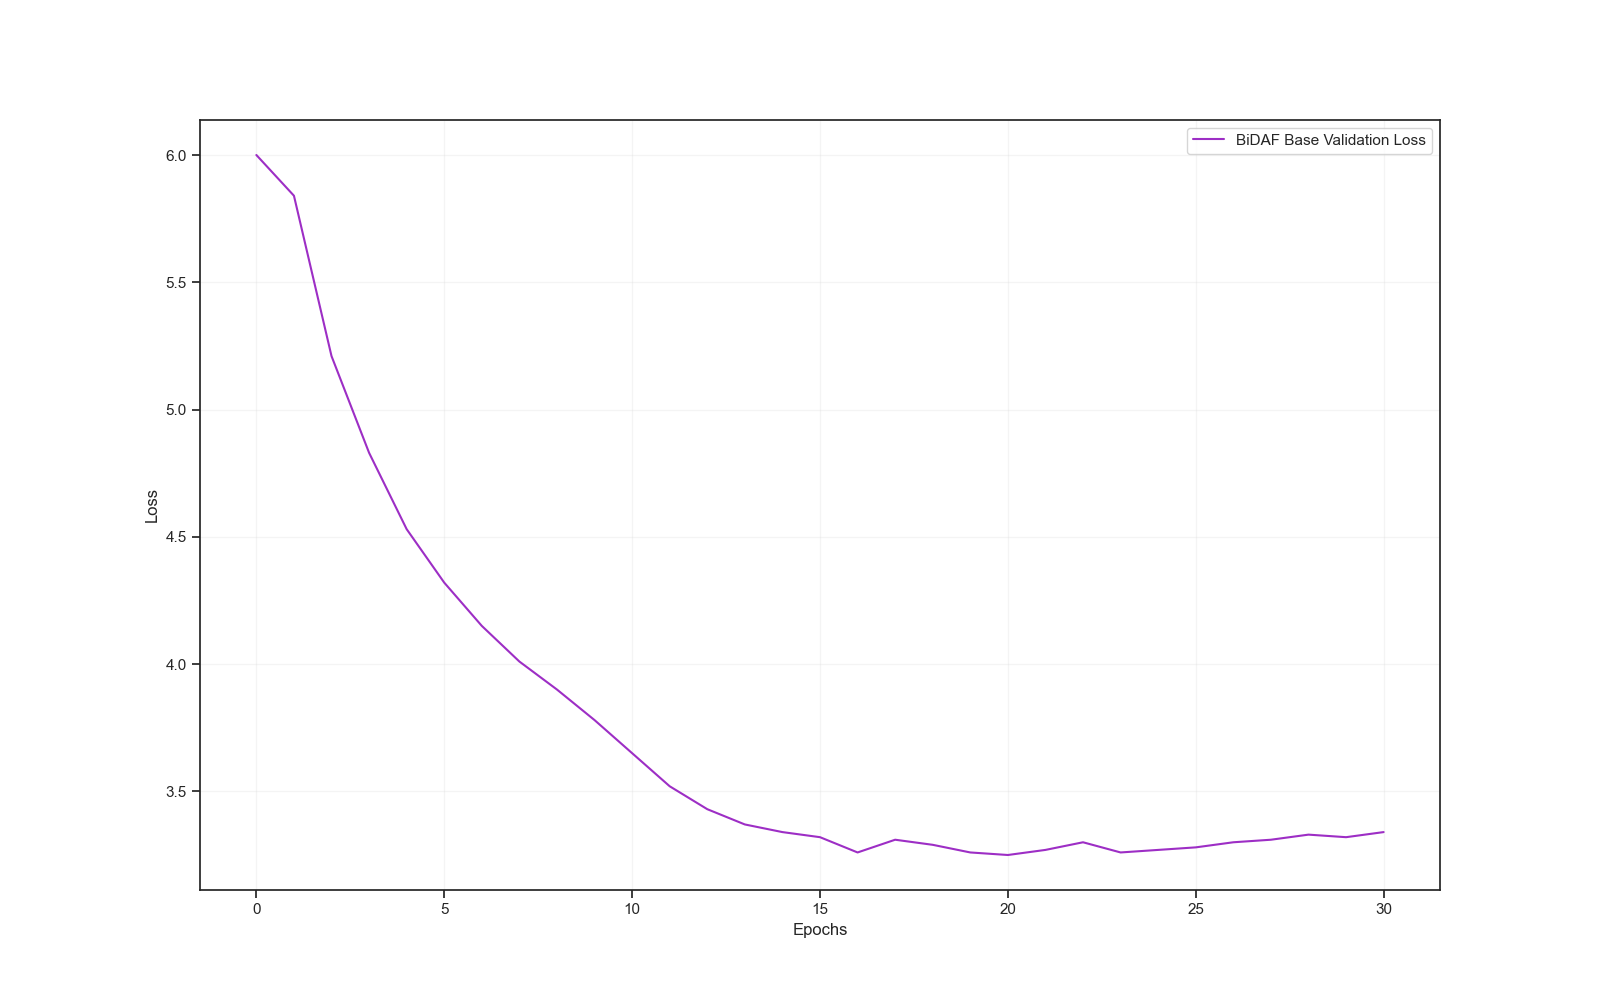

## BiDAF Original

The Best model was obtained at epoch 16, reached NLL was 03.04.
Each epoch took approximately 17 minutes to complete

batch_size | best_metric_name | char_channel_width | char_embed_dim | drop_prob | ema_decay | hidden_size | l2_wd | lr | max_grad_norm | model_type | num_epochs | vocab_freq_treshold | vocab_max_size
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
8 | NLL | 5 | 8 | 0.2 | 0.99 | 100 | 0 | 0.1 | 5.0 | base | 18 | 10 | 100000

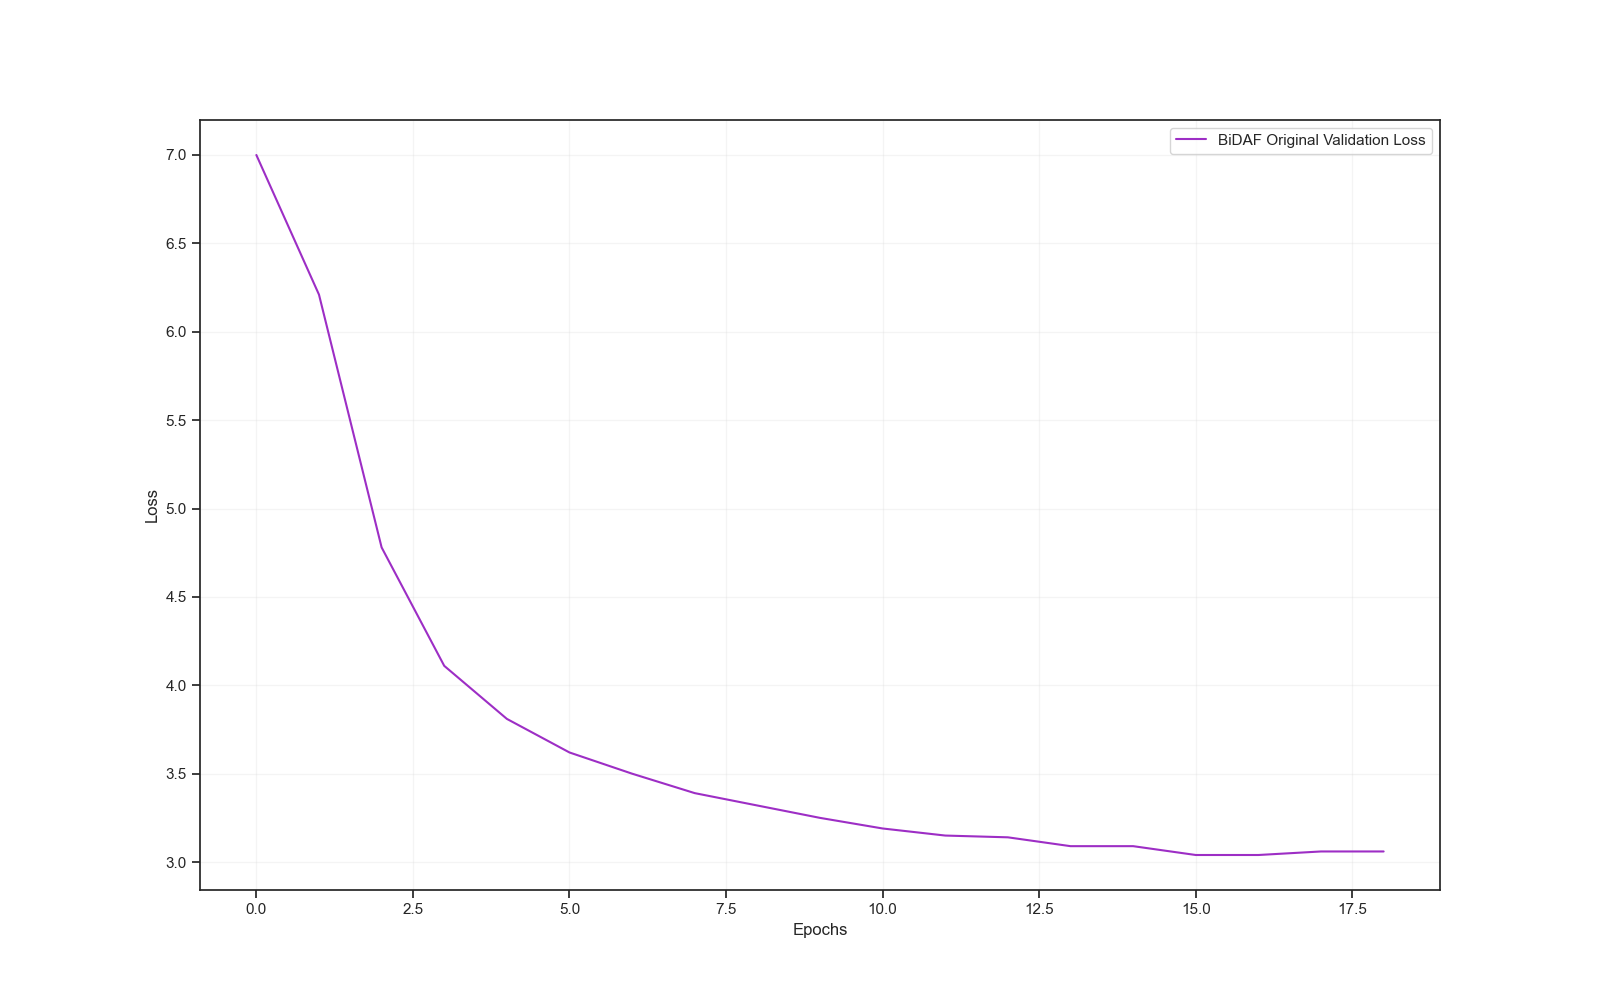

## BiDAF Pro

The Best model was obtained at epoch 16, reached NLL was 03.01.
Each epoch took approximately 25 minutes to complete

batch_size | best_metric_name | char_channel_width | char_embed_dim | drop_prob | ema_decay | hidden_size | l2_wd | lr | max_grad_norm | model_type | num_epochs | vocab_freq_treshold | vocab_max_size
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
8 | NLL | 5 | 8 | 0.2 | 0.99 | 100 | 0 | 0.1 | 5.0 | base | 29 | 10 | 100000

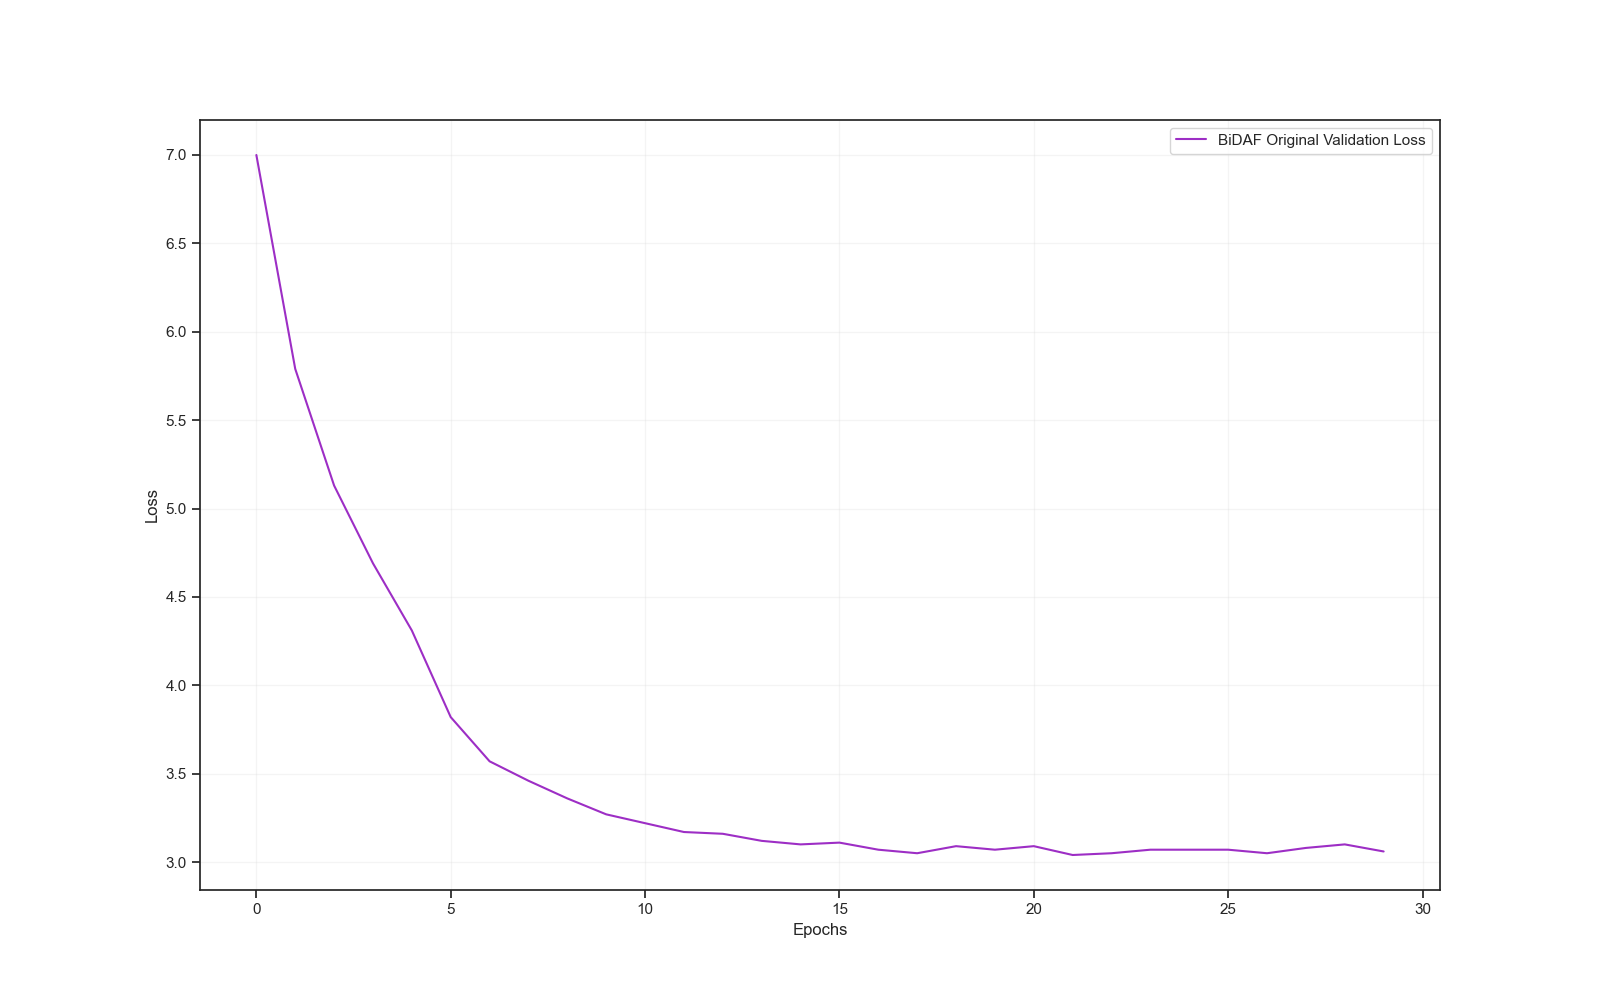

# 5. Results
----


Now, after multiple attempts and trainings we can load our models and evaluate their performances.

## Evaluation utils

The first function required is the one to use the model in inference mode. This function takes as input the data loader defined before and performes inference over the samples without changing model parameters.

The output of this function contains the output of the model, along with some useful information about the sample that will be later used to retrieve the answers.

To be precise:


*   The output of the model are the $\operatorname{log} \boldsymbol{p}_{\text {start }}$ and $\operatorname{log}\boldsymbol{p}_{\text {end }}$ obtained after the log_softmax ;


*   The additional information retrieved concerns the information at character level about the start and end location of each token on the original context and the target token, obtained by mapping the original target start and end location over our tokenization.


In [ ]:
def predict(model, data_loader, device):
  """ Get model predictions.

      Output:
      predictions = [{
                    'id': Sample identifier
                    'start': Individual start logp for each token (1, context_len)
                    'end': Individual end logp for each token (1, context_len)
                    'start_points': start reference in char over the context for each token
                    'end_points': end reference in char over the context for each token
                    'token_target_start': answer start in token based on our tokenization
                    'token_target_end': answer end in token based on our tokenization
                    }, ... ]

  """

  results = []
  model.eval()

  with torch.no_grad():
      eval_bar = tqdm(data_loader)
      for e in eval_bar:
          cw_idxs = e['context'].T
          qw_idxs  = e['question'].T
          cc_idxs  = e['context_chars']
          qc_idxs = e['question_chars']
          id = e['id']
          y1 = e['ans_start']
          y2 = e['ans_end']
          start_points = e['start_points']
          end_points = e['end_points']

          # Setup for forward
          cw_idxs = cw_idxs.to(device)
          qw_idxs = qw_idxs.to(device)
          batch_size = cw_idxs.size(0)

          # Forward
          log_p1, log_p2 = model(cw_idxs, qw_idxs)
          y1, y2 = torch.stack(y1),torch.stack(y2)
          y1, y2 = torch.nan_to_num(y1), torch.nan_to_num(y2)
          y1, y2 = y1.to(device), y2.to(device)
          y1, y2 = y1.to(torch.int64), y2.to(torch.int64)


          for i in range((batch_size)):
            results.append({
                'id':id[i],
                'start':log_p1[i,:],
                'end':log_p2[i,:],
                'start_points': start_points[i], # start reference in char over the context for each token
                'end_points': end_points[i], # end reference in char over the context for each token
                'token_target_start': y1[i]-1, # answer start in token based on our tokenization
                'token_target_end': y2[i]-1 # answer end in token based on our tokenization
                })

          # Log info
          eval_bar.update(1)
          eval_bar.set_postfix(NLL = max(y1))

  return results

Then, we need the post-processing function to extract from the raw predictions the actual predicted span. This includes the following steps:


1.   Process the $\operatorname{log} \boldsymbol{p}_{\text {start }}$ and $\operatorname{log}\boldsymbol{p}_{\text {end }}$ to get the actual probabilities $\boldsymbol{p}_{\text {start }}$ and  $\boldsymbol{p}_{\text {end }}$ ;
2.   The retrieval of the most probable span over the probabilities.



In [ ]:
def process_predictions(predictions, to_numpy=True, max_answer_len = -1):
  """ Process model predictions to get the predicted answer as token span.

      > Input must be a list of N dictionaries in the format:

      predictions = [{
                    'id': Sample identifier
                    'start': Individual start logp for each token (1, context_len)
                    'end': Individual end logp for each token (1, context_len)
                    'start_points': start reference in char over the context for each token
                    'end_points': end reference in char over the context for each token
                    'token_target_start': answer start in token based on our tokenization
                    'token_target_end': answer end in token based on our tokenization
                    }, ... ]

      > Output will be a list of N dictionaries in the format:

      results = [{
                    'id': Sample identifier
                    'start_idxs': start token of the span with max probability
                    'end_idxs': end token of the span with max probability
                    'max_prob': max probability over all valid spans
                    'no_answer_prob': probability to have no answer
                    'start_prob': Individual start probabilities for each token (1, context_len)
                    'end_prob': Individual end probabilities for each token (1, context_len)
                    'start_points': start reference in char over the context for each token
                    'end_points': end reference in char over the context for each token
                    'token_target_start': answer start in token based on our tokenization
                    'token_target_end': answer end in token based on our tokenization
                    }, ... ]
  """

  results = []

  eval_bar = tqdm(predictions)
  for sample in eval_bar:

    start_logp = sample['start']
    end_logp = sample['end']

    if to_numpy:
      start_logp = start_logp.cpu()
      end_logp = end_logp.cpu()
      start_logp = np.array(start_logp)
      end_logp = np.array(end_logp)

    # STEP 1
    start_prob = process_logp(start_logp)
    end_prob = process_logp(end_logp)

    # STEP 2
    joint_probability, start_idxs, end_idxs, max_prob, no_answer_prob = get_answer_span(start_prob, end_prob, max_answer_len)

    results.append({  'id': sample['id'],
                      # 'joint_probability': joint_probability,
                      'start_idxs': start_idxs,
                      'end_idxs': end_idxs,
                      'max_prob': max_prob,
                      'no_answer_prob': no_answer_prob,
                      'start_prob': start_prob,
                      'end_prob': end_prob,
                      # 'start_logp': start_logp,
                      # 'end_logp': end_logp,
                      'start_points': sample['start_points'],
                      'end_points': sample['end_points'],
                      'token_target_start': sample['token_target_start'],
                      'token_target_end': sample['token_target_end']
                  })

  return results

In [ ]:
def process_logp(logp):
  """ logp normalization and exponential application to pass from logp to probabilities

      Input: logp (`np.ndarray`): (1, N)
      Output: probabilities (`np.ndarray`): (1, N)
  """
  # Apply the exponetial
  probabilities = np.exp(logp)

  return probabilities

The 2nd step actually implements the core of the answer retrieval. It takes as input the probability vectors $\boldsymbol{p}_{\text {start }}$ and  $\boldsymbol{p}_{\text {end }}$ and computes the answer span by:


1.   Compute the probability of *impossible answer* as the joint probability $\boldsymbol{p}_{\text {start }}\left(0\right)\cdot \boldsymbol{p}_{\text {end }}\left(0\right)$ (which is how the model has been trained to encode the impossible answers) and removing those 0-index probabilities from the following evaluations.
2.   Compute  the joint probability of start-end pairs, resulting in a matrix of dimension (context_len, context_len) in which the $\left(\boldsymbol{i}, \boldsymbol{j}\right)$ element is the joint probability $\boldsymbol{p}_{\text {start }}\left(\boldsymbol{i}\right)\cdot \boldsymbol{p}_{\text {end }}\left(\boldsymbol{j}\right)$.

3. Define the answer span as the pair that maximizes the joint probability, excluding invalid pairs. A pair is condired invalid if its end precedes its start and if the start-end span is greater than the imposed maximum length of answer.






In [ ]:
def get_answer_span(start, end, max_answer_len = -1):
  """ Retrieve the answer from the probabilities vectors.

      Input:
        start (`np.ndarray`): Individual start probabilities for each token (context_len)
        end (`np.ndarray`): Individual end probabilities for each token (context_len)
        max_answer_len (int): upper limit for number of tokens in the provided answer

      Output:
        joint_probability: joint probability matrix containing at (i,j) the s(i)*e(j)
        start_idxs: start token of the span with max probability
        end_idxs: end token of the span with max probability
        max_prob: max probability over all valid spans
        no_answer_prob: probability of impossible answer

  """
  # Set the maximum length of the answer to the length of the context if no specified
  if max_answer_len < 0: max_answer_len = start.shape[-1]

  # Get the probability to have no answer
  no_answer_prob = start[0] * end[0]

  # Remove the 0-index probability and to exclude it from the max retrieval over the valid tokens
  start[0] = end[0] = 0.0

  # Exapnd start and end as column and row vectors
  #     start:  (context_len, 1)
  #     end:   (1, context_len)
  start = np.expand_dims(start, -1)
  end = np.expand_dims(end, 0)

  # Compute pairwise probabilities
  #     joint_probability: (context_len, context_len)
  joint_probability = np.matmul(start, end)

  # Remove pair with end < start
  joint_probability = np.triu(joint_probability)

  # Remove pair with end - start > max_answer_len
  joint_probability = np.tril(joint_probability, max_answer_len - 1)

  # Take the pair (i, j) that maximizes the joint probabilities and that max value
  max_in_row = np.max(joint_probability, axis=1)
  max_in_col = np.max(joint_probability, axis=0)
  start_idxs = np.argmax(max_in_row)
  end_idxs = np.argmax(max_in_col)
  max_prob = joint_probability[start_idxs, end_idxs]

  if not check_spans(start_idxs, end_idxs):
    print("----- CHECK KO -------")
    print(f"> Start: {start_idxs}")
    print(f"> End: {end_idxs}")
    print(f"> Max: {max_prob}")
    print("Setting start_idxs, end_idxs and max_prob to zero")
    print()
    start_idxs = 0
    end_idxs = 0
    max_prob = 0.0

  return joint_probability, start_idxs, end_idxs, max_prob, no_answer_prob

In [ ]:
def check_spans(start_idxs, end_idxs):
  # Check that all spans are meaningful: start < end
  check1 = np.all(start_idxs <= end_idxs)
  return check1

Finally, we can retrieve the textual answer, given the span. To do so, we will use the references of locations we have previously included in the dataframe and retrieved in the prediction step.

The rationale at this point is the following:

1.   Given the answer span from $\boldsymbol{start} = i$  to  $\boldsymbol{end} = j$ (which means that the model identified as answer from the i-th token to the j-th token on the processed context) retrieve the start of the original word on the original context in characters of the i-th token and the end of the j-th one;
2.   Retrieve the answer, extracting the text included in the identified span from the original context.
3. Compute the score of the prediction as the maximum of the joint probability identified before and as score of the question to be unanswerable the difference between the 0-index pair probability and the score of the prediction. Then consider the sample as predicted as impossible if the unanswerable score is above the score of the prediction. (Zhou et al., Neural Question Answering on SQuAD 2.0)
4. Provide the prediction. If the question is predicted as impossible, consider the retrieved answer as plausible.  




In [ ]:

def retrieve_answers(results, df):
  """ Retrieve textual answers from spans in tokens.

      Input:
      results = [{
                    'id': Sample identifier
                    'start_idxs': start token of the span with max probability
                    'end_idxs': end token of the span with max probability
                    'max_prob': max probability over all valid spans
                    'no_answer_prob': probability to have no answer,
                    'start_points': start reference in char over the context for each token
                    'end_points': end reference in char over the context for each token
                    'token_target_start': answer start in token based on our tokenization
                    'token_target_end': answer end in token based on our tokenization
                    ... }, ... ]

      Output:
      answers = [{
                    'id': Sample identifier
                    'answer_score': score to have predicted correctly the answer
                    'no_answer_score': score to have no answer
                    'predicted_answer': the predicted answer as a string
                    'predicted_start_token_oncontext': start token of the predicted answer's span on tokenized context (-1 if no answer predicted)
                    'predicted_end_token_oncontext': end token of the predicted answer's span on tokenized context(-1 if no answer predicted)
                    'target_start_token_oncontext': start token of the correct answer's span on tokenized context (-1 if impossible answer)
                    'target_end_token_oncontext': end token of the correct answer's span on tokenized context (-1 if impossible answer)
                    'target_answer': correct answer
                    'target_plausible': correct plausible answer
                    }, ... ]
  """

  answers = []

  eval_bar = tqdm(results)
  for sample in eval_bar:

    target_start_token = sample['token_target_start']
    target_end_token = sample['token_target_end']
    predicted_start_token = sample['start_idxs']
    predicted_end_token = sample['end_idxs']
    start_points = sample['start_points']
    end_points = sample['end_points']
    answer_prob = sample['max_prob']
    no_answer_prob = sample['no_answer_prob']
    id = sample['id']


    # TO BE REMOVED
    if predicted_start_token == 0 or predicted_end_token == 0:
      print("\n ----- WARNING: PREDICTED 0 ---- \n")
      print("Sample:    ", sample['id'][0])
      predicted_start_token_oncontext = 0
      predicted_end_token_oncontext = 0

    else:
      # Get the token reference without the 0-index case
      predicted_start_token_oncontext = predicted_start_token-1
      predicted_end_token_oncontext = predicted_end_token-1

      # Get the char reference
      predicted_start_char = start_points[predicted_start_token_oncontext]
      predicted_end_char = end_points[predicted_end_token_oncontext]

    provide_answer = True
    # Inspired by Threshold-based answerable verification (TAV2) - Neural Question Answering on SQuAD 2.0 (Y. Zhou)
    score_no_answer = no_answer_prob - answer_prob
    if score_no_answer > answer_prob: provide_answer = False

    # Retrieve from the dataset the information
    x = df[df['id'] == id]
    context = x['origin_context'].values[0]
    answer = context[predicted_start_char:predicted_end_char+1]

    answers.append({
        'id': id,
        'answer_score': answer_prob,
        'no_answer_score': score_no_answer,
        'predicted_answer': answer,
        'predicted_start_token_oncontext': predicted_start_token_oncontext if provide_answer else -1,
        'predicted_end_token_oncontext': predicted_end_token_oncontext if provide_answer else -1,
        'target_start_token_oncontext': target_start_token,
        'target_end_token_oncontext': target_end_token,
        'target_answer': x['answer'].values[0],
        'target_plausible': x['plausible_answer'].values[0]
    })

  return answers

At this point, we can visualize the results using the following function.

In [ ]:
def get_graphics(sample_result, df):
  """ Get visualizations about model performances.

    Input:
    sample_result = {
                    'id': Sample identifier
                    'start_idxs': start token of the span with max probability
                    'end_idxs': end token of the span with max probability
                    'max_prob': max probability over all valid spans
                    'no_answer_prob': probability to have no answer,
                    'start_prob': Individual start probabilities for each token (1, context_len)
                    'end_prob': Individual end probabilities for each token (1, context_len)
                    'start_points': start reference in char over the context for each token
                    'end_points': end reference in char over the context for each token
                    'token_target_start': answer start in token based on our tokenization
                    'token_target_end': answer end in token based on our tokenization
                    }

  """
  start_scores = sample_result['start_prob'][1:]
  end_scores = sample_result['end_prob'][1:]
  sample_id = sample_result['id']
  tokens = df[df['id']==sample_id]['context'].values[0]
  answer = df[df['id']==sample_id]['answer'].values[0]
  plausible_answer = df[df['id']==sample_id]['plausible_answer'].values[0]
  token_target_start = sample_result['token_target_start'].cpu()
  token_target_end = sample_result['token_target_end'].cpu()

  # Consider probability vectors without padding
  padd = len(start_scores)-len(tokens)
  start_scores = start_scores[:-padd]
  end_scores = end_scores[:-padd]

  # We'll use the tokens as the x-axis labels. In order to do that, they all need
  # to be unique, so we'll add the token index to the end of each one.
  token_labels = []
  for (i, token) in enumerate(tokens):
      token_labels.append('{:} - {:>2}'.format(token, i))

  # Store the tokens and scores in a DataFrame.
  # Each token will have two rows, one for its start score and one for its end
  # score. The "marker" column will differentiate them. A little wacky, I know.
  scores = []
  for (i, token_label) in enumerate(token_labels):

      # Add the token's start score as one row.
      scores.append({'token_label': token_label,
                    'score': start_scores[i],
                    'marker': 'start'
                    })

      # Add  the token's end score as another row.
      scores.append({'token_label': token_label,
                    'score': end_scores[i],
                    'marker': 'end'
                    })

  df = pd.DataFrame(scores)

  # Draw a grouped barplot to show start and end scores for each word.
  # The "hue" parameter is where we tell it which datapoints belong to which
  # of the two series.
  g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                  kind="bar", height=6, aspect=4)

  # Report the textual correct answer
  g.ax.set_title(f"Sample: {sample_id}\nAnswer: {answer}\nPlausible Answer: {plausible_answer}")

  # Create a colored background for the bin
  t_start_pos = token_target_start - 0.5
  t_end_pos = token_target_end + 0.5
  g.ax.axvspan(t_start_pos, t_end_pos, facecolor='green', alpha=0.2)



  # Turn the xlabels vertical.
  g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

  # Turn on the vertical grid to help align words to scores.
  g.ax.grid(True)


Additionally, to evaluate the models using the official function provided by the challenge, we'll need to make the answers in a compliant form. This can be done using the following function.

In [ ]:
def eval_results(answers):
  """ Prepare the results for the official evaluation script (evaluate.py).

  Input:
      answers = [{
                    'id': Sample identifier
                    'answer_score': score to have predicted correctly the answer
                    'no_answer_score': score to have no answer
                    'predicted_answer': the predicted answer as a string
                    'predicted_start_token_oncontext': start token of the predicted answer's span on tokenized context (-1 if no answer predicted)
                    'predicted_end_token_oncontext': end token of the predicted answer's span on tokenized context(-1 if no answer predicted)
                    'target_start_token_oncontext': start token of the correct answer's span on tokenized context (-1 if impossible answer)
                    'target_end_token_oncontext': end token of the correct answer's span on tokenized context (-1 if impossible answer)
                    'target_answer': correct answer
                    'target_plausible': correct plausible answer
                    }, ... ]

  Output:
      answers_eval = { id : predicted_answer  , ...    }
      NB: if the question is predicted as impossible, the answer is ''

  """

  answers_eval = {}

  eval_bar = tqdm(answers)
  for sample in eval_bar:

      id = sample['id']
      score_no_answer = sample['no_answer_score']
      answer_score = sample['answer_score']
      answer = sample['predicted_answer']

      provide_answer = True
      if score_no_answer > answer_score: provide_answer = False

      answers_eval[id] = answer if provide_answer else ''

  return answers_eval

## Load modules and configure the environment

Firstly, some preliminatory steps to set the environment and load our modules containing the functions explained in details above.

In [ ]:
# Insert here the path of the working folder
#os.chdir("/content/drive/MyDrive/NLP-Project/final_code")
os.chdir("/content/drive/MyDrive/POLIMI/NLP/NLP-Project/final_code")

In [ ]:
%load_ext autoreload
%autoreload 2

# Load our modules


import SQuAD_dataset
import utils
import train_utils as train_utils
import evaluation_utils
from BIDAF import BiDAF
# Set the style of the plots
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

### Configure settings

In [ ]:
# 2. SET HERE THE CORRECT CONFIG FILE WRT THE MODEL TO BE TESTED
args = train_utils.get_args('config_settings/config_cluster.json')

In [ ]:
# Set up logging and devices
args.save_dir = train_utils.get_save_dir(args.save_dir[0], args.name, training=True)
log = train_utils.get_logger(args.save_dir[0], args.name)
device, args.gpu_ids = train_utils.get_available_devices()
log.info(f'Args: {json.dumps(vars(args), indent = 4, sort_keys = True)}')
args.batch_size *= max(1, len(args.gpu_ids))

# Set random seed
log.info(f'Using random seed {args.seed}...')
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

# Get saver
saver = train_utils.CheckpointSaver(args.save_dir,
                        max_checkpoints=args.max_checkpoints,
                        metric_name=args.best_metric_name,
                        maximize_metric=args.maximize_metric,
                        log = log)

INFO:test:Args: {
    "batch_size": 64,
    "best_metric_name": "NLL",
    "drop_prob": 0.2,
    "ema_decay": 0.99,
    "eval_steps": 50000,
    "glove_file": "glove.6B.300d.txt",
    "gpu_ids": [
        0
    ],
    "hidden_size": 256,
    "l2_wd": 0,
    "load_path": null,
    "lr": 0.1,
    "max_ans_len": 15,
    "max_checkpoints": 5,
    "max_grad_norm": 5.0,
    "maximize_metric": false,
    "name": "test",
    "num_epochs": 100,
    "num_visuals": 10,
    "num_workers": 4,
    "pin_memory": true,
    "save_dir": [
        "./train/test-02",
        2
    ],
    "seed": 42,
    "shuffle_data": true,
    "test_eval_file": "./data/test_eval.json",
    "train_df_file": "train_data_frame_preprocessed.csv",
    "train_eval_file": "./data/train_eval.json",
    "val_df_file": "val_data_frame_preprocessed.csv",
    "val_eval_file": "./data/val_eval.json",
    "vocab_freq_treshold": 10,
    "vocab_max_size": 100000
}
INFO:test:Using random seed 42...
INFO:test:Saver will minimize NLL...


[05.29.23 06:54:51] Args: {
    "batch_size": 64,
    "best_metric_name": "NLL",
    "drop_prob": 0.2,
    "ema_decay": 0.99,
    "eval_steps": 50000,
    "glove_file": "glove.6B.300d.txt",
    "gpu_ids": [
        0
    ],
    "hidden_size": 256,
    "l2_wd": 0,
    "load_path": null,
    "lr": 0.1,
    "max_ans_len": 15,
    "max_checkpoints": 5,
    "max_grad_norm": 5.0,
    "maximize_metric": false,
    "name": "test",
    "num_epochs": 100,
    "num_visuals": 10,
    "num_workers": 4,
    "pin_memory": true,
    "save_dir": [
        "./train/test-02",
        2
    ],
    "seed": 42,
    "shuffle_data": true,
    "test_eval_file": "./data/test_eval.json",
    "train_df_file": "train_data_frame_preprocessed.csv",
    "train_eval_file": "./data/train_eval.json",
    "val_df_file": "val_data_frame_preprocessed.csv",
    "val_eval_file": "./data/val_eval.json",
    "vocab_freq_treshold": 10,
    "vocab_max_size": 100000
}
[05.29.23 06:54:51] Using random seed 42...
[05.29.23 06:54:51

## Get test data

Now load the dataset retained from the beginning for testing. Then, use the same process employed for the training dataset to prepare data, build the vocabulary, get the data loader and prepare the embedding.

In [ ]:
# 3. SET HERE THE PATH WHERE TO FIND THE TESTING DATA
preprocessed_dev_path = dev_locs.final

In [ ]:
log.info('\nBuilding dataset...\n')

# Load data
test_df = SQuAD_dataset.get_squad_dataframe(preprocessed_dev_path)

# Create vocabulary
all_text = pd.concat([test_df['context'], test_df['question']])
vocab = SQuAD_dataset.Vocabulary()
vocab.build_word_vocabulary(all_text)
vocab.build_char_vocabulary(all_text)

# Clean vocabulary according to input parameters
vocab.reduce_word_vocabulary(args.vocab_freq_treshold, args.vocab_max_size)

In [ ]:
alphabet_size = len(vocab.char_to_idx.keys())

In [ ]:
# Compute the glove indexes
vocab.get_GloVe_indexes(args.glove_file)

# Generate the dataset
test_dataset =  SQuAD_dataset.Validation_Dataset(
    df= test_df,
    vocabulary=vocab,
    glove_file=args.glove_file
)

# Generate Data loader
test_loader = SQuAD_dataset.get_valid_loader(
    dataset = test_dataset,
    batch_size = args.batch_size,
    num_workers = args.num_workers,
    shuffle = args.shuffle_data,
    pin_memory = args.pin_memory
)

# Get embeddings
log.info('\nLoading embeddings...\n')
print(f"Special tokens:  {vocab.special_tokens}")
word_vectors = utils.GloVe_embedding_matrix(
    glove_file = args.glove_file,
    special_tokens = vocab.special_tokens
)

In [ ]:
args.glove_file

In [ ]:
test_df

In [ ]:
def group_dataframe(df):
    # Define the columns to exclude
    exclude_columns = []#'context', 'question'

    # Get the list of columns
    all_columns = df.columns.tolist()

    # Remove the excluded columns from the list
    columns_list = [column for column in all_columns if column not in exclude_columns]

    # Group rows by the 'id' column
    grouped = df.groupby('id')

    # Initialize an empty list to store the grouped data
    grouped_data = []

    # Iterate over the grouped data
    for _, group in grouped:
        # Create a dictionary to store the values of the specified columns
        group_dict = {}

        # Iterate over the columns in the columns_list
        for column in columns_list:
            # Retrieve the values for the current column and add them to the dictionary
            uniques = []
            for x in group[column].tolist():
              if x not in uniques: uniques.append(x)
            if column=='context': uniques = uniques[0]
            group_dict[column] = uniques

        # Append the dictionary to the grouped_data list
        grouped_data.append(group_dict)

    # Create a new dataframe with the grouped data
    result_df = pd.DataFrame(grouped_data)

    result_df.id = result_df.id.apply(lambda x:x[0])

    # Return the resulting dataframe
    return result_df

In [ ]:
test_df_grp = group_dataframe(test_df)

In [ ]:
test_df_grp

## BiDAF without character embedding

Then, get the model to be evaluated. Here we are getting the BiDAF without character embedding.

In [ ]:
# 4. SET HERE
#     THE MODEL TO BE EVALUATED AND ITS HYPERPARAMETERS
test_model = BiDAF(word_vectors = word_vectors,
              hidden_size = 100,
              model_type = 'base')

#     WHERE TO FIND THE BEST TRAINING CHECKPOINT
checkpoint_path = 'models/bidaf_base.pth.tar'

In [ ]:
test_model = torch.nn.DataParallel(test_model, args.gpu_ids)
test_model = test_model.to(device)

loaded_model, step = train_utils.load_model(test_model, checkpoint_path, args.gpu_ids)

In [ ]:
predictions = evaluation_utils.predict(loaded_model, test_loader, device)

  0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(predictions)

16333

In [ ]:
results = evaluation_utils.process_predictions(predictions)

  0%|          | 0/16333 [00:00<?, ?it/s]

In [ ]:
answers = evaluation_utils.retrieve_answers(results, test_df)

  0%|          | 0/16333 [00:00<?, ?it/s]

In [ ]:
ans_eval = evaluation_utils.eval_results(answers)

  0%|          | 0/16333 [00:00<?, ?it/s]

In [ ]:
# 5. SET HERE WHERE TO WRITE THE ANSWERS
answers_towrite_filename = 'results/answers_bidaf_base.json'
results_towrite_filename = 'results/pkl_bidaf_base.plk'

In [ ]:
# Save the data to a file
with open(answers_towrite_filename, "w") as outfile:
  json.dump(ans_eval, outfile)

In [ ]:
# Save the data to a file
with open(results_towrite_filename, "wb") as outfile:
  pickle.dump(results, outfile)

In [ ]:
# Load data from the file
# with open(answers_towrite_filename, "rb") as file: predictions = json.load(file)
#with open(results_towrite_filename, "rb") as file: results = pickle.load(file)

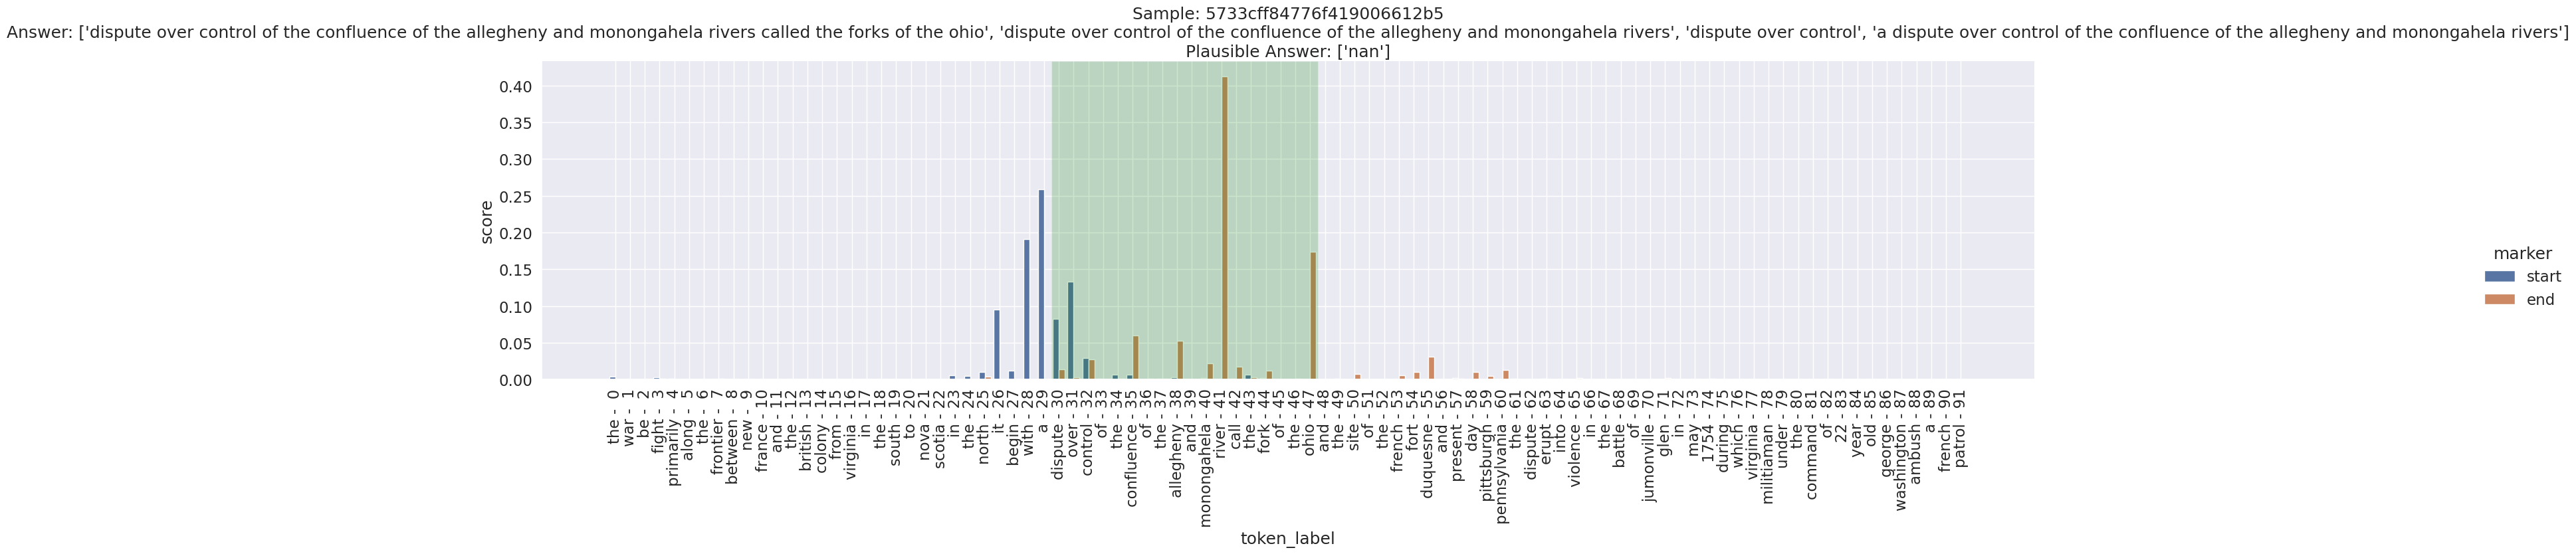

In [ ]:
sample_result = results[1]
evaluation_utils.get_graphics(sample_result, test_df_grp)

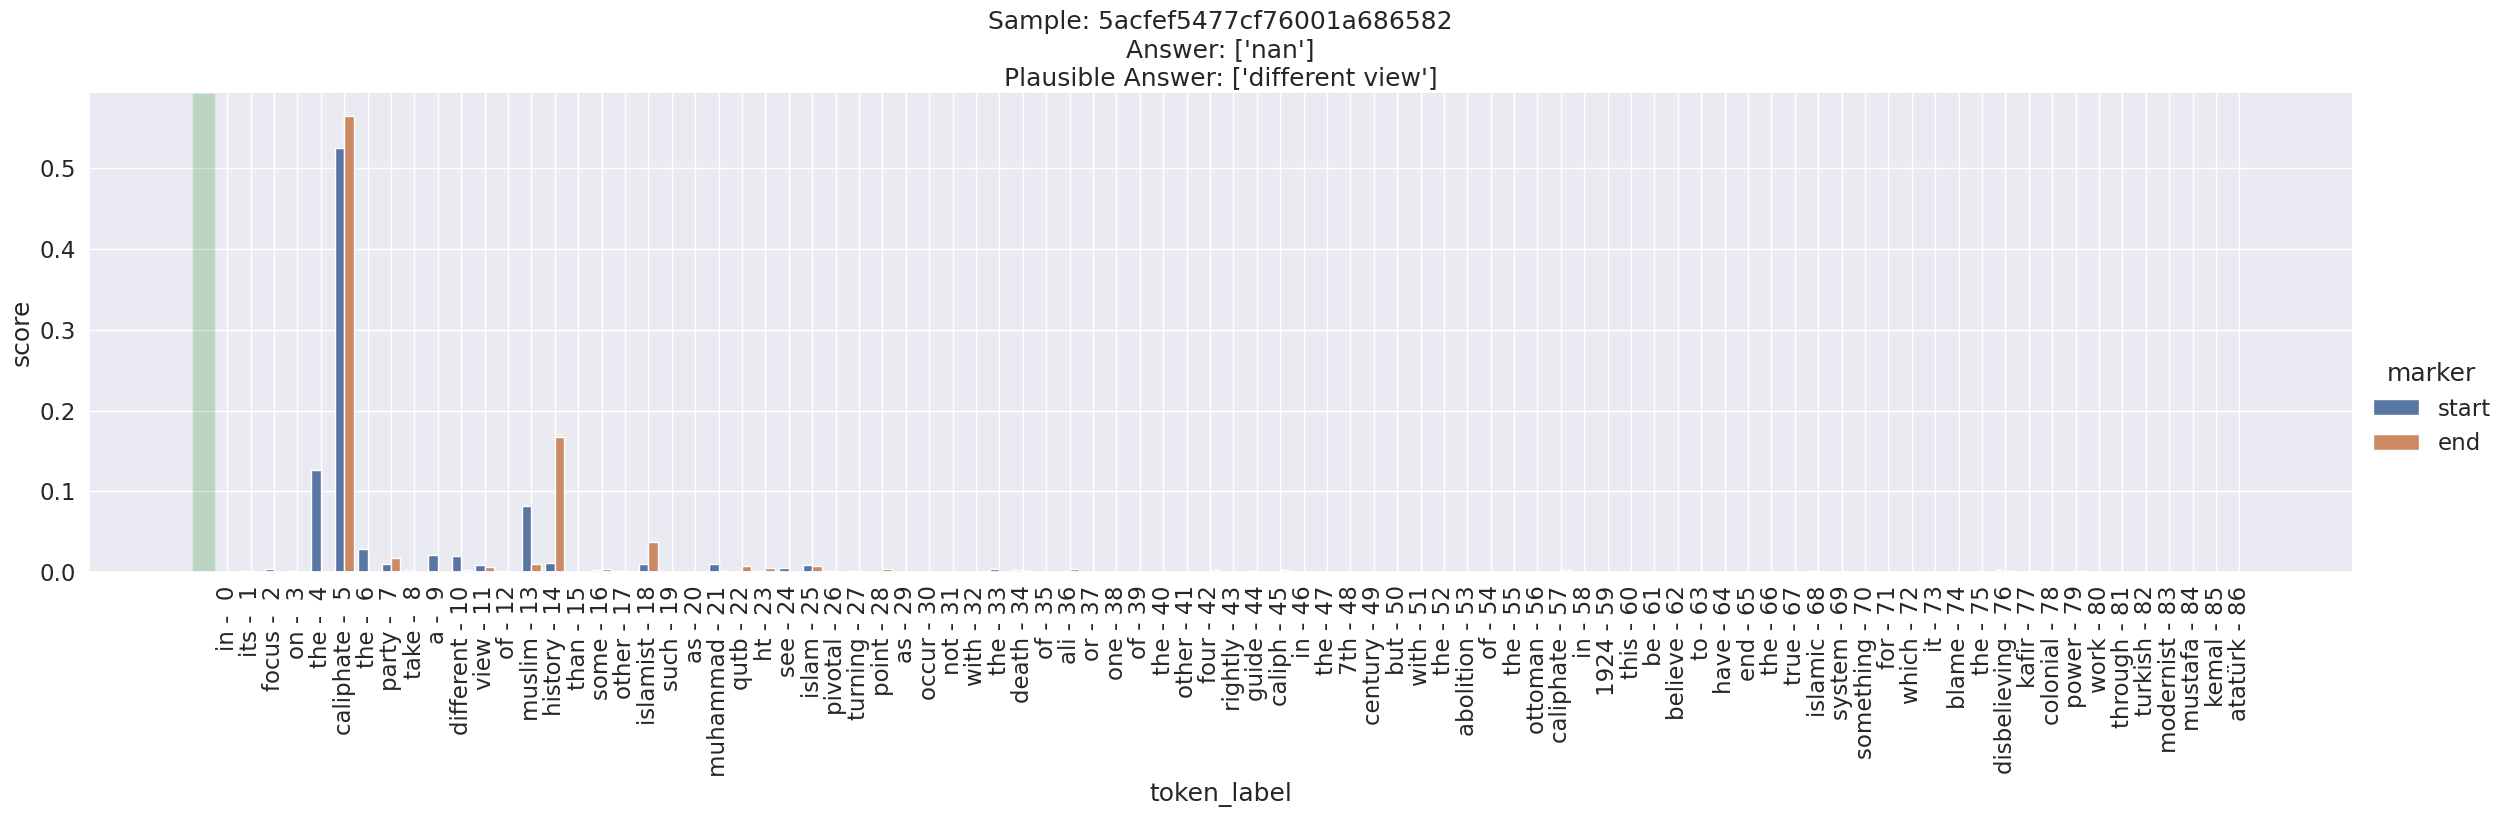

In [ ]:
sample_result = results[10]
evaluation_utils.get_graphics(sample_result, test_df_grp)

In [ ]:
for sample in answers[:20]:
  print(f"Sample:                   {sample['id']}")
  print(f"Predicted token:          ({sample['predicted_start_token_oncontext']}, {sample['predicted_end_token_oncontext']})")
  print(f"Target token:             ({sample['target_start_token_oncontext']}, {sample['target_end_token_oncontext']})")
  print(f"Predicted answer:         {sample['predicted_answer']}")
  print(f"Answer score:             {sample['answer_score']}")
  print(f"No answer score:          {sample['no_answer_score']}")
  print(f"Correct answer:           {sample['target_answer']}")
  print(f"Correct plausible:        {sample['target_plausible']}")
  print()

In [ ]:
!python evaluate.py {"dataset/dev-v2.0.json"} {"results/answers_bidaf_base.json"}

{
  "exact": 46.593110418596815,
  "f1": 51.93552841837668,
  "total": 11873,
  "HasAns_exact": 45.86707152496626,
  "HasAns_f1": 56.56722822391746,
  "HasAns_total": 5928,
  "NoAns_exact": 47.31707317073171,
  "NoAns_f1": 47.31707317073171,
  "NoAns_total": 5945
}


## BiDAF Original

Then, get the model to be evaluated. Here we are getting the BiDAF Original.

In [ ]:
# 4. SET HERE
#     THE MODEL TO BE EVALUATED AND ITS HYPERPARAMETERS
test_model = BiDAF(word_vectors = word_vectors,
              hidden_size = 100,
              model_type = 'original',
              alphabet_size = alphabet_size,
              char_embed_dim = 8,
              char_channel_width = 5,
              drop_prob = 0.)

#     WHERE TO FIND THE BEST TRAINING CHECKPOINT
checkpoint_path = 'models/bidaf_original.pth.tar'

In [ ]:
test_model = torch.nn.DataParallel(test_model, args.gpu_ids)
test_model = test_model.to(device)

loaded_model, step = train_utils.load_model(test_model, checkpoint_path, args.gpu_ids)

Finally, get and analyze the predictions. Note that the predict function presented before has been slightly modified to be compliant with the inputs required by the model.



In [ ]:
predictions = evaluation_utils.predict_original(loaded_model, test_loader, device)

  0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(predictions)

In [ ]:
results = evaluation_utils.process_predictions(predictions)

  0%|          | 0/16333 [00:00<?, ?it/s]

In [ ]:
answers = evaluation_utils.retrieve_answers(results, test_df)

  0%|          | 0/16333 [00:00<?, ?it/s]

In [ ]:
ans_eval = evaluation_utils.eval_results(answers)

  0%|          | 0/16333 [00:00<?, ?it/s]

In [ ]:
# 5. SET HERE WHERE TO WRITE THE ANSWERS
answers_towrite_filename = 'results/answers_bidaf_original.json'
results_towrite_filename = 'results/pkl_bidaf_original.plk'

In [ ]:
# Save the answers to a file
with open(answers_towrite_filename, "w") as outfile:
  json.dump(ans_eval, outfile)

In [ ]:
# Save the data to a file
with open(results_towrite_filename, "wb") as outfile:
  pickle.dump(results, outfile)

In [ ]:
# Load data from the file
# with open(answers_towrite_filename, "rb") as file: predictions = json.load(file)
#with open(results_towrite_filename, "rb") as file: results = pickle.load(file)

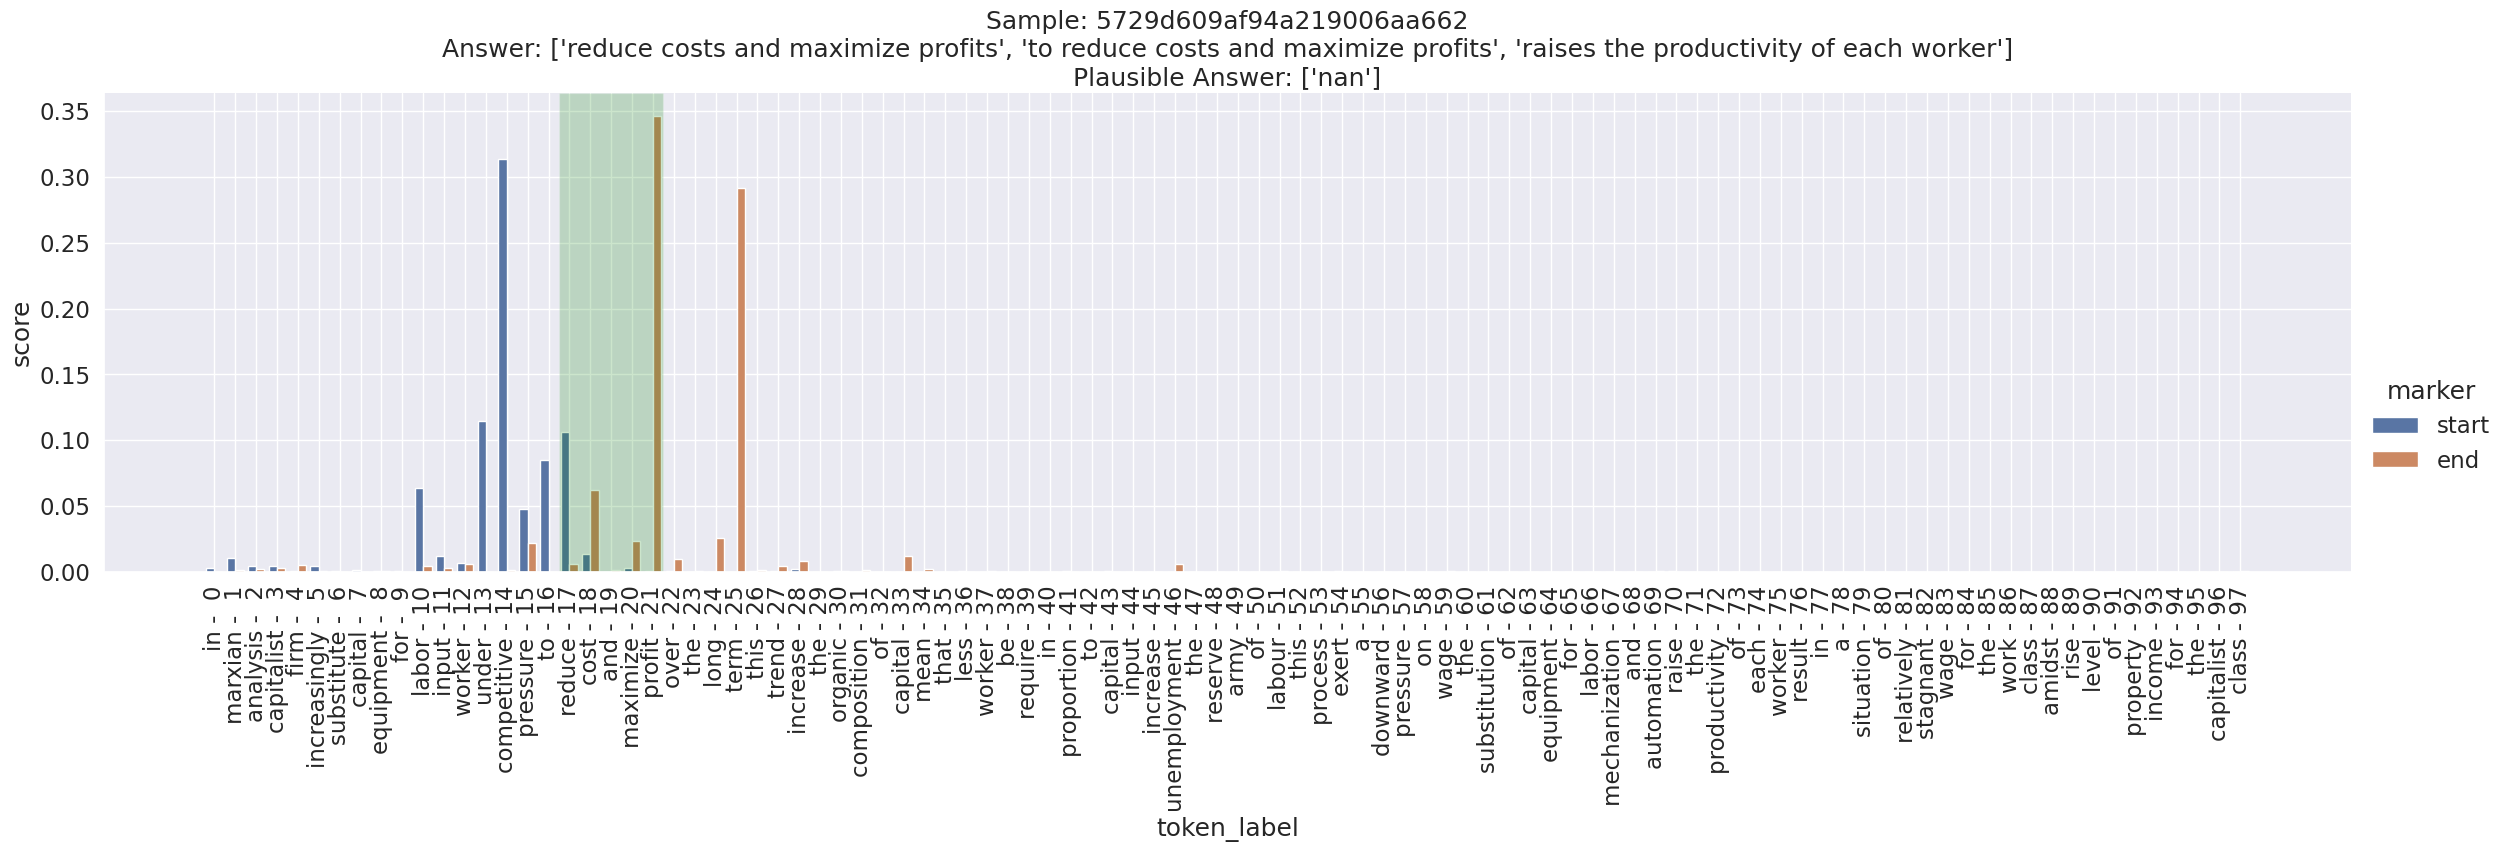

In [ ]:
sample_result = results[1]
evaluation_utils.get_graphics(sample_result, test_df_grp)

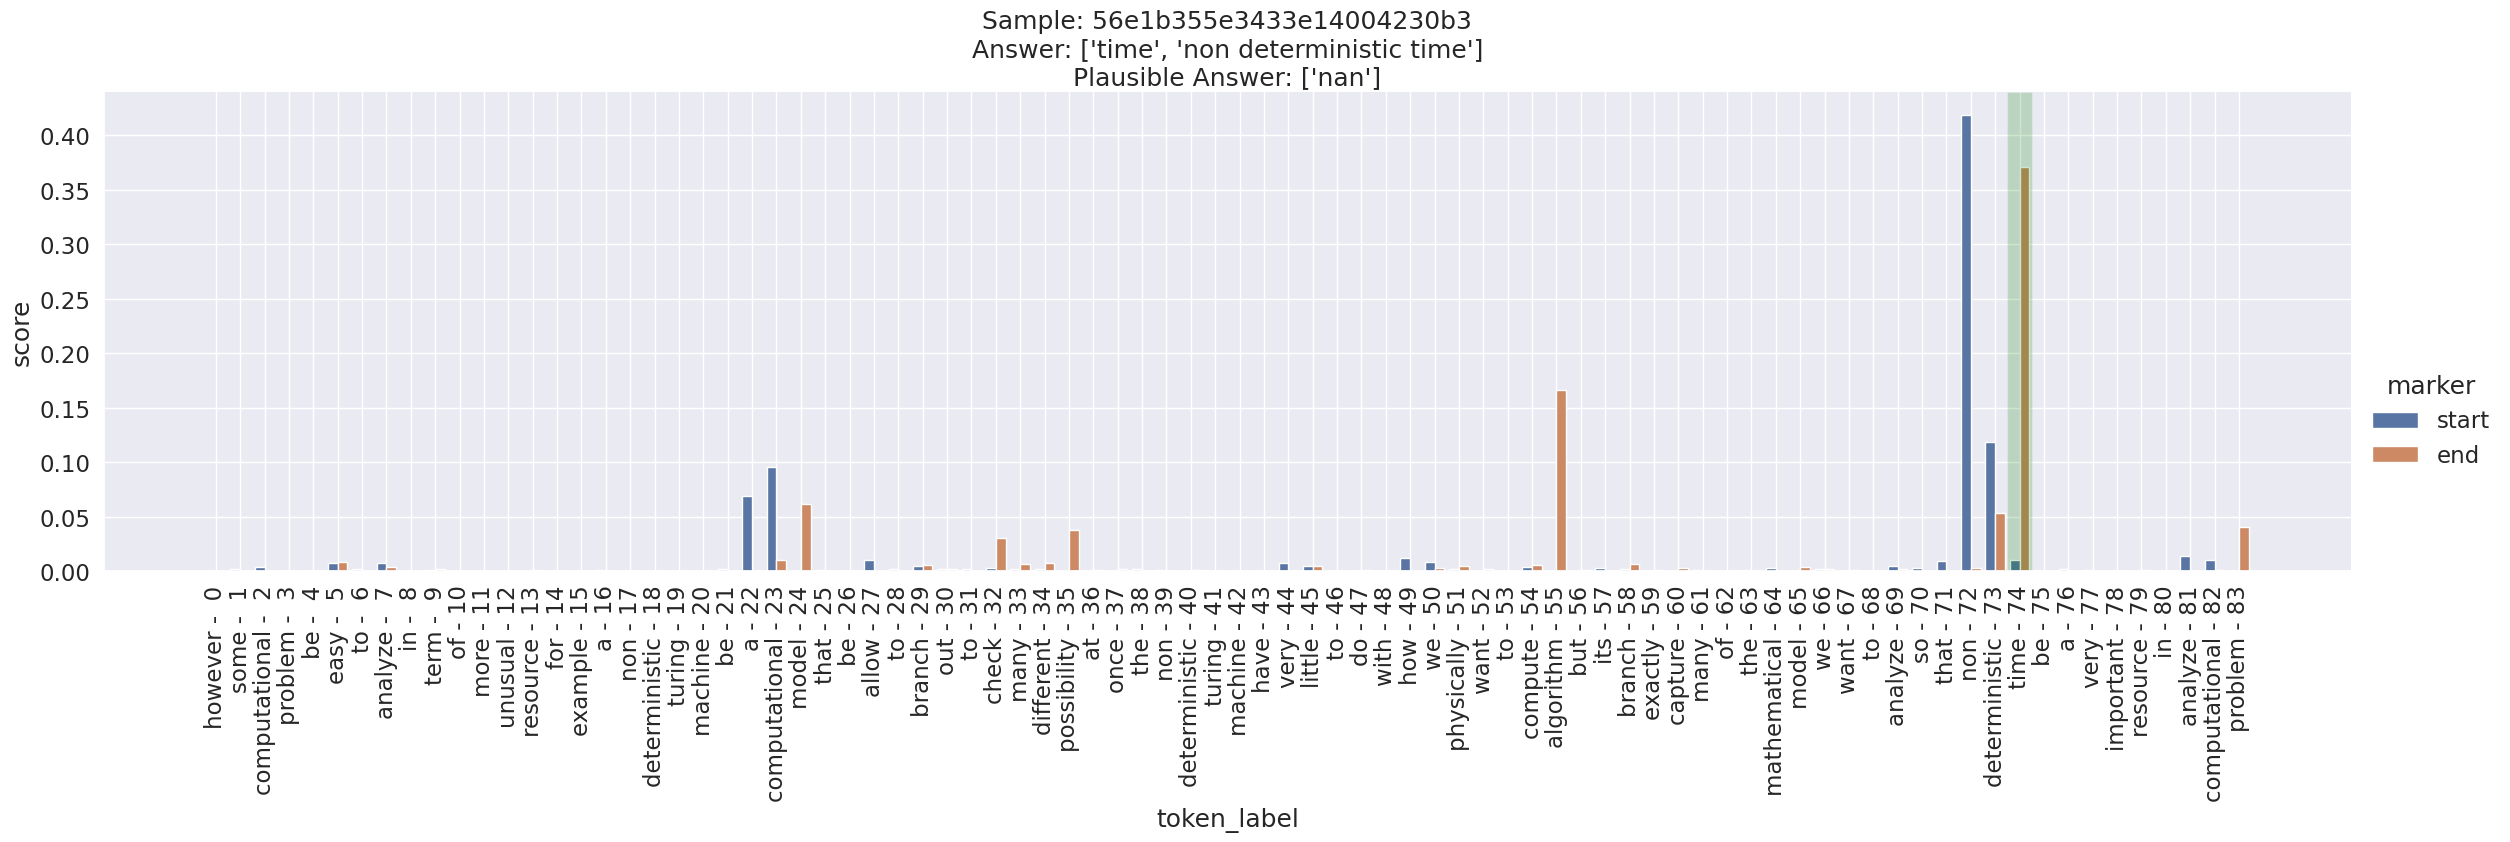

In [ ]:
sample_result = results[10]
evaluation_utils.get_graphics(sample_result, test_df_grp)

In [ ]:
for sample in answers[:20]:
  print(f"Sample:                   {sample['id']}")
  print(f"Predicted token:          ({sample['predicted_start_token_oncontext']}, {sample['predicted_end_token_oncontext']})")
  print(f"Target token:             ({sample['target_start_token_oncontext']}, {sample['target_end_token_oncontext']})")
  print(f"Predicted answer:         {sample['predicted_answer']}")
  print(f"Answer score:             {sample['answer_score']}")
  print(f"No answer score:          {sample['no_answer_score']}")
  print(f"Correct answer:           {sample['target_answer']}")
  print(f"Correct plausible:        {sample['target_plausible']}")
  print()

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!python evaluate.py {'dataset/dev-v2.0.json'} {'results/answers_bidaf_original.json'}

{
  "exact": 50.24004042786154,
  "f1": 55.67969814269031,
  "total": 11873,
  "HasAns_exact": 46.912955465587046,
  "HasAns_f1": 57.807870453467906,
  "HasAns_total": 5928,
  "NoAns_exact": 53.55761143818335,
  "NoAns_f1": 53.55761143818335,
  "NoAns_total": 5945
}


## BiDAF Pro

Then, get the model to be evaluated. Here we are getting the BiDAF Pro.

In [ ]:
# 4. SET HERE
#     THE MODEL TO BE EVALUATED AND ITS HYPERPARAMETERS
test_model = BiDAF(word_vectors = word_vectors,
              hidden_size = 100,
              model_type = 'pro',
              alphabet_size = alphabet_size,
              char_embed_dim = 8,
              char_channel_width = 5,
              drop_prob = 0.2)

#     WHERE TO FIND THE BEST TRAINING CHECKPOINT
checkpoint_path = 'models/bidaf_pro.pth.tar'

In [ ]:
test_model = torch.nn.DataParallel(test_model, args.gpu_ids)
test_model = test_model.to(device)

loaded_model, step = train_utils.load_model(test_model, checkpoint_path, args.gpu_ids)

Finally, get and analyze the predictions. Note that the predict function presented before has been slightly modified to be compliant with the inputs required by the model.



In [ ]:
predictions = evaluation_utils.predict_pro(loaded_model, test_loader, device)

  0%|          | 0/256 [00:00<?, ?it/s]

In [ ]:
len(predictions)

16333

In [ ]:
results = evaluation_utils.process_predictions(predictions)

  0%|          | 0/16333 [00:00<?, ?it/s]

In [ ]:
answers = evaluation_utils.retrieve_answers(results, test_df)

  0%|          | 0/16333 [00:00<?, ?it/s]

In [ ]:
ans_eval = evaluation_utils.eval_results(answers)

  0%|          | 0/16333 [00:00<?, ?it/s]

In [ ]:
# 5. SET HERE WHERE TO WRITE THE ANSWERS
answers_towrite_filename = 'results/answers_bidaf_pro.json'
results_towrite_filename = 'results/pkl_bidaf_pro.plk'

In [ ]:
# Save the answers to a file
with open(answers_towrite_filename, "w") as outfile:
  json.dump(ans_eval, outfile)

In [ ]:
# Save the data to a file
with open(results_towrite_filename, "wb") as outfile:
  pickle.dump(results, outfile)

In [ ]:
# Load data from the file
#with open(answers_towrite_filename, "rb") as file: predictions = json.load(file)
#with open(results_towrite_filename, "rb") as file: results = pickle.load(file)

In [ ]:
sample_result = results[1]
evaluation_utils.get_graphics(sample_result, test_df_grp)

In [ ]:
sample_result = results[10]
evaluation_utils.get_graphics(sample_result, test_df_grp)

In [ ]:
for sample in answers[:20]:
  print(f"Sample:                   {sample['id']}")
  print(f"Predicted token:          ({sample['predicted_start_token_oncontext']}, {sample['predicted_end_token_oncontext']})")
  print(f"Target token:             ({sample['target_start_token_oncontext']}, {sample['target_end_token_oncontext']})")
  print(f"Predicted answer:         {sample['predicted_answer']}")
  print(f"Answer score:             {sample['answer_score']}")
  print(f"No answer score:          {sample['no_answer_score']}")
  print(f"Correct answer:           {sample['target_answer']}")
  print(f"Correct plausible:        {sample['target_plausible']}")
  print()

In [ ]:
!python evaluate.py {"dataset/dev-v2.0.json"} {'results/answers_bidaf_pro.json'}

{
  "exact": 51.02333024509391,
  "f1": 55.85737482217886,
  "total": 11873,
  "HasAns_exact": 48.431174089068826,
  "HasAns_f1": 58.113126056634066,
  "HasAns_total": 5928,
  "NoAns_exact": 53.6080740117746,
  "NoAns_f1": 53.6080740117746,
  "NoAns_total": 5945
}


# 6. State-of-the-art reference
---
Testing a popular model from huggingface fine tuned on Squad2 (Roberta)

In [ ]:
!pip install transformers datasets evaluate

We will try **tinyroberta-squad2**. This is the distilled version of the deepset/roberta-base-squad2 model. This model has a comparable prediction quality and runs at twice the speed of the base model.

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

model_name = "deepset/tinyroberta-squad2"

model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
pipe = pipeline('question-answering', model=model, tokenizer=tokenizer)

Create the dataset to test  the model.

In [ ]:
class NLPDataset(Dataset):

  def __init__(self,dataframe):

    self.batch_input = []
    self.batch_ids = []
    for index, row in tqdm(dataframe.iterrows(),total=dataframe.shape[0],desc='Converting'):
      self.batch_input.append({'question':row['question'],'context':row['context']})
      self.batch_ids.append(row['id'])

  def __len__(self):
    return len(self.batch_input)

  def __getitem__(self,idx):
    return self.batch_input[idx]

In [ ]:
test_df = squad_json_to_df(file_path = "dataset/dev-v2.0.json")

In [ ]:
test_data = NLPDataset(test_df)

Converting:   0%|          | 0/16333 [00:00<?, ?it/s]

Now use Tiny Roberta in inference mode to get the answers.

In [ ]:
bsize = 8
outRes = {}

for i,e in enumerate(tqdm(pipe(test_data, batch_size=bsize), total=len(test_data))):
  id:str = test_data.batch_ids[i]
  outRes[id] = e['answer'] if e['score']>0.1 else ''

  0%|          | 0/16333 [00:00<?, ?it/s]

In [ ]:
save_filepath = "results/tinyroberta-squad2-prediction.json"
with open(save_filepath, "w") as outfile: json.dump(outRes, outfile)

In [ ]:
!python code/evaluate.py {"dataset/dev-v2.0.json"} {"results/tinyroberta-squad2-prediction.json"}

{
  "exact": 78.35424913669671,
  "f1": 81.34010815153808,
  "total": 11873,
  "HasAns_exact": 76.34952766531714,
  "HasAns_f1": 82.32980838110858,
  "HasAns_total": 5928,
  "NoAns_exact": 80.35323801513877,
  "NoAns_f1": 80.35323801513877,
  "NoAns_total": 5945
}


It can be noticed that the RoBERTa model outperforms the BIDAF model on the SQuAD 2.0 dataset. This is due to its pre-training on a large corpus, transfer learning capabilities, transformer architecture with self-attention mechanisms, larger parameter size and model capacity, and exposure to diverse data. RoBERTa's extensive pre-training captures a wide range of language patterns, while fine-tuning on SQuAD 2.0 improves generalization. Its transformer architecture efficiently captures long-range dependencies and contextual relationships. The larger parameter size enables RoBERTa to learn finer-grained details and complex word relationships. Finally, RoBERTa's exposure to diverse data aids in handling the variability present in SQuAD 2.0. These factors collectively contribute to RoBERTa's superior performance on the dataset